In [1]:
from IPython.display import HTML
from IPython.display import display, HTML
from PIL import Image
from dask.distributed import Client
from dask.distributed import as_completed
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.dates import DateFormatter
from pandas.io.formats.style import Styler
from pivottablejs import pivot_ui
from pmdarima.arima import auto_arima
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import datetime as dt
import matplotlib
import matplotlib as mp
import matplotlib as mpl
import matplotlib.dates as md
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_market_calendars as mcal
import pickle
import rpy2
import seaborn as sns
import sqlite3
import statsmodels.api as sm
import warnings
pd.options.display.max_columns = 50
pd.options.display.max_rows = 200

In [2]:
def time_to_int(dateobj):
    total = int(dateobj.strftime('%S'))
    total += int(dateobj.strftime('%M')) * 60
    total += int(dateobj.strftime('%H')) * 60 * 60
    total += (int(dateobj.strftime('%j')) - 1) * 60 * 60 * 24
    total += (int(dateobj.strftime('%Y')) - 1970) * 60 * 60 * 24 * 365
    return total

def myfunc(x):
    return slope * x + intercept

In [3]:
def highlight_cells(val, color_if_true, color_if_false, threshold_):
    color = color_if_true if val >= threshold_ else color_if_false
    return 'background-color: {}'.format(color)

In [4]:
db_filename = 'todo.db'

db_is_new = not os.path.exists(db_filename)

conn = sqlite3.connect(db_filename)

if db_is_new:
    print('Need to create schema')
else:
    print('Database exists, assume schema does, too.')

conn.close()

Database exists, assume schema does, too.


In [5]:
si = ['03-31','06-30','09-30','12-31']
               
[start,end, prices_df, sp1500_index_df, sp500, sp600, sp400, market_data, completed_fred_pvt, completed_bonds, completed_bonds_pvt, sectors, indexes, screener_sorted] = pickle.load(open('./data_object.pkl', 'rb'))

prices = prices_df
#prices = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="SP1500_Sectors_Indexes_Prices")

In [6]:
def colored(r, g, b, text):
    return f"\033[38;2;{r};{g};{b}m{text}\033[0m"

In [7]:
def display_side_by_side(dfs:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))

In [8]:
cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)

def b_g(s, cmap=cm, low=0, high=0):
    # Pass the columns from Dataframe A 
    a = A.loc[:,s.name].copy()
    #rng = a.max() - a.min()
    rng = np.nanmax(A.values.ravel()) - np.nanmin(A.values.ravel())
    norm = mp.colors.Normalize(np.nanmin(A.values.ravel()) - (rng * low),
                        np.nanmax(A.values.ravel()) + (rng * high))
    normed = norm(a.values)
    #c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    return ['background-color: %s' % color for color in c]

In [9]:
nyse = mcal.get_calendar('NYSE')
nyse_dates = nyse.schedule(start_date=start, end_date=end)

In [10]:
stock_fundamentals = market_data
screener = screener_sorted
fundamentals = stock_fundamentals
stock_indexes = sp1500_index_df

spdr_indexes = indexes
spdr_indexes.columns=['Symbol']
vanguard_sectors = sectors
vanguard_sectors.columns=['Symbol']

In [11]:
sector_performance_return = pd.DataFrame()
sector_performance_Q_smoothed_return = pd.DataFrame()

for v in [*spdr_indexes['Symbol'],*vanguard_sectors['Symbol']]:
    subset = prices[prices['Symbol'] == v]
    #subset_ = subset.set_index('Date').asfreq('Q')[['Adj Close']].pct_change()
    subset_ = subset.asfreq('D').interpolate().asfreq('Q')[['Adj Close']].pct_change()
    #print(subset_)
    #subset_qs = subset.set_index('Date')[['Adj Close']].pct_change().rolling(63).mean()
    subset_qs = subset[['Adj Close']].pct_change().rolling(63).mean()
    subset_.index = subset_.index.values.astype('M8[D]')
    subset_qs.index = subset_qs.index.values.astype('M8[D]')
    dt_str = subset_.index[-1].strftime('%Y-%m-%d')
    #tail = subset[subset.set_index('Date').index>=dt_str]
    tail = subset[subset.index>=dt_str]
    #dt_str = subset.set_index('Date').index[-1].strftime('%Y-%m-%d')
    dt_str = subset.index[-1].strftime('%Y-%m-%d')
    #tail_ = pd.DataFrame([(tail.set_index('Date')['Adj Close'][-1]-tail.set_index('Date')['Adj Close'][0])/tail.set_index('Date')['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    tail_ = pd.DataFrame([(tail['Adj Close'][-1]-tail['Adj Close'][0])/tail['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    subset__ = pd.concat([subset_,tail_],axis=0)
    sector_performance_return = pd.concat([sector_performance_return,subset__],axis=1)
    sector_performance_Q_smoothed_return = pd.concat([sector_performance_Q_smoothed_return,subset_qs],axis=1)

In [12]:
sector_performance_Q_smoothed_return.columns = [*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]]
sector_performance_return.columns = [*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]]

Seasonal Indexes


Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison
Current


standard deviations


03-31     06-30     09-30     12-31
SP1500                      0.134644  0.072380  0.037999  0.110320
SP500                       0.127411  0.070450  0.039033  0.106496
SP600                       0.199479  0.088447  0.037096  0.179394
SP400                       0.157662  0.100224  0.037075  0.138781
Communication Services ETF  0.138244  0.095192  0.045269  0.123434
Consumer Discretionary ETF  0.151791  0.146922  0.083611  0.127243
Consumer Staples ETF        0.096633  0.035421  0.049261  0.063730
Energy ETF                  0.369457  0.166709  0.099129  0.202483
Financials ETF              0.192299  0.053666  0.014462  0.140299
Health Care ETF             0.079810  0.054107  0.065798  0.098650
Industrials ETF             0.178470  0.072339  0.066050  0.134044
Information Technology ETF  0.135329  0.113409  0.054569  0.136753
Materials ETF               0.163483  0.099766  0.065317  0.127072
Real Estate ETF             0.161483  0.056090  0.032025  0.078165
Utilities ETF               0.092016  0.021473  0.033841  0.054883

t scores


03-31     06-30     09-30     12-31
SP1500                     -0.035281  0.505153  0.489908  0.202519
SP500                      -0.042087  0.512730  0.522980  0.210329
SP600                      -0.039834  0.407076  0.230960  0.144515
SP400                      -0.056330  0.357747  0.247928  0.166115
Communication Services ETF -0.106341  0.357027  0.223180  0.064848
Consumer Discretionary ETF -0.062503  0.366041  0.280865  0.185493
Consumer Staples ETF       -0.086371  0.447954  0.315992  0.322196
Energy ETF                  0.067680  0.258283 -0.179260  0.093682
Financials ETF             -0.048166  0.508740  0.933164  0.208614
Health Care ETF            -0.100433  0.650529  0.278976  0.215182
Industrials ETF            -0.027615  0.360421  0.307577  0.133187
Information Technology ETF  0.020546  0.480423  0.562966  0.220841
Materials ETF              -0.072960  0.371283  0.191302  0.206478
Real Estate ETF            -0.073157  0.604012  0.271246  0.220111
Utilities ETF              -0.006140  0.544116  0.518265  0.342246

p values


array([[<AxesSubplot:title={'center':'03-31'}>,
        <AxesSubplot:title={'center':'06-30'}>],
       [<AxesSubplot:title={'center':'09-30'}>,
        <AxesSubplot:title={'center':'12-31'}>]], dtype=object)

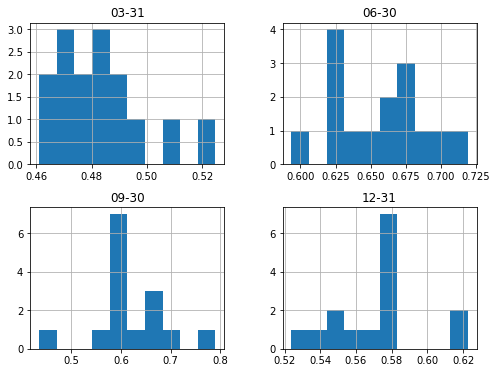

In [47]:
from scipy import stats as st
from scipy.stats import t

std_indexes = pd.DataFrame()
seasonal_indexes = pd.DataFrame()

warnings.filterwarnings('ignore')
for spr in sector_performance_return.columns:
    #print(spr)
    s = sector_performance_return[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in sector_performance_return[spr].index:

        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes = pd.concat([std_indexes,ct_std],axis=1)
    seasonal_indexes = pd.concat([seasonal_indexes,ct],axis=1)

seasonal_indexes.columns = sector_performance_return.columns

std_indexes.columns = sector_performance_return.columns
    
seasonal_indexes = seasonal_indexes.T

std_indexes = std_indexes.T

si = ['03-31','06-30','09-30','12-31']

print("Seasonal Indexes")

seasonal_index_values_sorted = []
seasonal_index_names_sorted = []
#B = seasonal_indexes[si]
for c in seasonal_indexes[si].columns:
    seasonal_index_values_sorted.append(seasonal_indexes[si][c].sort_values(ascending=False).values)
    seasonal_index_names_sorted.append(seasonal_indexes[si][c].sort_values(ascending=False).index.values)

temp_seasonal_index_values_sorted = pd.DataFrame(seasonal_index_values_sorted).T
temp_seasonal_index_values_sorted.columns = seasonal_indexes[si].columns

temp_seasonal_index_names_sorted = pd.DataFrame(seasonal_index_names_sorted).T
temp_seasonal_index_names_sorted.columns = seasonal_indexes[si].columns

A = temp_seasonal_index_values_sorted
B = temp_seasonal_index_names_sorted 

display(B.style.apply(b_g,cmap=cm))

display(seasonal_indexes[si].style.background_gradient(cmap = cm,axis=0))

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
print("Current")

display(seasonal_indexes[seasonal_indexes.columns.difference(si)].sort_values(by=seasonal_indexes[seasonal_indexes.columns.difference(si)].columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))    

#calculate p-value
n=5

print("standard deviations")
display(std_indexes[si])
t_scores = (seasonal_indexes[si])/(std_indexes[si]*np.sqrt(n))
print("t scores")
display(t_scores)
print("p values")
p_values = pd.DataFrame(t.cdf(t_scores, df=n-2),index=seasonal_indexes[si].index,columns=seasonal_indexes[si].columns)

display(p_values.style.applymap(highlight_cells, color_if_true='green', color_if_false='yellow', threshold_=.5))

p_values.hist()

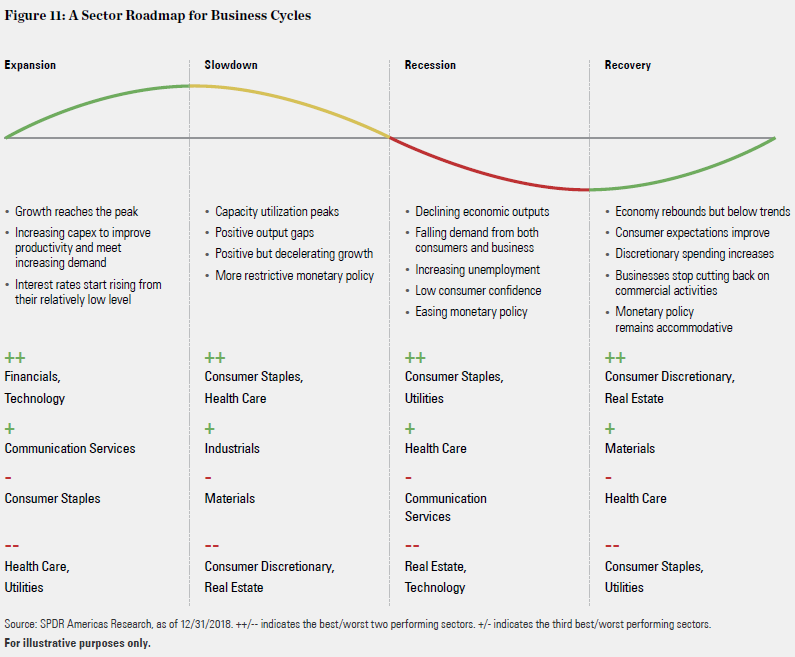

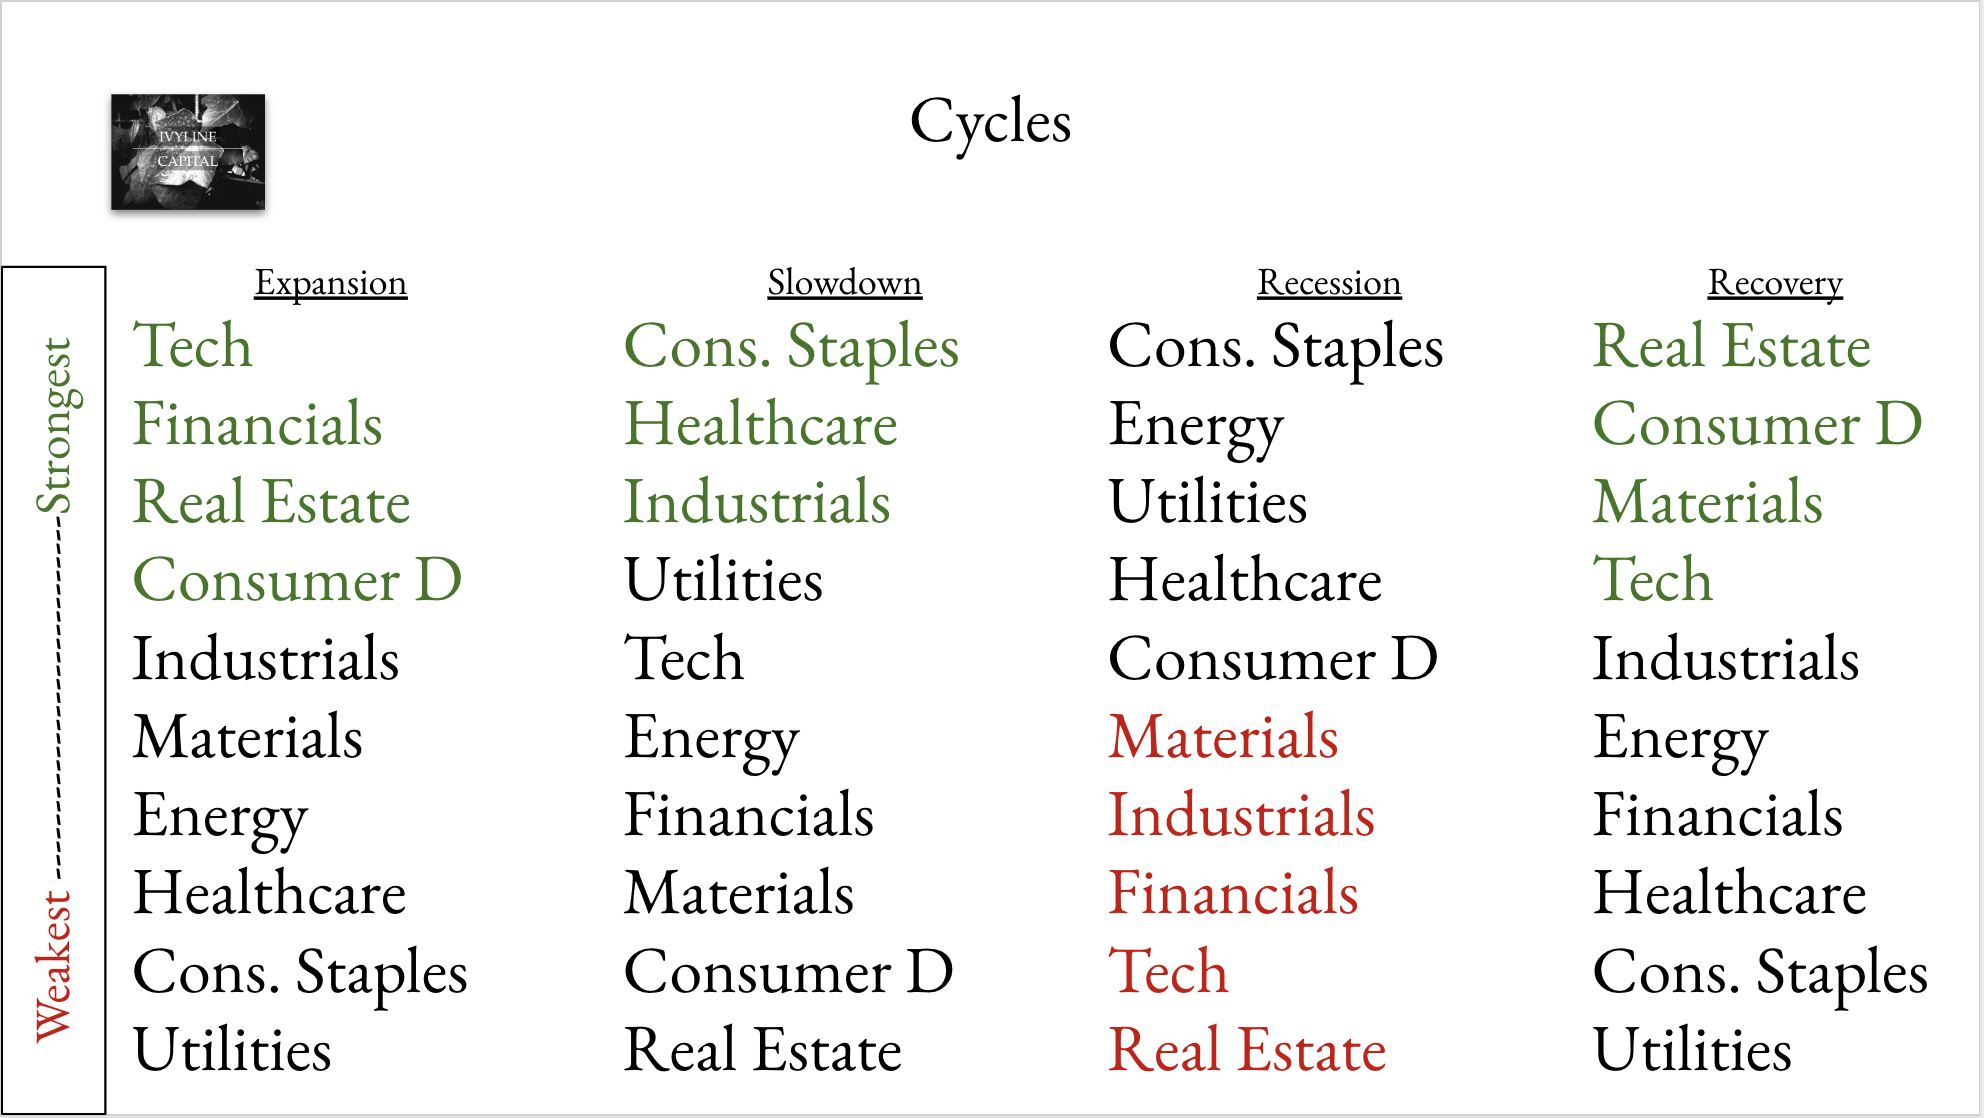

In [14]:
cycles_ = ['Expansion','Slowdown','Recession','Recovery']

path=r"C:\Users\User\Documents\wiki\wiki\dev\python\Python-Stock\reports\figures\Business cycles.png"
display(Image.open(path))
path=r"C:\Users\User\Documents\wiki\wiki\Finance\Business Cycles-2.png"
display(Image.open(path))

In [15]:
sector_performance_return_pvt = sector_performance_return[sector_performance_return.iloc[-1].sort_values(ascending=False).index]

sector_performance_return_pvt_heatmap = sector_performance_return_pvt.style.background_gradient(cmap = cm,axis=None)
display(sector_performance_return_pvt_heatmap)

sector_performances = pd.DataFrame()
sector_performances_values = pd.DataFrame()
for c in sector_performance_return.T.columns:
    #print(c)
    temp = pd.DataFrame(sector_performance_return.T[c].sort_values(ascending=False).index,columns=[c])
    #print(temp)
    temp2 = pd.DataFrame(sector_performance_return.T[c].sort_values(ascending=False),columns=[c])
    #print(temp2)
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances = pd.concat([sector_performances,temp],axis=1)
    sector_performances_values = pd.concat([sector_performances_values,temp2],axis=1)
    
A = sector_performances_values
B = sector_performances

df = B.style.apply(b_g,cmap='RdYlGn')

display(df)


In [48]:
#cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)
#pd.crosstab(shares_viz['Year'], shares_viz['Month'])

#seasonal_indexes[si]
seasonally_adjusted = pd.DataFrame()

for s in sector_performance_return.columns:
    
    s_ = pd.DataFrame(sector_performance_return[s])
    #print(sector_performance_return[s])
    years = []
    quarters = []
    
    for d in s_.index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)
        
    s_['Quarter'] = quarters
    si_ = seasonal_indexes.loc[s]
    
    modified = pd.DataFrame()
    #print(si_.index)
    for s_i_ in si_.index:
        #print(s_i_)
        #when it finds the last date (which hopefully isn't a quarter date)
        if(np.sum(np.array(si)==s_i_)==0):
            #print("don't modify")
            #print(s_i_)
            match = []
            for entry in si:
                if(int(s_i_.rsplit("-")[0])<=int(entry.rsplit("-")[0])):
                    match = entry
                    break            

            delta_months = int(match.rsplit("-")[0])-int(s_i_.rsplit("-")[0])
            delta_days_ = int(match.rsplit("-")[1])-int(s_i_.rsplit("-")[1])
            
            delta_days = int(delta_months*(91.25/3)+delta_days_)
            #daily interest
            
            #print(delta_days)
            #print(seasonal_indexes.loc[s].loc[match])
            seasonal_index_to_daily = (1+seasonal_indexes.loc[s].loc[match])**(1/91.25)-1
            #print("Seasonal Index to Daily Discounted Interest Rate:",seasonal_index_to_daily)
            daily_extrapolated = (1+seasonal_index_to_daily)**delta_days-1
            #print(daily_extrapolated)
            #print("Daily ^ delta_days:",daily_extrapolated)
            
            #print(match)
            #print(s_i_)
            seasonally_adjusted_column = pd.DataFrame([seasonal_indexes.loc[s].loc[match] - daily_extrapolated],columns=[s],index=[s_.index[-1]])
            
            
        else:
            seasonally_adjusted_column = pd.DataFrame(s_[s][s_['Quarter']==s_i_] - seasonal_indexes.loc[s].loc[s_i_],columns=[s])
        modified = pd.concat([modified,seasonally_adjusted_column],axis=0)
        modified.sort_index(inplace=True)
    #print(modified)
    seasonally_adjusted = pd.concat([seasonally_adjusted,modified],axis=1)

print("Comparative to Seasonal Indexes, tells you who is over or underperforming.")
print("This is Seasonal Index - Extrapolated Current Quarter.")
print("+: seasonal > current")
print("-: current > seasonal")

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
    
    
std_indexes_seas_adj = pd.DataFrame()
seasonal_indexes_seas_adj = pd.DataFrame()

temp_ = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1])
temp_.columns = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1]).columns.strftime('%Y-%m-%d')
display(temp_.sort_values(by=temp_.columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))

#display(seasonally_adjusted[seasonally_adjusted.columns.difference(si)].style.background_gradient(cmap = cm,axis=0))

for spr in seasonally_adjusted.columns:
    #print(spr)
    s = seasonally_adjusted[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in seasonally_adjusted[spr].index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    #print(ct)
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes_seas_adj = pd.concat([std_indexes_seas_adj,ct_std],axis=1)
    seasonal_indexes_seas_adj = pd.concat([seasonal_indexes_seas_adj,ct],axis=1)

seasonal_indexes_seas_adj.columns = seasonally_adjusted.columns

std_indexes_seas_adj.columns = seasonally_adjusted.columns
    
seasonal_indexes_seas_adj = seasonal_indexes_seas_adj.T

std_indexes_seas_adj = std_indexes_seas_adj.T

sector_performances_sea_adj = pd.DataFrame()
sector_performances_values_sea_adj = pd.DataFrame()
for c in seasonally_adjusted.T.columns:
    temp = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False).index,columns=[c])
    temp2 = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False),columns=[c])
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances_sea_adj = pd.concat([sector_performances_sea_adj,temp],axis=1)
    sector_performances_values_sea_adj = pd.concat([sector_performances_values_sea_adj,temp2],axis=1)

A = sector_performances_values_sea_adj
B = sector_performances_sea_adj

df_sea_adj = B.style.apply(b_g,cmap='RdYlGn')
display(df_sea_adj)

Comparative to Seasonal Indexes, tells you who is over or underperforming.
This is Seasonal Index - Extrapolated Current Quarter.
+: seasonal > current
-: current > seasonal
Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison


In [17]:
index_performance = []
for v in spdr_indexes['Symbol'].values:
    index_performance.append([v,screener.loc[v]['risk_trend_factor']])
temp_i = pd.DataFrame(index_performance,index=spdr_indexes.index)
temp_i.columns = ['Symbol','risk_trend_factor']
index_risk_sorted = pd.DataFrame(index_performance,columns=['Symbol','risk_trend_factor'],index=spdr_indexes.index).sort_values(by='risk_trend_factor',ascending=False).reset_index()
index_risk_sorted.columns = ['Index','Symbol','risk_trend_factor']
index_risk_sorted

Index Symbol  risk_trend_factor
0   SP500    SPY          -3.321707
1  SP1500   SPTM          -3.358764
2   SP400   MDYG          -4.591661
3   SP600    SLY          -4.866667

In [18]:
sector_performance = []
for v in vanguard_sectors['Symbol'].values:
    sector_performance.append([v,screener.loc[v]['risk_trend_factor']])
temp_v = vanguard_sectors.reset_index()
temp_v.columns = ['Sector','Symbol']
sectors_risk_sorted = pd.DataFrame(sector_performance,columns=['Symbol','risk_trend_factor']).merge(temp_v, on='Symbol', how='left').sort_values(by='risk_trend_factor',ascending=False)    
sectors_risk_sorted

Symbol  risk_trend_factor                      Sector
3     VDE           1.395093                  Energy ETF
2     VDC          -2.027309        Consumer Staples ETF
10    VPU          -2.036765               Utilities ETF
8     VAW          -2.726447               Materials ETF
9     VNQ          -2.883868             Real Estate ETF
5     VHT          -2.889925             Health Care ETF
4     VFH          -4.046674              Financials ETF
6     VIS          -4.146982             Industrials ETF
1     VCR          -4.247322  Consumer Discretionary ETF
7     VGT          -4.508045  Information Technology ETF
0     VOX          -6.489858  Communication Services ETF

Rolling Quarterly Mean Return


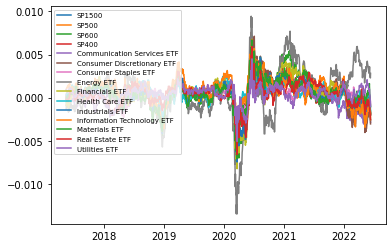

In [19]:
print("Rolling Quarterly Mean Return")
plt.plot(sector_performance_Q_smoothed_return)
plt.legend([*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]],loc=2,fontsize=7)
plt.show()

Quarterly Returns


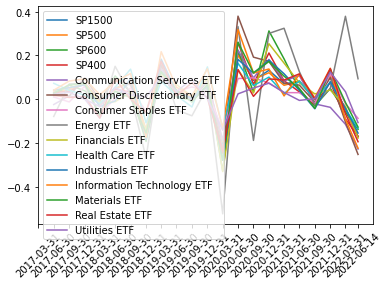

In [20]:
print ("Quarterly Returns")
for v in sector_performance_return.T.index:
    subset = pd.DataFrame(sector_performance_return.T.loc[v])
    subset.columns = ['Return']
    plt.plot(subset)
    plt.xticks(subset.index, rotation=45)
plt.legend(sector_performance_return.T.index,loc=2)    
plt.show()


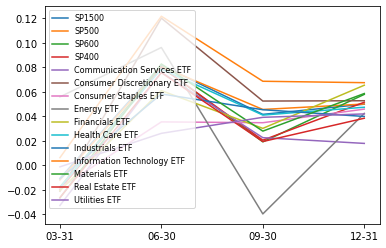

In [21]:
plt.plot(seasonal_indexes[si].T)
plt.legend(seasonal_indexes[si].T.columns,loc=2,fontsize=8)
plt.show()

In [22]:
threshold = .975

In [23]:
screener_sorted_ = screener_sorted.reset_index().merge(stock_indexes,on='Symbol',how='left')

screener_good = screener_sorted_[screener_sorted_['risk_trend_factor']!='missing']

risk_trend_threshold = screener_good['risk_trend_factor'].quantile(q=[threshold]).values[0]


In [24]:
risk_trend_threshold

0.812633541825487

In [25]:
stock_sectors = stock_fundamentals['sector']

In [26]:
temp = stock_sectors.reset_index()
temp.columns = ['Symbol','Sector']
sector_merged = screener[['risk_trend_factor']].merge(temp, on='Symbol', how='right')
temp_sm = sector_merged.merge(sp1500_index_df, on='Symbol', how='left').set_index('Symbol')
temp_sm.columns = ['risk_trend_factor', 'Sector', 'index']
temp_sm = temp_sm.merge(spdr_indexes.reset_index(), on='index', how='left')
temp_sm.columns = ['risk_trend_factor', 'Sector', 'index','index_Symbol']
temp_sm.index = sector_merged['Symbol']

for spdr_ in range(0,len(spdr_indexes['Symbol'].values)):
    spdr__ = spdr_indexes['Symbol'].values[spdr_]
    spdr__i = spdr_indexes['Symbol'].index[spdr_]
    temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index']] = spdr__i
    temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index_Symbol']] = spdr__

C:\Users\User\AppData\Local\Temp\ipykernel_7384\2744307430.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index']] = spdr__i
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Se

array([[<AxesSubplot:title={'center':'risk_trend_factor'}>]], dtype=object)

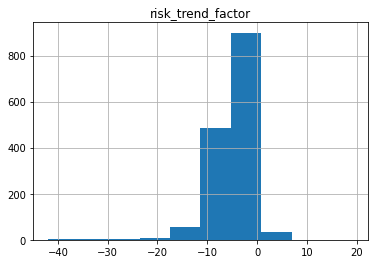

In [27]:
screener[['risk_trend_factor']].replace(['missing','error'], np.NaN).dropna().hist()

In [28]:
len(screener)

1520

In [29]:
risk_screened = screener_good[(screener_good['risk_trend_factor']>risk_trend_threshold) & (screener_good['volume_factor']!= 'missing')]
risk_screened = risk_screened.merge(temp, on='Symbol', how='left')
print(risk_screened.columns)
display(risk_screened[['Symbol','latest_p','risk_trend_factor','adf','hurst','Sector','Market Index','vol_30d_2yr']])

Index(['Symbol', 'max_2y', 'min_2y', 'std_2y', 'mean_2y', 'max_1y', 'min_1y',
       'std_1y', 'mean_1y', 'latest_p', '2yr_close_0pct', '2yr_close_2pct',
       '2yr_close_9pct', '2yr_close_25pct', '2yr_close_50pct',
       '2yr_close_75pct', '2yr_close_91pct', '2yr_close_98pct',
       '2yr_close_100pct', '1yr_close_0pct', '1yr_close_2pct',
       '1yr_close_9pct', '1yr_close_25pct', '1yr_close_50pct',
       '2yr_close_75pct', '1yr_close_91pct', '1yr_close_98pct',
       '1yr_close_100pct', 'risk_trend_factor', 'supply_trend_1yr',
       'supply_trend_60d', 'supply_trend_30d', 'vol_30d_2yr', 'pct_1yr',
       'pct_2yr', 'MIN_Lookback_One_Year', 'MIN_Lookback_2_Months',
       'MIN_Lookback_1_Months', 'vol_30d', 'volume_factor', 'adf', 'hurst',
       '1YMF', 'Market Index', 'Sector'],
      dtype='object')


Symbol    latest_p risk_trend_factor       adf     hurst  \
0     ACC   64.419998         19.217024  0.979637  0.418255   
1    MTOR        36.0          5.543488  0.304331  0.434725   
2       Y       832.0          2.342256   0.38518  0.458449   
3     TWI       19.15           1.92163  0.891295  0.499041   
4     PBF   38.919998          1.908312  0.699548  0.555964   
5    SAFM  207.410004          1.772278  0.669942  0.477196   
6     MPC  102.669998          1.736425  0.977688  0.523103   
7     DVN   70.589996           1.66933  0.988553  0.552856   
8     VLO      133.75          1.628343  0.922874  0.537334   
9     COP  111.489998          1.627301  0.980711  0.490397   
10   LNTH   62.580002           1.62217   0.98634  0.532554   
11    MRO   28.790001          1.564966  0.948885  0.544141   
12    APA        46.0          1.525584  0.413628  0.447575   
13    XOM   96.099998          1.519786  0.958139  0.535838   
14   NTUS   31.790001          1.497267  0.159539  0.413711   
15   BANF   91.309998          1.492805  0.916616  0.536421   
16     SM       48.68          1.482713  0.962497  0.477599   
17   FANG  149.630005          1.431262  0.795622  0.471983   
18   MUSA  233.460007          1.409106  0.994555  0.410124   
19    VDE  117.059998          1.395093  0.890286  0.520485   
20   PDCE   81.650002          1.370913  0.723739  0.494349   
21   MTDR   61.389999           1.32419   0.97374  0.466991   
22    CVX  167.550003          1.282539  0.949121  0.497243   
23   DINO   52.709999          1.260593  0.358718   0.56268   
24    MCK  306.519989          1.252954  0.998289  0.462444   
25    PXD  264.549988          1.247964  0.912273  0.497407   
26    HRB   34.380001          1.229135  0.725167  0.435532   
27    SWX   87.040001          1.106403  0.145807  0.399565   
28   CIVI   72.260002          1.099358  0.000891  0.485954   
29   CEIX   48.619999          1.087891   0.88812  0.521633   
30   CTRA   31.110001          1.075726  0.297053  0.466999   
31    EOG  131.259995          1.058399  0.811415  0.485527   
32   ROCC   45.240002          1.052877  0.622824  0.579733   
33    HES      120.07           1.04224  0.938257  0.449035   
34   TVTY        31.6               1.0  0.510164  0.449517   
35    OXY       62.09           0.96757  0.738509  0.544974   
36    MUR   41.580002          0.843595  0.791664  0.454943   
37   AZPN  184.309998           0.82682  0.752504  0.381769   

                Sector Market Index     vol_30d_2yr  
0                error        SP400   13781055000.0  
1    Consumer Cyclical        SP600    7888381900.0  
2   Financial Services        SP400     828602100.0  
3          Industrials        SP600    5400736000.0  
4               Energy        SP600   47517805800.0  
5   Consumer Defensive        SP400    2596619200.0  
6               Energy        SP500   72756266000.0  
7               Energy        SP500  121752263500.0  
8               Energy        SP500   46297639500.0  
9               Energy        SP500   96861604200.0  
10          Healthcare        SP600    7190737100.0  
11              Energy        SP500  252220800100.0  
12              Energy        SP500  105341198700.0  
13              Energy        SP500  282584082100.0  
14          Healthcare        SP600    2379907100.0  
15               error        SP600    1269485800.0  
16              Energy        SP600   43971070600.0  
17              Energy        SP500   30862818500.0  
18   Consumer Cyclical        SP400    2942817400.0  
19               error          NaN   13219432500.0  
20              Energy        SP400   12710569500.0  
21              Energy        SP400   25155623800.0  
22              Energy        SP500  121494374800.0  
23              Energy        SP400   26318648400.0  
24          Healthcare        SP500   11748608200.0  
25              Energy        SP500   24263857900.0  
26   Consumer Cyclical        SP400   27760839000.0  
27           Utilities        SP4

In [30]:

screened_final_set = risk_screened

In [31]:
fundamentals_quarterlies = pickle.load(open('./fundamental.pkl', 'rb'))

In [32]:
fundamental_entries = [e[0] for e in fundamentals_quarterlies]

In [33]:
list_ = []
for i in index_risk_sorted['Symbol'].values:
    list_.append(i)
for i in sectors_risk_sorted['Symbol'].values:
    list_.append(i)
for i in screened_final_set['Symbol'].values:
    list_.append(i)
indexes = np.unique(list_, return_index=True)[1]
list__ = [list_[index] for index in sorted(indexes)]

In [34]:
dict_sectors = {'Basic Materials':'VAW', 'Communication Services':'VOX', 'Consumer Cyclical':'VCR',
       'Consumer Defensive':'VDC', 'Energy':'VDE', 'Financial Services':'VFH', 'Healthcare':'VHT',
       'Industrials':'VIS', 'Real Estate':'VNQ', 'Technology':'VGT', 'Utilities':'VPU', 'error':'error'}

In [35]:
dict_indexes = {'SPTM':'SP1500', 'SPY':'SP500', 'SLY':'SP600', 'MDYG':'SP400','error':'error'}

In [36]:
dict_sectors_reverse = {'VAW':'Basic Materials',
 'VOX':'Communication Services',
 'VCR':'Consumer Cyclical',
 'VDC':'Consumer Defensive',
 'VDE':'Energy',
 'VFH':'Financial Services',
 'VHT':'Healthcare',
 'VIS':'Industrials',
 'VNQ':'Real Estate',
 'VGT':'Technology',
 'VPU':'Utilities',
 'error': 'error'}

In [37]:
def evaluate_ets(npa_):
    train,test,model_func,F1,F2 = npa_
    
    model=model_func(np.log(train),initialization_method='heuristic',seasonal=52,trend=F1,damped_trend=F2).fit()
    
    fc_ets_ = np.exp(model.forecast(13)) #inverting the Log
    
    rmse_ = mean_squared_error(test, fc_ets_, squared=True)
    return([rmse_])

In [40]:
#completed_fred_pvt_df = completed_fred_pvt.asfreq('D').reindex(nyse_dates.index).interpolate(method='time')
completed_fred_pvt_df = completed_fred_pvt

temp_new = completed_fred_pvt.asfreq('D').interpolate(method='time',limit_area='inside').reindex(nyse_dates.index)
temp_dates = pd.date_range(completed_fred_pvt.index[0].strftime('%Y-%m-%d'), completed_fred_pvt.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
nyse_inbetween_temp_dates = nyse_dates.index[(nyse_dates.index >= temp_dates[0]) & (nyse_dates.index <= temp_dates[-1])]
temp_new = temp_new.reindex(nyse_inbetween_temp_dates)

completed_fred_pvt_df = temp_new
completed_fred_pvt_df.columns = [name[1] for name in completed_fred_pvt_df.columns]

nominal, pct_change, pct_change().cumsum
Market volatility


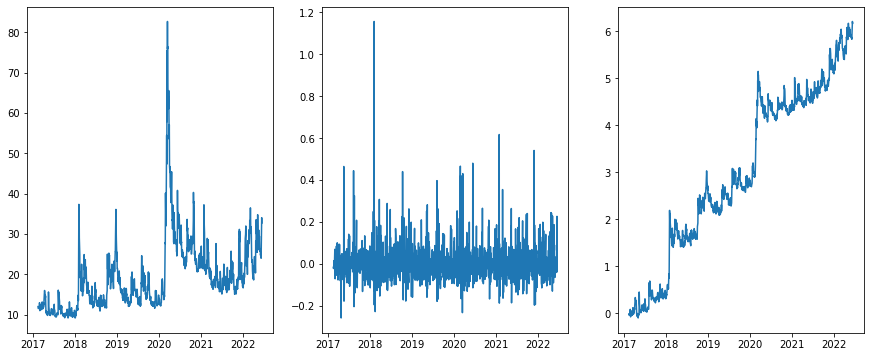

Consumer Confidence


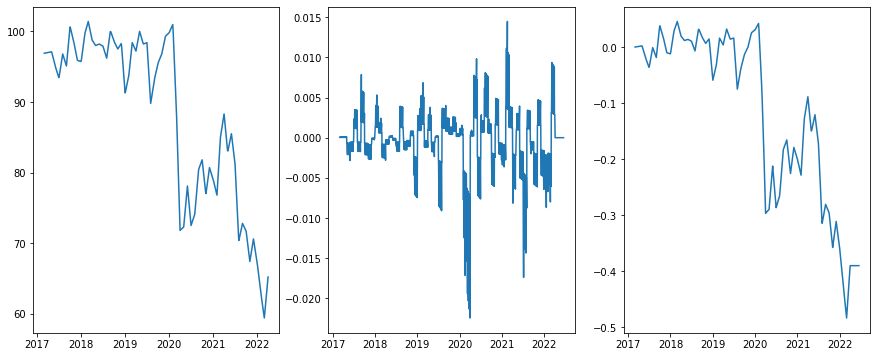

Unemployment


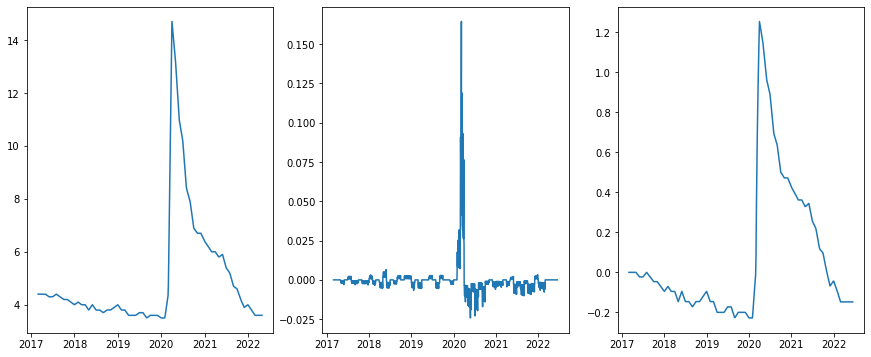

Inflation


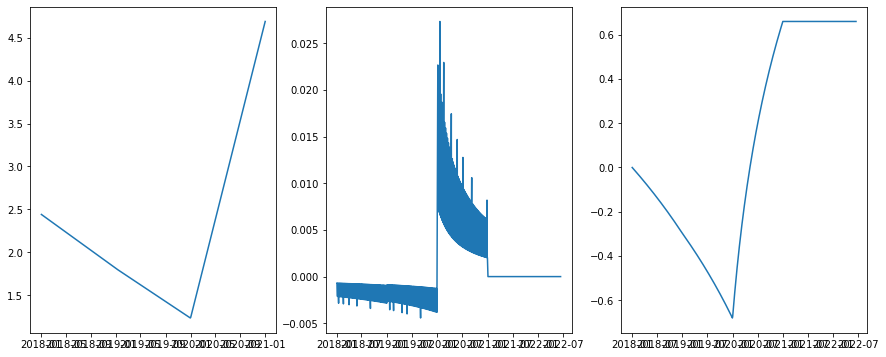

Interest Rates


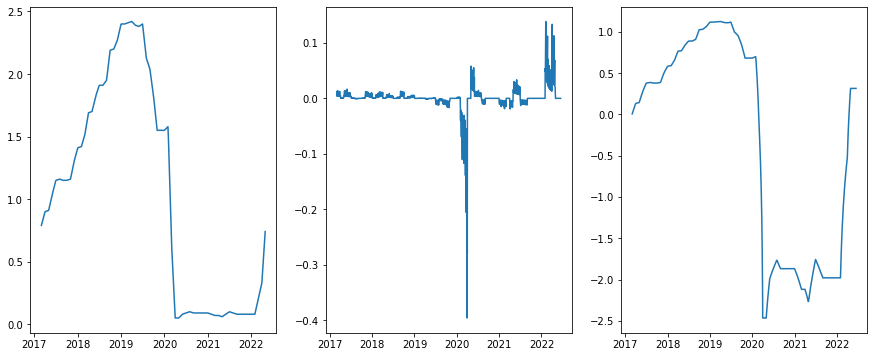

10 Year to 3 Month


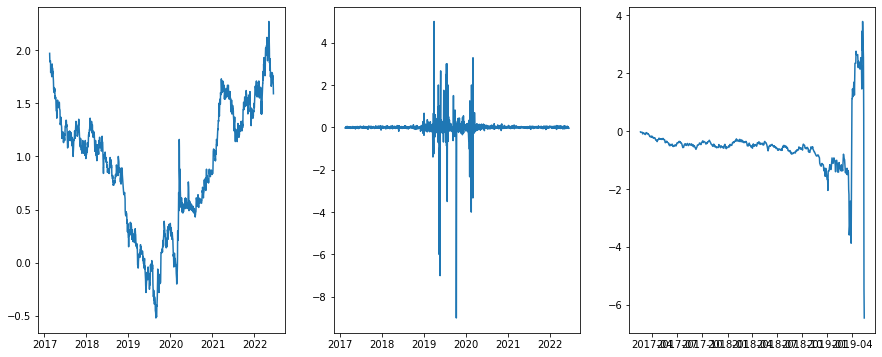

Recession Indicator


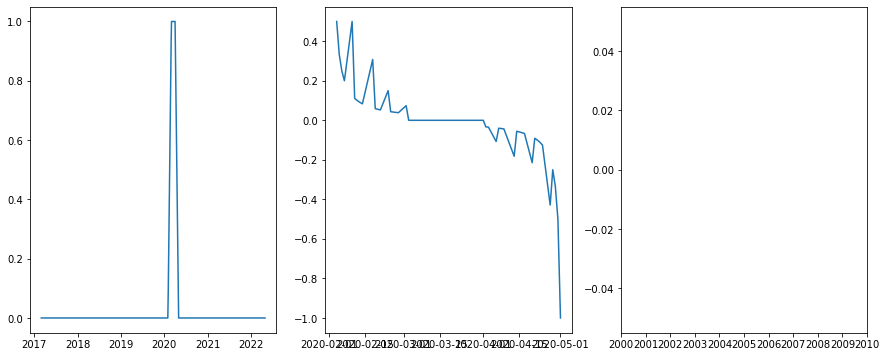

In [41]:
fred_friendly_names = ['Market volatility','Consumer Confidence','Unemployment','Inflation','Interest Rates','10 Year to 3 Month','Recession Indicator']
fred_names = ['VIXCLS','UMCSENT','UNRATE','FPCPITOTLZGUSA','FEDFUNDS','T10Y3M','USREC']
print('nominal,','pct_change,','pct_change().cumsum')
for pos in range(0,len(fred_names)):
    print(fred_friendly_names[pos])
    name = fred_names[pos]
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False,figsize=(15,6))
    ax1.plot(completed_fred_pvt_df[name])
    ax2.plot(completed_fred_pvt_df[name].pct_change())
    ax3.plot(completed_fred_pvt_df[name].pct_change().cumsum())
    plt.show()

In [42]:
screener['vol_30d_2yr']

Symbol
ACC     13781055000.0
MTOR     7888381900.0
Y         828602100.0
TWI      5400736000.0
PBF     47517805800.0
            ...      
GXO               NaN
CCSI              NaN
AIRC              NaN
HRMY              NaN
JW-A          missing
Name: vol_30d_2yr, Length: 1520, dtype: object

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\distributed\client.py:1265: VersionMismatchWarning: Mismatched versions found

+-------------+---------------+---------------+---------------+
| Package     | client        | scheduler     | workers       |
+-------------+---------------+---------------+---------------+
| dask        | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| distributed | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| lz4         | 3.1.3         | 3.1.10        | 3.1.10        |
| python      | 3.9.7.final.0 | 3.9.9.final.0 | 3.9.9.final.0 |
| toolz       | 0.11.1        | 0.11.2        | 0.11.2        |
+-------------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


adf < .05 or .01, mean reverting
Hurst
> .5 - The time series is mean reverting.
= .5 - The time series is a Geometric Brownian Motion.
< .5 - The time series is trending.
symbol: SPY
sector: error
sector: error
Index: SP500
vol_30d_2yr: 880461857300.0
Sector 1YMF: -263.8100280761719
1YMF: 0.0022075805827187875
risk trend factor: -3.321707170400029
      totalAssets  trailingPE
SPY  3.710190e+11     2.63136


Adj Close    21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-14  373.869995  377.05431  400.804286  424.554262  422.745398   

              90dSDev   90d_lower  90d_upper  
2022-06-14  23.333621  376.078155  469.41264

volume_factor    latest_p     vol_30d_2yr   pct_2yr       adf     hurst
SPY      0.002208  373.869995  880461857300.0  0.413919  0.695366  0.422162

C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


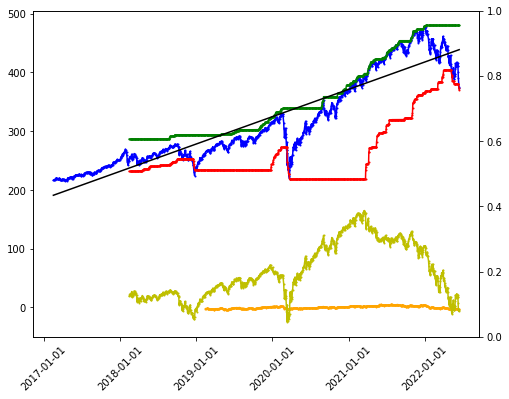

ets next 13 weeks
inner cv scores: [896.8975766275627, 896.8975918004722, 896.8975735235356, 896.8975999236275]
inner cv sdevs: [664.5686910942507, 664.5686789100486, 664.5686719967034, 664.5686974109883]
best model: ['F', 'F']
best inner cv score, sdev (11 folds): 896.8975735235356 664.5686719967034
test cv mean error, stdev (10 folds): [944.4210566860951, 678.9502274418586]
sell date: 2022-08-28
expected return: 0.031069868742507327
discounted return: 0.00041355806825960073
quarter return: 1.0387722397385468


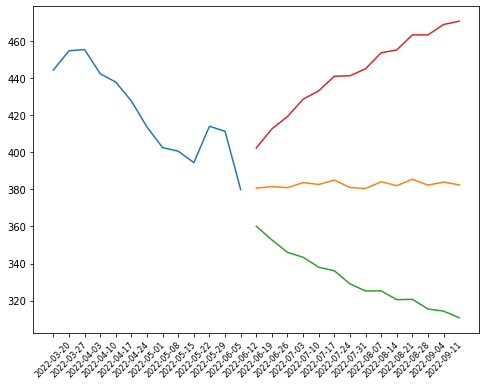

['options', ('2022-06-17', '2022-06-30', '2022-09-16', '2022-09-30', '2022-12-16', '2023-01-20', '2023-03-17', '2023-06-16', '2023-12-15', '2024-01-19', '2024-12-20')]
symbol: SPTM
sector: error
sector: error
Index: SP1500
vol_30d_2yr: 5201844300.0
Sector 1YMF: -32.58000946044922
1YMF: 0.0030551471907761638
risk trend factor: -3.3587635977232946
Empty DataFrame
Columns: []
Index: [SPTM]


Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14  46.099998  46.489957  49.444444  52.398932  52.094127  2.828054   

           90d_lower  90d_upper  
2022-06-14  46.43802  57.750234

volume_factor   latest_p   vol_30d_2yr   pct_2yr       adf     hurst
SPTM      0.003055  46.099998  5201844300.0  0.423367  0.683931  0.429284

C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


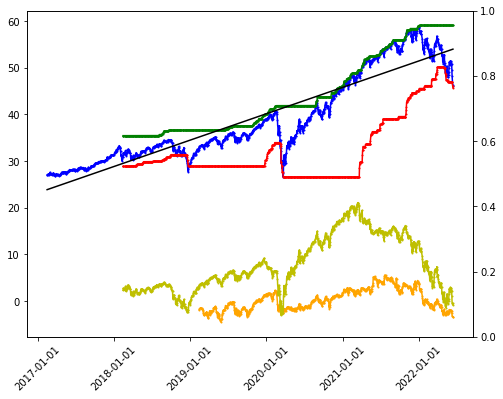

ets next 13 weeks
inner cv scores: [13.691379393897245, 13.691379393897245, 13.691379421717125, 13.691379219975392]
inner cv sdevs: [10.047228454226708, 10.047228454226708, 10.047228450840223, 10.047228107538883]
best model: ['F', 'T']
best inner cv score, sdev (11 folds): 13.691379219975392 10.047228107538883
test cv mean error, stdev (10 folds): [14.411595905559233, 10.263315717261595]
sell date: 2022-08-28
expected return: 0.03377647922453026
discounted return: 0.00044900052402097046
quarter return: 1.042163433829165


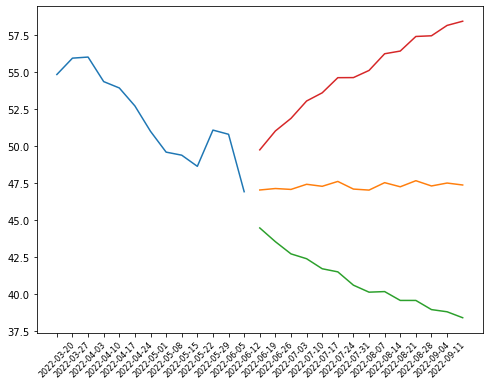

['options', ('2022-06-17',)]
symbol: MDYG
sector: error
sector: error
Index: SP400
vol_30d_2yr: 2570312700.0
Sector 1YMF: -63.869998931884766
1YMF: 0.0011014613124698796
risk trend factor: -4.591660649354175
Empty DataFrame
Columns: []
Index: [MDYG]


Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14     61.66  61.685558  66.113175  70.540792  69.694445  3.996942   

           90d_lower  90d_upper  
2022-06-14  61.70056  77.688329

volume_factor latest_p   vol_30d_2yr   pct_2yr       adf     hurst
MDYG      0.001101    61.66  2570312700.0  0.308819  0.549257  0.452092

C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


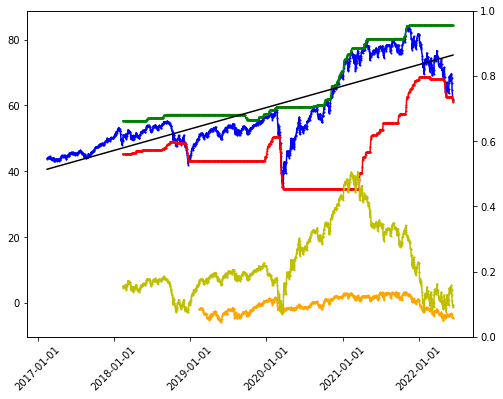

ets next 13 weeks
inner cv scores: [36.61053237685582, 36.61053239832299, 36.61053237685582, 36.61053232137597]
inner cv sdevs: [32.65372604592799, 32.65372602719306, 32.65372604592799, 32.65372601883619]
best model: ['F', 'T']
best inner cv score, sdev (11 folds): 36.61053232137597 32.65372601883619
test cv mean error, stdev (10 folds): [39.399144320764556, 32.975028200307406]
sell date: 2022-08-14
expected return: 0.044351153582295647
discounted return: 0.0007235247330383832
quarter return: 1.0688039361821564


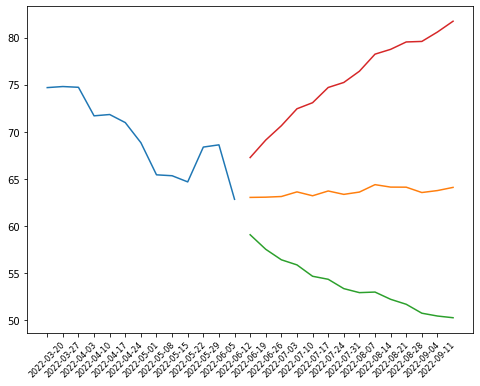

['options', ('2022-06-17',)]
symbol: SLY
sector: error
sector: error
Index: SP600
vol_30d_2yr: 928269400.0
Sector 1YMF: -69.3499984741211
1YMF: 0.0022254315395940014
risk trend factor: -4.866666559587445
      totalAssets
SLY  1.703341e+09


Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA  90dSDev  \
2022-06-14  80.730003  80.784692  85.904285  91.023878  88.959683  4.13917   

            90d_lower  90d_upper  
2022-06-14  80.681342  97.238024

volume_factor   latest_p  vol_30d_2yr   pct_2yr       adf     hurst
SLY      0.002225  80.730003  928269400.0  0.502933  0.580461  0.514913

C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


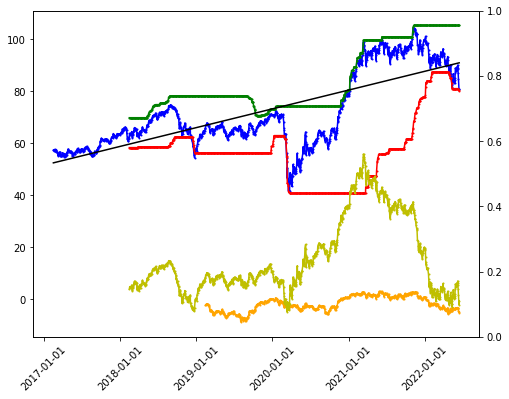

ets next 13 weeks
inner cv scores: [63.2394369051782, 63.2394368196984, 63.23943695976586, 63.239436960512734]
inner cv sdevs: [56.49895888480584, 56.49895893730717, 56.49895924650045, 56.49895910269093]
best model: ['T', 'F']
best inner cv score, sdev (11 folds): 63.2394368196984 56.49895893730717
test cv mean error, stdev (10 folds): [66.84056960033242, 58.0404678456298]
sell date: 2022-08-14
expected return: 0.0453239070838725
discounted return: 0.0007390529038044935
quarter return: 1.0703307944202143


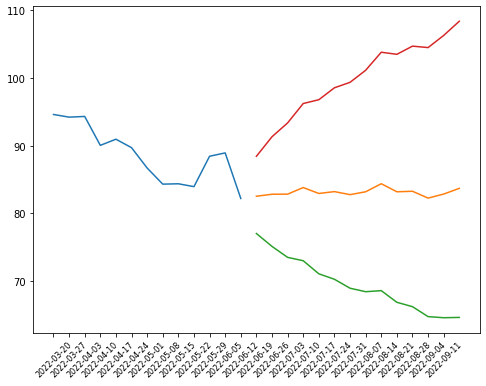

symbol: VDE
sector: error
sector: Energy
Index: nan
vol_30d_2yr: 13219432500.0
Sector 1YMF: 43.219993591308594
1YMF: 0.0015231818763778249
risk trend factor: 1.395093250744777
      totalAssets  trailingPE
VDE  9.791998e+09    9.531159


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-14  117.059998  110.042752  120.133016  130.223281  112.220159   

             90dSDev  90d_lower   90d_upper  
2022-06-14  6.984736  98.250688  126.189631

volume_factor    latest_p    vol_30d_2yr  pct_2yr       adf     hurst
VDE      0.001523  117.059998  13219432500.0  0.85821  0.890286  0.520485

C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


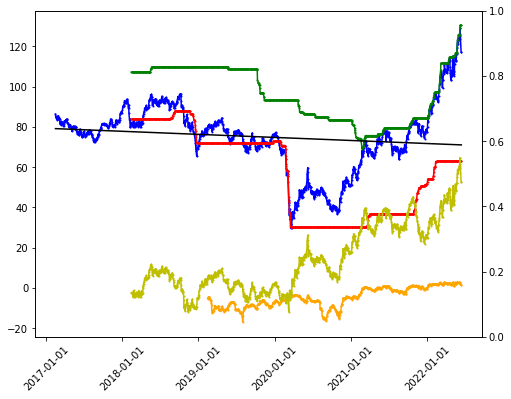

ets next 13 weeks
inner cv scores: [159.12369199654069, 159.12369203331647, 159.1236920328821, 159.1236921381809]
inner cv sdevs: [181.54981239622683, 181.54981234355023, 181.54981238173517, 181.54981243891243]
best model: ['T', 'T']
best inner cv score, sdev (11 folds): 159.12369199654069 181.54981239622683
test cv mean error, stdev (10 folds): [174.1935106323338, 183.7342484583649]
sell date: 2022-09-18
expected return: 0.09949443558493525
discounted return: 0.000998924594639794
quarter return: 1.0962060713271222


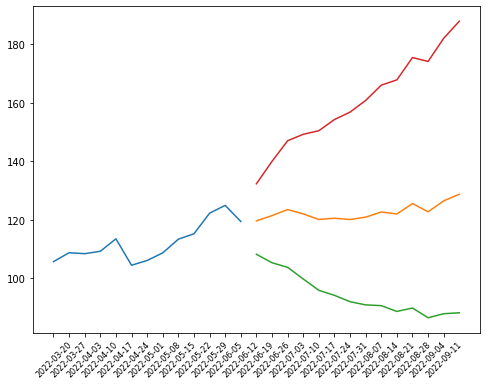

['options', ('2022-06-17',)]
symbol: VDC
sector: error
sector: Consumer Defensive
Index: nan
vol_30d_2yr: 1677598400.0
Sector 1YMF: -66.07002258300781
1YMF: 0.0028162878553055367
risk trend factor: -2.0273089620421954
      totalAssets
VDC  8.239956e+09


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-14  178.809998  178.659124  188.147461  197.635797  195.320794   

             90dSDev   90d_lower   90d_upper  
2022-06-14  7.023074  181.274647  209.366942

volume_factor    latest_p   vol_30d_2yr   pct_2yr       adf     hurst
VDC      0.002816  178.809998  1677598400.0  0.516069  0.790338  0.356259

C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


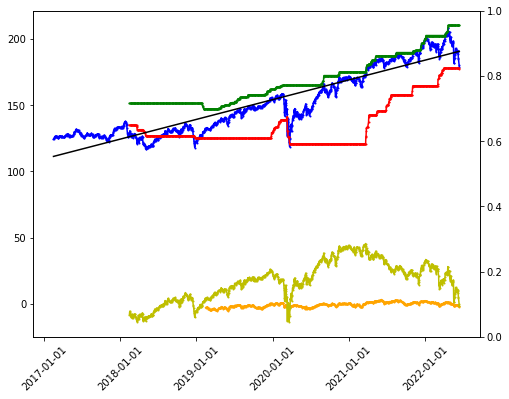

ets next 13 weeks
inner cv scores: [78.12379230339916, 78.12374333491836, 78.1237918402513, 78.12380427872517]
inner cv sdevs: [41.898262859542285, 41.8981972659733, 41.89826163735926, 41.89824319907534]
best model: ['T', 'F']
best inner cv score, sdev (11 folds): 78.12374333491836 41.8981972659733
test cv mean error, stdev (10 folds): [78.14556971924652, 43.94319756772432]
sell date: 2022-07-24
expected return: 0.042086603909973055
discounted return: 0.0010576115189662172
quarter return: 1.102134598042263


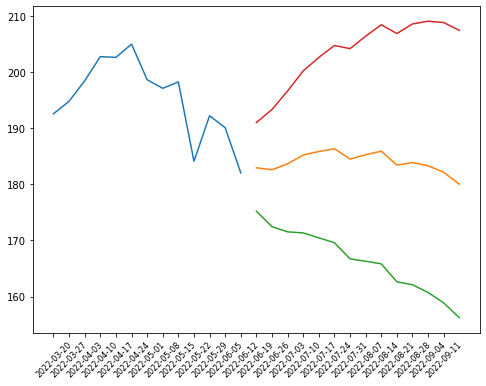

['options', ('2022-07-15',)]
symbol: VPU
sector: error
sector: Utilities
Index: nan
vol_30d_2yr: 2572686100.0
Sector 1YMF: -49.86000061035156
1YMF: 0.002030212702591272
risk trend factor: -2.0367650862888413
      totalAssets
VPU  7.799146e+09


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-14  144.529999  149.475374  158.290953  167.106531  159.121428   

             90dSDev   90d_lower   90d_upper  
2022-06-14  4.658368  149.804693  168.438164

volume_factor    latest_p   vol_30d_2yr  pct_2yr       adf     hurst
VPU       0.00203  144.529999  2572686100.0  0.51674  0.602637  0.294964

C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


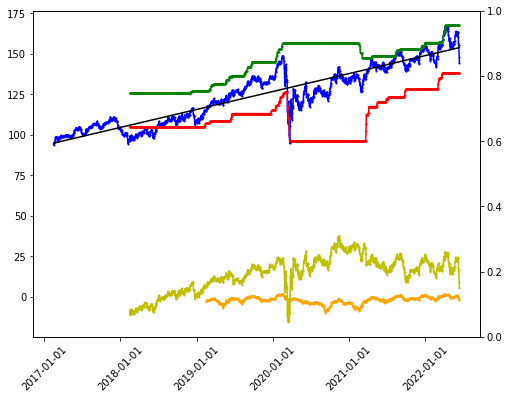

ets next 13 weeks
inner cv scores: [49.03168023764127, 49.03168018678877, 49.031678804539226, 49.03168022067991]
inner cv sdevs: [48.373685674526264, 48.37368568992851, 48.3736870768259, 48.37368568649664]
best model: ['F', 'F']
best inner cv score, sdev (11 folds): 49.031678804539226 48.3736870768259
test cv mean error, stdev (10 folds): [49.98076532987001, 50.637006471544105]
sell date: 2022-06-19
expected return: 0.045292998193906614
discounted return: 0.01113585391390437
quarter return: 2.7699692658469064


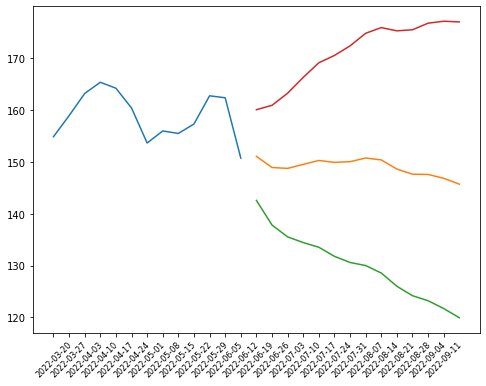

['options', ('2022-06-17',)]
symbol: VAW
sector: error
sector: Basic Materials
Index: nan
vol_30d_2yr: 1374740100.0
Sector 1YMF: -89.99998474121094
1YMF: 0.0017602599938708414
risk trend factor: -2.7264465228121475
      totalAssets
VAW  5.085875e+09


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-14  169.380005  171.785257  183.917777  196.050297  188.386984   

             90dSDev   90d_lower   90d_upper  
2022-06-14  6.915825  174.555335  202.218634

volume_factor    latest_p   vol_30d_2yr pct_2yr      adf    hurst
VAW       0.00176  169.380005  1374740100.0  0.6301  0.73357  0.42923

C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


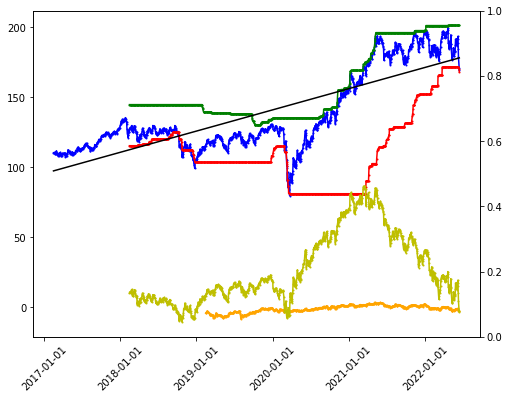

ets next 13 weeks
inner cv scores: [212.1723743013601, 212.17237472139814, 212.17231727637093, 212.1723741667365]
inner cv sdevs: [126.59214261995862, 126.59214236505552, 126.59208819743209, 126.59214272719368]
best model: ['F', 'F']
best inner cv score, sdev (11 folds): 212.17231727637093 126.59208819743209
test cv mean error, stdev (10 folds): [228.72672795234553, 120.8867830781834]
sell date: 2022-07-10
expected return: 0.050287380858997095
discounted return: 0.001964479978523004
quarter return: 1.1978818448451296


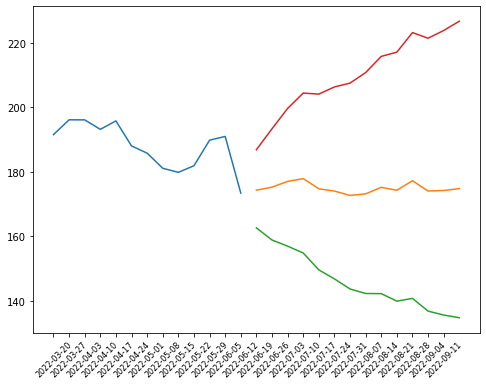

['options', ('2022-08-19',)]
symbol: VNQ
sector: error
sector: Real Estate
Index: nan
vol_30d_2yr: 52794532700.0
Sector 1YMF: -77.22999572753906
1YMF: 0.0022024174484264352
risk trend factor: -2.8838677089514886
      totalAssets
VNQ  8.281489e+10


Adj Close   21dBOLD   21dMA-TP     21dBOLU      90dSMA   90dSDev  \
2022-06-14     87.32  89.87477  96.078254  102.281738  102.636985  6.527182   

           90d_lower   90d_upper  
2022-06-14  89.58262  115.691349

volume_factor latest_p    vol_30d_2yr   pct_2yr      adf     hurst
VNQ      0.002202    87.32  52794532700.0  0.287515  0.45398  0.395523

C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


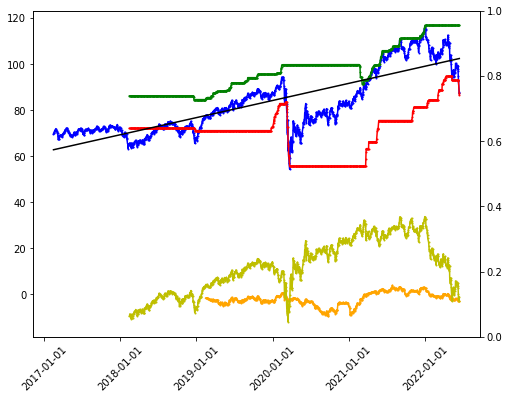

ets next 13 weeks
inner cv scores: [41.756251115882506, 41.75625167587673, 41.75625131264041, 41.75625059335419]
inner cv sdevs: [38.32586931416017, 38.32586902394019, 38.32586941101985, 38.32586950116114]
best model: ['F', 'T']
best inner cv score, sdev (11 folds): 41.75625059335419 38.32586950116114
test cv mean error, stdev (10 folds): [42.99933367958127, 39.98451798555243]
sell date: 2022-07-17
expected return: 0.04148155644509356
discounted return: 0.0012709404898285648
quarter return: 1.1239533922404303


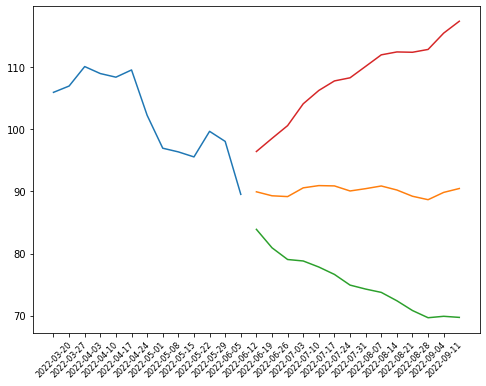

['options', ('2022-06-17', '2023-01-20', '2024-01-19')]
symbol: VHT
sector: error
sector: Healthcare
Index: nan
vol_30d_2yr: 2748002700.0
Sector 1YMF: -120.76998901367188
1YMF: 0.0022806018349254167
risk trend factor: -2.889924965769055
      totalAssets  trailingPE
VHT  1.944618e+10    5.167231


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-14  220.690002  225.697492  236.696032  247.694571  245.267301   

              90dSDev   90d_lower   90d_upper  
2022-06-14  10.459678  224.347945  266.186656

volume_factor    latest_p   vol_30d_2yr   pct_2yr       adf    hurst
VHT      0.002281  220.690002  2748002700.0  0.412621  0.648137  0.33236

C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


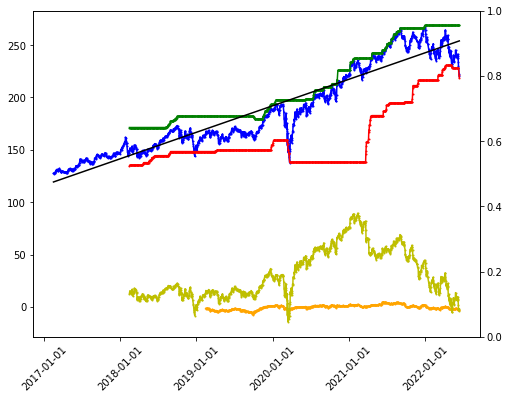

ets next 13 weeks
inner cv scores: [277.7451461581983, 277.74514641528134, 277.74514615819834, 277.7451482209096]
inner cv sdevs: [225.18617390971545, 225.18617362877762, 225.18617390971548, 225.1861792107841]
best model: ['T', 'T']
best inner cv score, sdev (11 folds): 277.7451461581983 225.18617390971545
test cv mean error, stdev (10 folds): [275.74009022599625, 236.08361573141826]
sell date: 2022-08-14
expected return: 0.04074255717420015
discounted return: 0.0006657958047198154
quarter return: 1.063146419894677


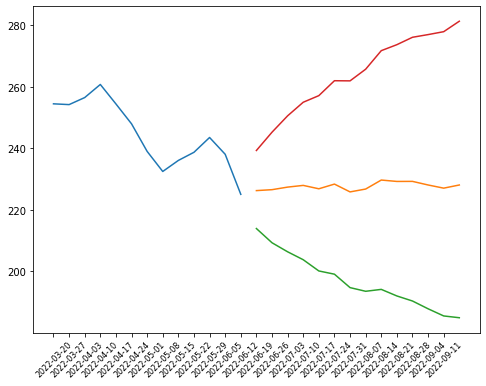

['options', ('2022-06-17',)]
symbol: VFH
sector: error
sector: Financial Services
Index: nan
vol_30d_2yr: 8469515700.0
Sector 1YMF: -69.35999298095703
1YMF: 0.002096259175716505
risk trend factor: -4.046674180329693
      totalAssets
VFH  1.055284e+10


Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14     76.82  77.599922  83.310159  89.020397  87.703016  5.254499   

            90d_lower  90d_upper  
2022-06-14  77.194017  98.212014

volume_factor latest_p   vol_30d_2yr   pct_2yr      adf     hurst
VFH      0.002096    76.82  8469515700.0  0.458719  0.51009  0.491558

C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


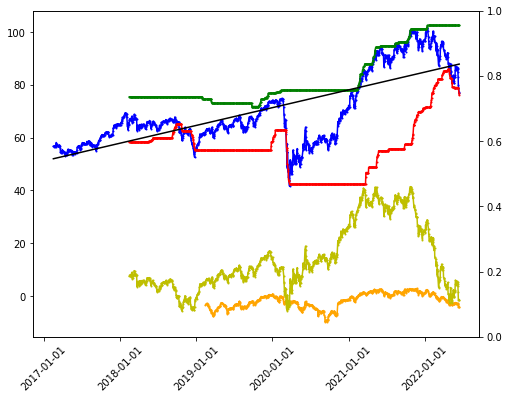

ets next 13 weeks
inner cv scores: [47.77495539390786, 47.77477717060499, 47.77495539310583, 47.774779266669796]
inner cv sdevs: [37.0613852002491, 37.0609710561574, 37.06138519880584, 37.060970467417356]
best model: ['T', 'F']
best inner cv score, sdev (11 folds): 47.77477717060499 37.0609710561574
test cv mean error, stdev (10 folds): [50.45041356796897, 37.843917916741894]
sell date: 2022-08-28
expected return: 0.03337692248609594
discounted return: 0.0004437741816722962
quarter return: 1.0416626810895997


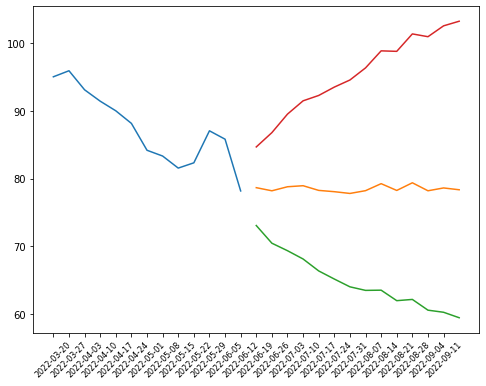

['options', ('2022-08-19',)]
symbol: VIS
sector: error
sector: Industrials
Index: nan
vol_30d_2yr: 1731436900.0
Sector 1YMF: -127.81001281738281
1YMF: 0.0013972787573142285
risk trend factor: -4.146981909279044
Empty DataFrame
Columns: []
Index: [VIS]


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-14  164.399994  164.489515  174.358095  184.226675  182.881746   

             90dSDev 90d_lower   90d_upper  
2022-06-14  9.185573  164.5106  201.252892

volume_factor    latest_p   vol_30d_2yr   pct_2yr       adf     hurst
VIS      0.001397  164.399994  1731436900.0  0.479391  0.528815  0.471381

C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


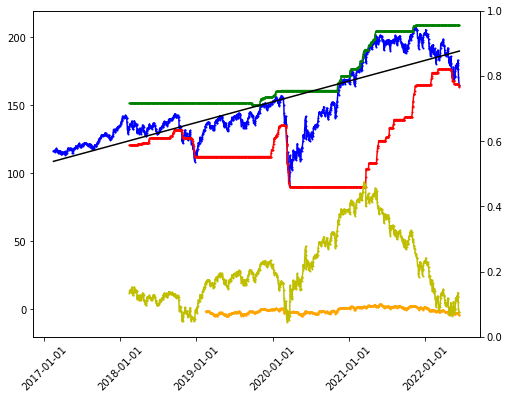

ets next 13 weeks
inner cv scores: [207.63819325037574, 207.63819516158262, 207.6381944475033, 207.63819411812776]
inner cv sdevs: [188.5332848050259, 188.5332870870547, 188.5332874889668, 188.53328464938414]
best model: ['T', 'T']
best inner cv score, sdev (11 folds): 207.63819325037574 188.5332848050259
test cv mean error, stdev (10 folds): [224.84316841469064, 189.32289107705722]
sell date: 2022-07-10
expected return: 0.02995976022883286
discounted return: 0.0011814867557888853
quarter return: 1.114752737423006


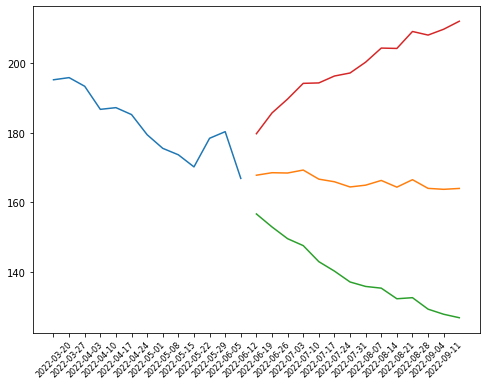

['options', ('2022-08-19',)]
symbol: VCR
sector: error
sector: Consumer Cyclical
Index: nan
vol_30d_2yr: 1325765300.0
Sector 1YMF: -352.9100036621094
1YMF: 0.0021034643160444764
risk trend factor: -4.247321632052965
      totalAssets
VCR  6.015592e+09


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-14  228.220001  224.528255  245.745873  266.963491  274.465714   

              90dSDev  90d_lower   90d_upper  
2022-06-14  26.880962  220.70379  328.227637

volume_factor    latest_p   vol_30d_2yr   pct_2yr       adf     hurst
VCR      0.002103  228.220001  1325765300.0  0.219627  0.651501  0.471679

C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


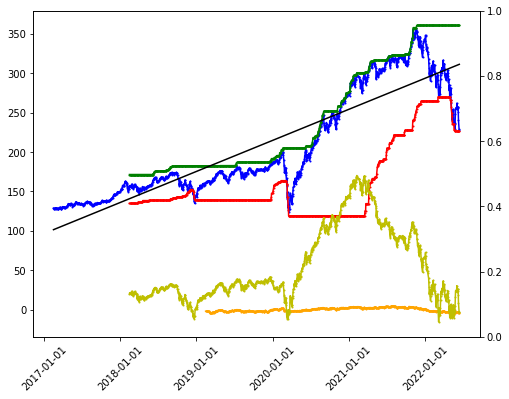

ets next 13 weeks
inner cv scores: [887.9501604558427, 887.9502091412995, 887.9502212350785, 887.9501531238255]
inner cv sdevs: [918.1708574434468, 918.1710243556035, 918.17102634911, 918.170860712812]
best model: ['F', 'T']
best inner cv score, sdev (11 folds): 887.9501531238255 918.170860712812
test cv mean error, stdev (10 folds): [969.5163536543694, 924.2069236512151]
sell date: 2022-07-24
expected return: 0.04671037183047765
discounted return: 0.001171256331887971
quarter return: 1.1137052585072091


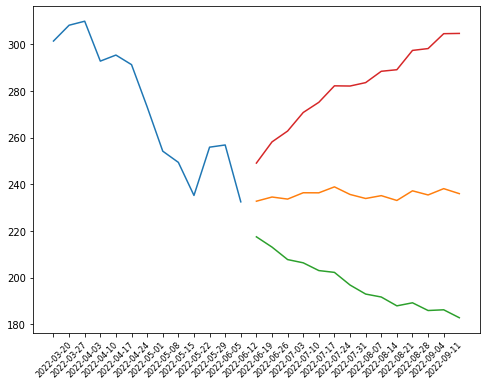

['options', ('2022-06-17',)]
symbol: VGT
sector: error
sector: Technology
Index: nan
vol_30d_2yr: 7337614600.0
Sector 1YMF: -353.0699768066406
1YMF: 0.00219037124135683
risk trend factor: -4.508044961227624
      totalAssets
VGT  5.044675e+10


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-14  323.26001  323.523724  348.914604  374.305484  375.414605   

              90dSDev   90d_lower   90d_upper  
2022-06-14  28.155127  319.104351  431.724859

volume_factor   latest_p   vol_30d_2yr   pct_2yr       adf     hurst
VGT       0.00219  323.26001  7337614600.0  0.279559  0.700663  0.427795

C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


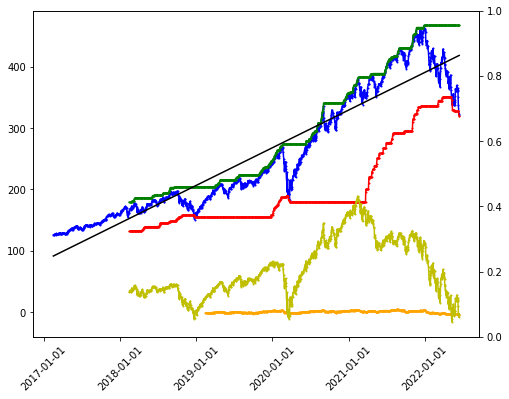

ets next 13 weeks
inner cv scores: [1125.880633382814, 1125.8229762481571, 1125.8229351078967, 1125.8230119060377]
inner cv sdevs: [1141.3577032498895, 1141.361590216077, 1141.3616404460613, 1141.3615873812503]
best model: ['F', 'F']
best inner cv score, sdev (11 folds): 1125.8229351078967 1141.3616404460613
test cv mean error, stdev (10 folds): [1191.988051865975, 1176.784160315662]
sell date: 2022-07-24
expected return: 0.04323195124407209
discounted return: 0.0010858080331990205
quarter return: 1.1049942653660179


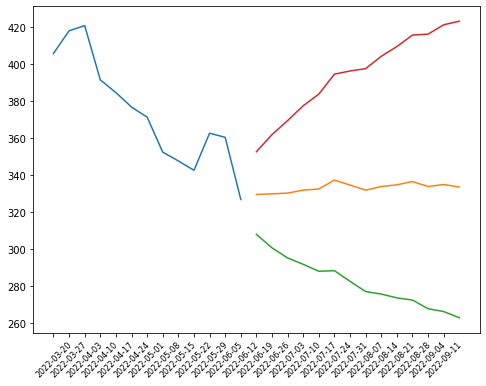

['options', ('2022-06-17', '2022-08-19')]
symbol: VOX
sector: error
sector: Communication Services
Index: nan
vol_30d_2yr: 2369729400.0
Sector 1YMF: -166.4000015258789
1YMF: 0.0030011443500679866
risk trend factor: -6.489857877273307
Empty DataFrame
Columns: []
Index: [VOX]


Adj Close    21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-14  92.730003  94.556122  100.620159  106.684195  108.598413   

             90dSDev  90d_lower   90d_upper  
2022-06-14  8.932614  90.733184  126.463641

volume_factor   latest_p   vol_30d_2yr  pct_2yr       adf     hurst
VOX      0.003001  92.730003  2369729400.0  0.05763  0.716865  0.511705

C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


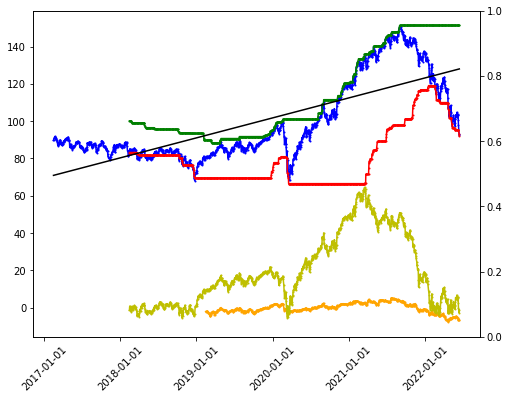

ets next 13 weeks
inner cv scores: [99.46173530143805, 99.46164781888719, 99.4616511136766, 99.4616460371224]
inner cv sdevs: [92.64433422592688, 92.6443665612294, 92.64437259414846, 92.64436860691903]
best model: ['F', 'T']
best inner cv score, sdev (11 folds): 99.4616460371224 92.64436860691903
test cv mean error, stdev (10 folds): [106.36093060200218, 94.43344422898768]
sell date: 2022-09-11
expected return: 0.062358399468594755
discounted return: 0.0006876379265265964
quarter return: 1.0652834865496712


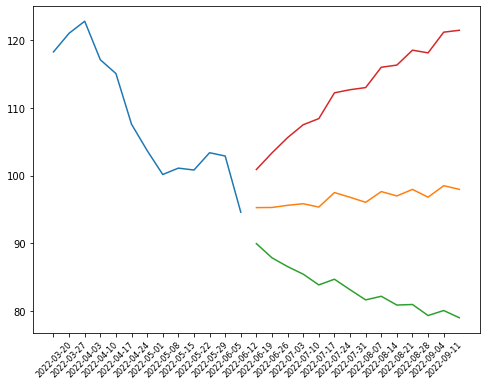

['options', ('2022-07-15',)]
symbol: ACC
sector: error
sector: error
Index: SP400
vol_30d_2yr: 13781055000.0
Sector 1YMF: 20.369998931884766
1YMF: 0.004415184468823323
risk trend factor: 19.217024385328497
Empty DataFrame
Columns: []
Index: [ACC]


Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14  64.419998  64.395295  64.757143  65.118991  61.641746  4.162777   

            90d_lower  90d_upper  
2022-06-14  53.316192  69.967301

volume_factor   latest_p    vol_30d_2yr   pct_2yr       adf     hurst
ACC      0.004415  64.419998  13781055000.0  0.976574  0.979637  0.418255

Index 1YMF: -63.869998931884766
Index Volume Factor: 0.0011014613124698796
Index Risk Trend Factor: -4.591660649354175


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


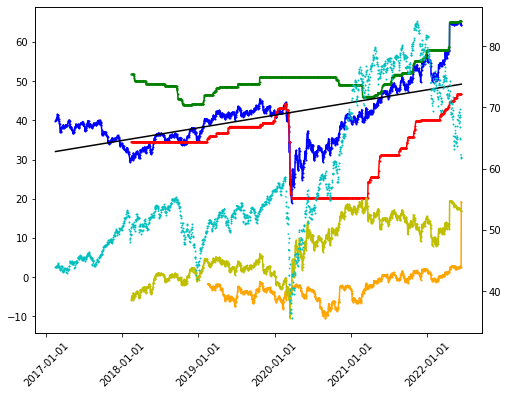

ets next 13 weeks
inner cv scores: [17.384967300438674, 17.38496741224909, 17.38496741224909, 17.384968377006693]
inner cv sdevs: [12.106773591116221, 12.106773615356733, 12.106773615356733, 12.106773832025187]
best model: ['T', 'T']
best inner cv score, sdev (11 folds): 17.384967300438674 12.106773591116221
test cv mean error, stdev (10 folds): [18.106530539963796, 12.470131423085485]
sell date: 2022-07-17
expected return: 0.02634446503992094
discounted return: 0.0008129373267091733
quarter return: 1.0776253287707782


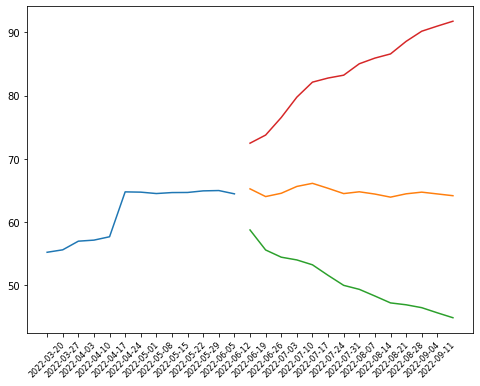

['options', ('2022-06-17',)]
symbol: MTOR
sector: Consumer Cyclical
Index: SP600
vol_30d_2yr: 7888381900.0
Sector 1YMF: 2.549999237060547
1YMF: 0.003133037968154153
risk trend factor: 5.543487635380559
          beta currentRatio debtToEquity earningsGrowth     ebitda  \
MTOR  1.754411        1.434      172.571          0.727  339000000   

     ebitdaMargins forwardPE freeCashflow grossMargins grossProfits  \
MTOR        0.0863  8.103372     57375000      0.13162    505000000   

     heldPercentInstitutions    industry   marketCap operatingCashflow  \
MTOR                 0.95489  Auto Parts  2526940672         132000000   

     operatingMargins payoutRatio pegRatio priceToBook  \
MTOR          0.06059           0     0.46    4.404006   

     priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
MTOR                     0.643315       0.05626      0.682        0.04977   

     returnOnEquity revenueGrowth revenuePerShare             sector  \
MTOR        0.39069  

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14      36.0  35.938587  36.097143  36.255698  35.866508  0.249917   

            90d_lower  90d_upper  
2022-06-14  35.366673  36.366342

volume_factor latest_p   vol_30d_2yr   pct_2yr       adf     hurst
MTOR      0.003133     36.0  7888381900.0  0.983462  0.304331  0.434725

Sector 1YMF: -352.9100036621094
Sector Volume Factor: 0.0021034643160444764
Sector Risk Trend Factor: -4.247321632052965
Index 1YMF: -69.3499984741211
Index Volume Factor: 0.0022254315395940014
Index Risk Trend Factor: -4.866666559587445


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


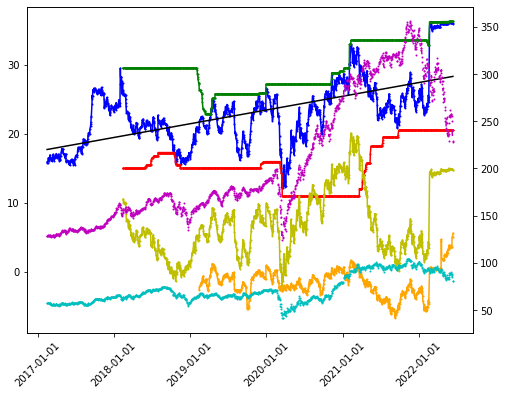

ets next 13 weeks
inner cv scores: [15.364658655428217, 15.364658674848744, 15.364658672298736, 15.36465865547079]
inner cv sdevs: [8.761209278344097, 8.761209272512293, 8.761209274259965, 8.761209282232448]
best model: ['T', 'T']
best inner cv score, sdev (11 folds): 15.364658655428217 8.761209278344097
test cv mean error, stdev (10 folds): [14.849095111304726, 9.028333362677202]
sell date: 2022-07-10
expected return: 0.017131949015148844
discounted return: 0.000679704975934392
quarter return: 1.064506823586518


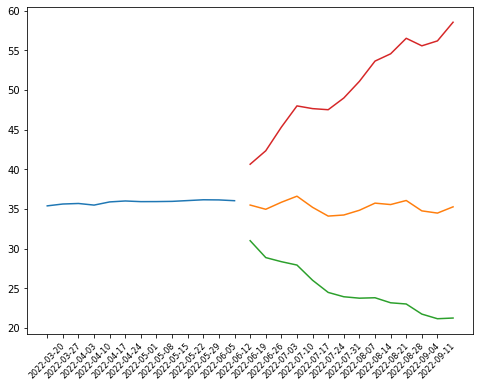

['quarterly_balance_sheet',                                     2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus                   7.610000e+08  7.980000e+08  7.920000e+08   
Total Liab                        2.409000e+09  2.323000e+09  2.390000e+09   
Total Stockholder Equity          5.970000e+08  5.740000e+08  6.160000e+08   
Minority Interest                 4.100000e+07  4.100000e+07  3.900000e+07   
Other Current Liab                1.920000e+08  1.700000e+08  1.670000e+08   
Total Assets                      3.047000e+09  2.938000e+09  3.045000e+09   
Common Stock                      1.060000e+08  1.050000e+08  1.060000e+08   
Other Current Assets              6.900000e+07  5.000000e+07  6.100000e+07   
Retained Earnings                 1.006000e+09  9.350000e+08  8.730000e+08   
Other Liab                        4.030000e+08  3.620000e+08  4.390000e+08   
Good Will                         5.070000e+08  5.070000e+08  5.100000e+08   
Treasury Stock                   -1.

Adj Close    21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-14     832.0  831.66739  833.556348  835.445307  831.194443   

              90dSDev   90d_lower   90d_upper  
2022-06-14  35.950757  759.292929  903.095958

volume_factor latest_p  vol_30d_2yr   pct_2yr      adf     hurst
Y      0.002892    832.0  828602100.0  0.923264  0.38518  0.458449

Sector 1YMF: -69.35999298095703
Sector Volume Factor: 0.002096259175716505
Sector Risk Trend Factor: -4.046674180329693
Index 1YMF: -63.869998931884766
Index Volume Factor: 0.0011014613124698796
Index Risk Trend Factor: -4.591660649354175


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


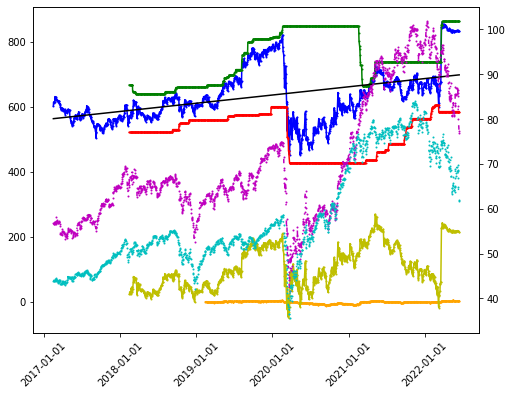

ets next 13 weeks
inner cv scores: [5884.238223314144, 5884.237419037489, 5884.238218770723, 5884.237405846029]
inner cv sdevs: [9840.888695359496, 9840.88623569527, 9840.888696951211, 9840.886240663112]
best model: ['F', 'T']
best inner cv score, sdev (11 folds): 5884.237405846029 9840.886240663112
test cv mean error, stdev (10 folds): [6331.714206801712, 10213.949082642846]
sell date: 2022-08-07
expected return: 0.030869624492332
discounted return: 0.0005738011958289491
quarter return: 1.0541919722649558


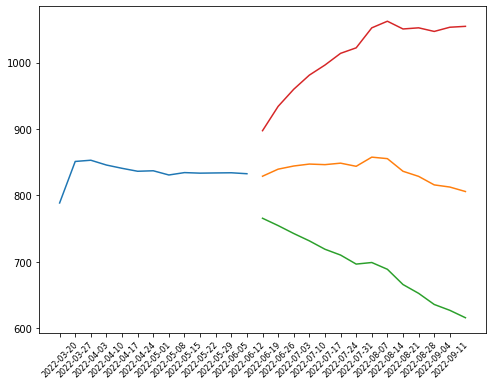

['quarterly_balance_sheet',                              2021-12-31    2021-09-30    2021-06-30  \
Intangible Assets          1.511159e+09  1.465825e+09  1.453498e+09   
Capital Surplus            3.608905e+09  3.611383e+09  3.612783e+09   
Total Liab                 2.276445e+10  2.274715e+10  2.110891e+10   
Total Stockholder Equity   9.186882e+09  8.859510e+09  9.142031e+09   
Minority Interest          3.173460e+08  2.625260e+08  2.407220e+08   
Other Current Liab         3.213810e+09  3.516756e+09  3.335249e+09   
Total Assets               3.226868e+10  3.186919e+10  3.049166e+10   
Common Stock               1.746000e+07  1.746000e+07  1.746000e+07   
Other Current Assets       2.283585e+09  2.282419e+09  1.959696e+09   
Retained Earnings          7.353226e+09  6.837060e+09  6.952026e+09   
Other Liab                 1.156344e+10  1.634516e+10  1.541578e+10   
Good Will                  7.536070e+08  6.318270e+08  6.276120e+08   
Treasury Stock            -1.792709e+09 -1.606393

Adj Close    21dBOLD  21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14     19.15  16.177578  17.96746  19.757342  15.764603  1.880329   

            90d_lower  90d_upper  
2022-06-14  12.003945  19.525262

volume_factor latest_p   vol_30d_2yr   pct_2yr       adf     hurst
TWI      0.002554    19.15  5400736000.0  0.972343  0.891295  0.499041

Sector 1YMF: -127.81001281738281
Sector Volume Factor: 0.0013972787573142285
Sector Risk Trend Factor: -4.146981909279044
Index 1YMF: -69.3499984741211
Index Volume Factor: 0.0022254315395940014
Index Risk Trend Factor: -4.866666559587445


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


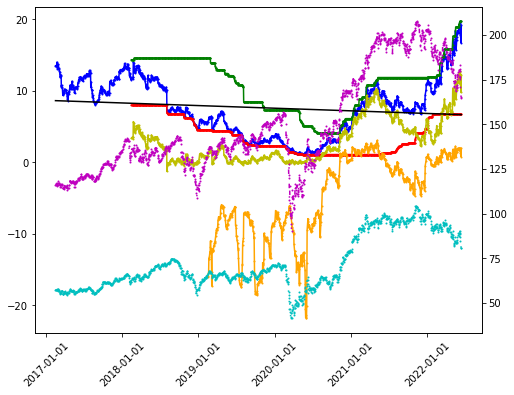

ets next 13 weeks
inner cv scores: [4.844630465458022, 4.844630597686336, 4.844526133674592, 4.844549970490171]
inner cv sdevs: [8.077163918116325, 8.07715974090879, 8.077209819761267, 8.07720577585918]
best model: ['F', 'F']
best inner cv score, sdev (11 folds): 4.844526133674592 8.077209819761267
test cv mean error, stdev (10 folds): [5.31845447309697, 8.324357872757824]
sell date: 2022-09-18
expected return: 0.06548231166691564
discounted return: 0.0006678815804794791
quarter return: 1.0633503121163144


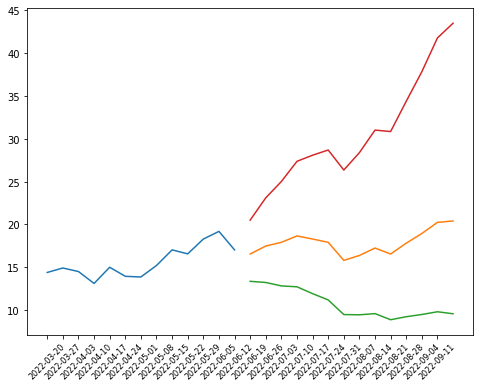

['options', ('2022-07-15',)]
symbol: PBF
sector: Energy
Index: SP600
vol_30d_2yr: 47517805800.0
Sector 1YMF: 37.8799934387207
1YMF: 0.0014413607456596827
risk trend factor: 1.9083121587190919
         beta currentRatio debtToEquity     ebitda ebitdaMargins forwardPE  \
PBF  2.581372        1.254      197.914  690400000       0.02194    93.975   

    freeCashflow grossMargins grossProfits heldPercentInstitutions  \
PBF    284750016       0.0362    671100000                 0.79091   

                           industry   marketCap operatingCashflow  \
PBF  Oil & Gas Refining & Marketing  4520047104         803299968   

    operatingMargins payoutRatio pegRatio priceToBook  \
PBF           0.0135           0    -0.22    2.613866   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
PBF                     0.143629       0.00798      0.629        0.02192   

    returnOnEquity revenueGrowth revenuePerShare  sector sharesOutstanding  \
PBF        0.14223       

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14  38.919998  26.021817  35.020635  44.019453  29.266032  5.552078   

            90d_lower  90d_upper  
2022-06-14  18.161876  40.370187

volume_factor   latest_p    vol_30d_2yr   pct_2yr       adf     hurst
PBF      0.001441  38.919998  47517805800.0  0.870195  0.699548  0.555964

Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -69.3499984741211
Index Volume Factor: 0.0022254315395940014
Index Risk Trend Factor: -4.866666559587445


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


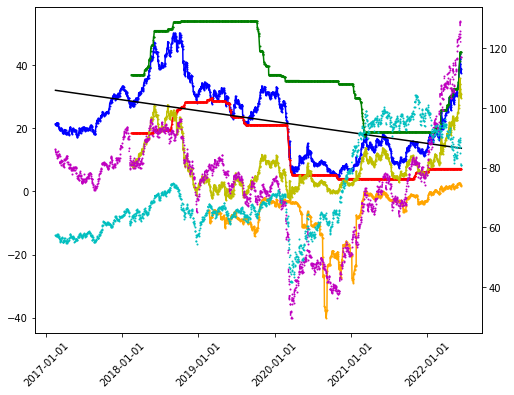

ets next 13 weeks
inner cv scores: [25.31686564007184, 25.31687099553441, 25.31686493308238, 25.31686564480558]
inner cv sdevs: [23.57488872656242, 23.574895534726664, 23.574889215724816, 23.574888752834987]
best model: ['F', 'F']
best inner cv score, sdev (11 folds): 25.31686493308238 23.574889215724816
test cv mean error, stdev (10 folds): [22.654817370162995, 23.095484515235285]


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\exponential_smoothing.py:348: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[0])) * (high - low) + low)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\exponential_smoothing.py:356: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[i])) * (high - low) + low)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\exponential_smoothing.py:364: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[i])) * (high - low) + low)


sell date: 2022-07-24
expected return: 0.04879362370363711
discounted return: 0.0012222995752930732
quarter return: 1.1189412124172486


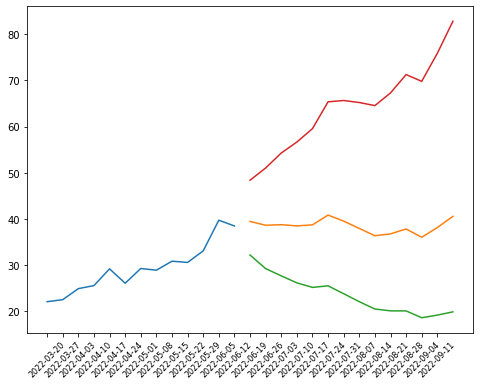

['quarterly_balance_sheet',                              2022-03-31    2021-12-31    2021-09-30  \
Capital Surplus            2.882000e+09  2.874000e+09  2.868000e+09   
Total Liab                 1.042220e+10  9.108600e+09  9.522100e+09   
Total Stockholder Equity   1.911000e+09  1.926200e+09  1.729200e+09   
Minority Interest          6.151000e+08  6.066000e+08  5.929000e+08   
Other Current Liab         1.544200e+09  1.345900e+09  1.676400e+09   
Total Assets               1.294830e+10  1.164140e+10  1.184420e+10   
Common Stock               1.000000e+05  1.000000e+05  1.000000e+05   
Other Current Assets       5.190000e+07  1.200000e+07           NaN   
Retained Earnings         -8.172000e+08 -7.961000e+08 -9.614000e+08   
Other Liab                 4.486000e+08  4.121000e+08  3.574000e+08   
Treasury Stock            -1.539000e+08 -1.518000e+08 -1.775000e+08   
Other Assets               8.938000e+08  8.133000e+08  7.915000e+08   
Cash                       1.434600e+09  1.341500

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-14  207.410004  183.440635  196.337143  209.233652  189.885873   

             90dSDev   90d_lower   90d_upper  
2022-06-14  6.962494  175.960885  203.810861

volume_factor    latest_p   vol_30d_2yr   pct_2yr       adf     hurst
SAFM      0.002313  207.410004  2596619200.0  0.990282  0.669942  0.477196

Sector 1YMF: -66.07002258300781
Sector Volume Factor: 0.0028162878553055367
Sector Risk Trend Factor: -2.0273089620421954
Index 1YMF: -63.869998931884766
Index Volume Factor: 0.0011014613124698796
Index Risk Trend Factor: -4.591660649354175


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


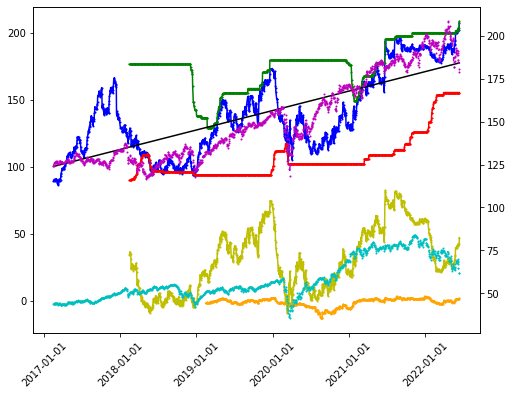

ets next 13 weeks
inner cv scores: [301.8694480871505, 301.8694413630348, 301.8694431496199, 301.8694456201761]
inner cv sdevs: [367.5235659625113, 367.5235679827517, 367.5235675369362, 367.5235641897937]
best model: ['T', 'F']
best inner cv score, sdev (11 folds): 301.8694413630348 367.5235679827517
test cv mean error, stdev (10 folds): [325.35586650347346, 377.5092038977911]
sell date: 2022-07-10
expected return: 0.02764576524364591
discounted return: 0.0010914160138748574
quarter return: 1.105563896548965


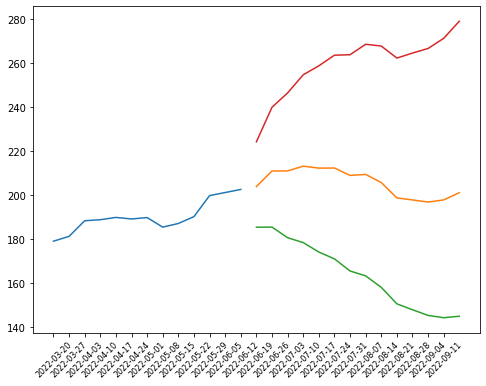

['options', ('2022-08-19', '2022-12-16')]
symbol: MPC
sector: Energy
Index: SP500
vol_30d_2yr: 72756266000.0
Sector 1YMF: 56.91999816894531
1YMF: 0.0018767029632884129
risk trend factor: 1.7364246579806077
         beta currentRatio debtToEquity dividendRate dividendYield  \
MPC  1.910294        1.704       80.117         2.32        0.0242   

    earningsGrowth      ebitda ebitdaMargins forwardPE freeCashflow  \
MPC          1.917  7120999936       0.05912  23.43602  16415250432   

    grossMargins grossProfits heldPercentInstitutions  \
MPC       0.0867  10443000000                 0.82037   

                           industry    marketCap operatingCashflow  \
MPC  Oil & Gas Refining & Marketing  60881649664        4360000000   

    operatingMargins payoutRatio pegRatio priceToBook  \
MPC          0.03119      0.5472     0.55    2.175252   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
MPC                     0.505447       0.08085      1.222      

Adj Close    21dBOLD    21dMA-TP     21dBOLU     90dSMA  \
2022-06-14  102.669998  91.287088  102.474286  113.661483  91.610984   

             90dSDev  90d_lower   90d_upper  
2022-06-14  9.404473  72.802038  110.419931

volume_factor    latest_p    vol_30d_2yr   pct_2yr       adf     hurst
MPC      0.001877  102.669998  72756266000.0  0.866955  0.977688  0.523103

Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -263.8100280761719
Index Volume Factor: 0.0022075805827187875
Index Risk Trend Factor: -3.321707170400029


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


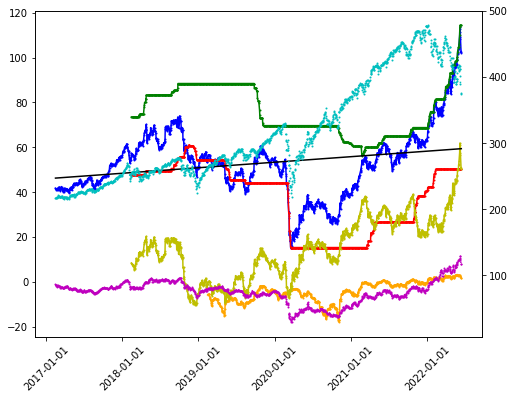

ets next 13 weeks
inner cv scores: [131.65140460881426, 131.65140413332375, 131.65140440044064, 131.65053612536832]
inner cv sdevs: [179.62199064827453, 179.621989816526, 179.62199075696446, 179.62004357125272]
best model: ['F', 'T']
best inner cv score, sdev (11 folds): 131.65053612536832 179.62004357125272
test cv mean error, stdev (10 folds): [140.5948091624812, 186.0393391719661]
sell date: 2022-08-28
expected return: 0.03379650654177166
discounted return: 0.00044926243591159043
quarter return: 1.0421885347175452


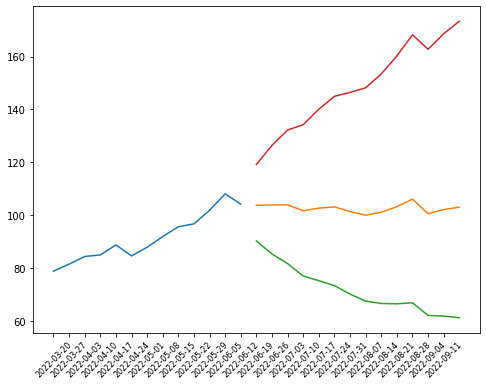

['quarterly_balance_sheet',                                     2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus                   3.326200e+10  3.325600e+10  3.323800e+10   
Total Liab                        5.179200e+10  5.333600e+10  5.760700e+10   
Total Stockholder Equity          2.620600e+10  2.828000e+10  2.892100e+10   
Minority Interest                 7.375000e+09  7.684000e+09  7.772000e+09   
Other Current Liab                2.278000e+09  3.377000e+09  6.148000e+09   
Total Assets                      8.537300e+10  8.930000e+10  9.430000e+10   
Common Stock                      1.000000e+07  1.000000e+07  1.000000e+07   
Other Current Assets              5.680000e+08  5.850000e+08  5.850000e+08   
Retained Earnings                 1.290500e+10  1.248400e+10  1.216000e+10   
Other Liab                        7.999000e+09  8.193000e+09  8.825000e+09   
Good Will                         8.256000e+09  8.256000e+09  8.256000e+09   
Treasury Stock                   -1.

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14  70.589996  67.376962  73.555238  79.733514  65.418095  6.714301   

            90d_lower  90d_upper  
2022-06-14  51.989493  78.846697

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
DVN      0.001961  70.589996  121752263500.0  0.877075  0.988553  0.552856

Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -263.8100280761719
Index Volume Factor: 0.0022075805827187875
Index Risk Trend Factor: -3.321707170400029


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


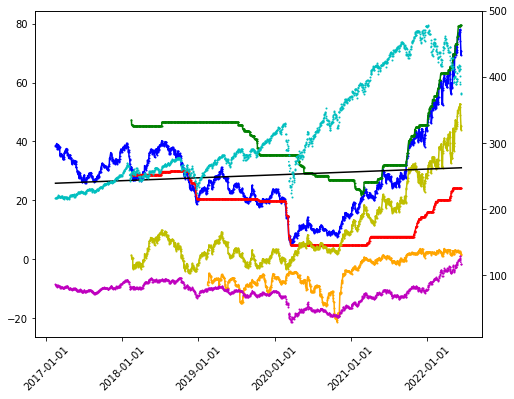

ets next 13 weeks
inner cv scores: [72.45773206347532, 72.45773270555088, 72.45773206278174, 72.45773206246297]
inner cv sdevs: [107.35588927580905, 107.35589112807962, 107.35588927630698, 107.35588927605704]
best model: ['F', 'T']
best inner cv score, sdev (11 folds): 72.45773206246297 107.35588927605704
test cv mean error, stdev (10 folds): [79.15100023628148, 110.38576884398293]
sell date: 2022-09-18
expected return: 0.0975423634225949
discounted return: 0.000980200768888162
quarter return: 1.094321244565625


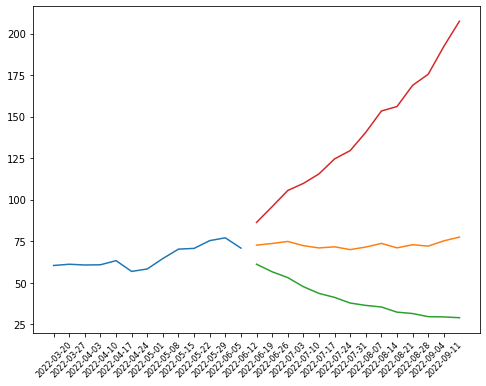

['options', ('2022-07-15', '2023-01-20', '2024-01-19')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                           8.78
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                         0
peerCount                               66
governanceScore                       7.86
environmentPercentile                    0
animalTesting                        False
tobacco                              False
totalEsg                             34.39
highestControversy                       2
esgPerformance                   LEAD_PERF
coal                                 False
pesticides            

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-14    133.75  118.374391  131.868413  145.362434  114.833016   

             90dSDev  90d_lower   90d_upper  
2022-06-14  15.68235  83.468316  146.197716

volume_factor latest_p    vol_30d_2yr   pct_2yr       adf     hurst
VLO       0.00229   133.75  46297639500.0  0.882733  0.922874  0.537334

Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -263.8100280761719
Index Volume Factor: 0.0022075805827187875
Index Risk Trend Factor: -3.321707170400029


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


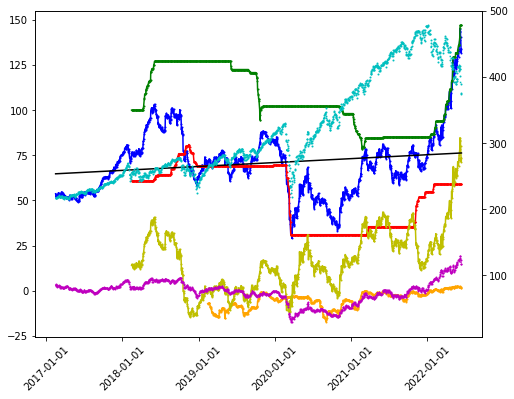

ets next 13 weeks
inner cv scores: [257.7262983647111, 257.72629846446995, 257.72629841987816, 257.7262983647111]
inner cv sdevs: [325.6413838220487, 325.64138377693934, 325.64138378699107, 325.6413838220486]
best model: ['T', 'T']
best inner cv score, sdev (11 folds): 257.7262983647111 325.6413838220487
test cv mean error, stdev (10 folds): [275.4331745013099, 336.4486199287141]
sell date: 2022-09-18
expected return: 0.060260080517683896
discounted return: 0.0006161290665045449
quarter return: 1.058302721823071


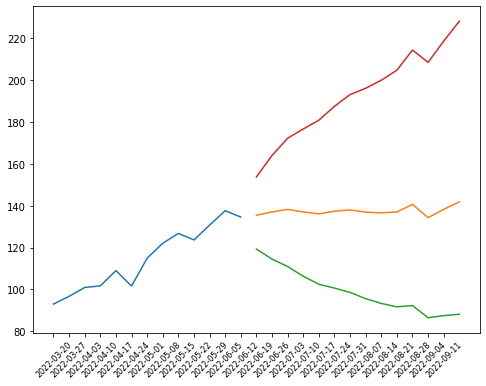

['options', ('2022-06-17', '2023-01-20', '2024-01-19')]
['sustainability',                                       Value
2022-5                                     
palmOil                               False
controversialWeapons                  False
gambling                              False
socialScore                            7.23
nuclear                               False
furLeather                            False
alcoholic                             False
gmo                                   False
catholic                              False
socialPercentile                       None
peerCount                                39
governanceScore                        4.98
environmentPercentile                  None
animalTesting                         False
tobacco                               False
totalEsg                              30.94
highestControversy                        3
esgPerformance                     OUT_PERF
coal                                  False
p

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-14  111.489998  101.783141  112.579841  123.376542  104.161111   

             90dSDev  90d_lower   90d_upper  
2022-06-14  7.447975  89.265162  119.057061

volume_factor    latest_p    vol_30d_2yr   pct_2yr       adf     hurst
COP      0.001647  111.489998  96861604200.0  0.869601  0.980711  0.490397

Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -263.8100280761719
Index Volume Factor: 0.0022075805827187875
Index Risk Trend Factor: -3.321707170400029


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


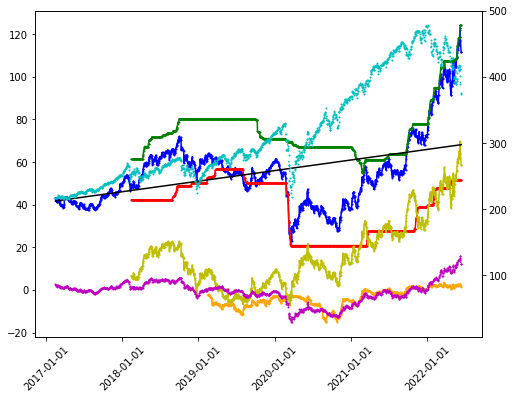

ets next 13 weeks
inner cv scores: [142.66282142500023, 142.66282125088935, 142.66282139000796, 142.662821406029]
inner cv sdevs: [159.52917913729667, 159.52917896274553, 159.5291789832317, 159.5291791316207]
best model: ['T', 'F']
best inner cv score, sdev (11 folds): 142.66282125088935 159.52917896274553
test cv mean error, stdev (10 folds): [156.2099386481347, 161.16993079080987]
sell date: 2022-09-18
expected return: 0.07326279381718037
discounted return: 0.0007445227952111999
quarter return: 1.0708691530958148


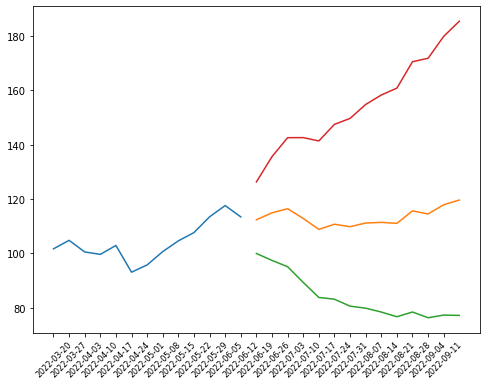

['options', ('2022-08-19', '2023-01-20', '2024-01-19')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                           9.71
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                       7.68
environmentPercentile                 None
animalTesting                        False
tobacco                              False
totalEsg                             34.92
highestControversy                       2
esgPerformance                    OUT_PERF
coal                                 False
pesticides            

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14  62.580002  59.930496  66.714857  73.499217  61.429841  5.416784   

            90d_lower 90d_upper  
2022-06-14  50.596273  72.26341

volume_factor   latest_p   vol_30d_2yr   pct_2yr      adf     hurst
LNTH      0.003397  62.580002  7190737100.0  0.822953  0.98634  0.532554

Sector 1YMF: -120.76998901367188
Sector Volume Factor: 0.0022806018349254167
Sector Risk Trend Factor: -2.889924965769055
Index 1YMF: -69.3499984741211
Index Volume Factor: 0.0022254315395940014
Index Risk Trend Factor: -4.866666559587445


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


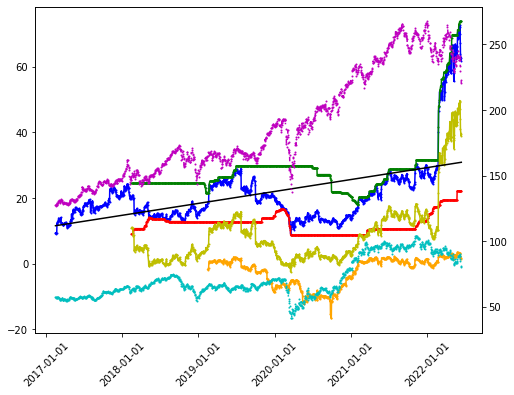

ets next 13 weeks
inner cv scores: [41.47571884662523, 41.47571808695382, 41.47571711948716, 41.47571867786617]
inner cv sdevs: [60.17941329621828, 60.17941093965518, 60.17941238182742, 60.17941282730593]
best model: ['F', 'F']
best inner cv score, sdev (11 folds): 41.47571711948716 60.17941238182742
test cv mean error, stdev (10 folds): [42.46377726297496, 63.031572318563285]
sell date: 2022-09-18
expected return: 0.2345017785138825
discounted return: 0.0022200129084550824
quarter return: 1.226316319376961


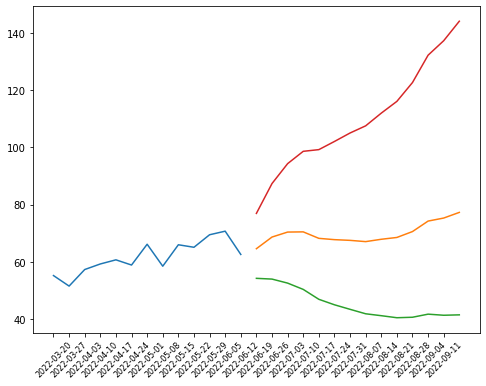

['options', ('2022-07-15',)]
symbol: MRO
sector: Energy
Index: SP500
vol_30d_2yr: 252220800100.0
Sector 1YMF: 16.26000213623047
1YMF: 0.0017287471922503032
risk trend factor: 1.5649663240109462
         beta currentRatio debtToEquity dividendRate dividendYield  \
MRO  2.766666        1.112        38.48         0.32        0.0119   

         ebitda ebitdaMargins  forwardPE freeCashflow grossMargins  \
MRO  3308999936       0.58921  14.321428   1785500032      0.77546   

    grossProfits heldPercentInstitutions       industry    marketCap  \
MRO   4355000000                   0.802  Oil & Gas E&P  21853534208   

    operatingCashflow operatingMargins payoutRatio pegRatio priceToBook  \
MRO        3239000064          0.20495      0.0769     0.59    2.051451   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
MRO                     3.891299       0.16845      1.052        0.04117   

    returnOnEquity revenueGrowth revenuePerShare  sector sharesOutstanding 

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14  28.790001  26.107532  29.696984  33.286436  26.793597  2.531289   

            90d_lower  90d_upper  
2022-06-14  21.731019  31.856176

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
MRO      0.001729  28.790001  252220800100.0  0.849204  0.948885  0.544141

Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -263.8100280761719
Index Volume Factor: 0.0022075805827187875
Index Risk Trend Factor: -3.321707170400029


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


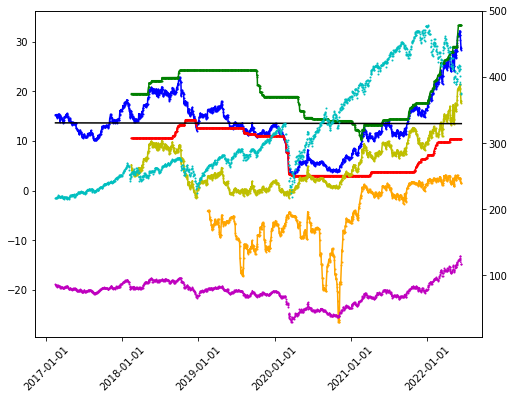

ets next 13 weeks
inner cv scores: [12.317458407807123, 12.317458404973321, 12.317458410406248, 12.317458383180918]
inner cv sdevs: [17.508607401612696, 17.508607402408582, 17.508607400987618, 17.50860741582898]
best model: ['F', 'T']
best inner cv score, sdev (11 folds): 12.317458383180918 17.50860741582898
test cv mean error, stdev (10 folds): [13.299649960609571, 18.07193303764845]
sell date: 2022-09-18
expected return: 0.1419256804340833
discounted return: 0.0013979871235636487
quarter return: 1.137149847565985


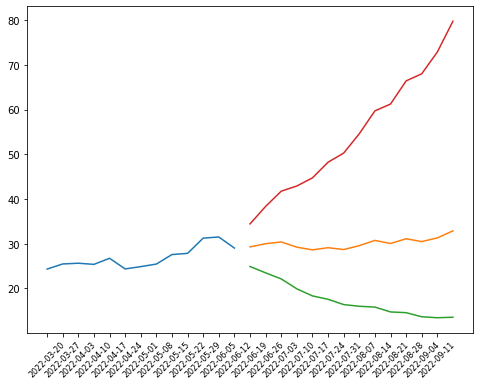

['quarterly_balance_sheet',                              2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus            7.221000e+09  7.213000e+09  7.201000e+09   
Total Liab                 6.308000e+09  6.365000e+09  7.166000e+09   
Total Stockholder Equity   1.068600e+10  1.079600e+10  1.063400e+10   
Other Current Liab         3.680000e+08  4.960000e+08  5.020000e+08   
Total Assets               1.699400e+10  1.716100e+10  1.780000e+10   
Common Stock               9.370000e+08  9.370000e+08  9.370000e+08   
Other Current Assets       2.200000e+07  2.500000e+07  1.900000e+07   
Retained Earnings          7.271000e+09  6.669000e+09  6.524000e+09   
Other Liab                 6.440000e+08  6.420000e+08  6.650000e+08   
Treasury Stock            -4.743000e+09 -4.023000e+09 -4.028000e+09   
Other Assets               1.100000e+08  1.040000e+08  9.300000e+07   
Cash                       5.800000e+08  4.850000e+08  9.700000e+08   
Total Current Liabilities  1.637000e+09  1.676000

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA  90dSDev  \
2022-06-14      46.0  39.761978  46.000952  52.239927  42.767936  3.39058   

            90d_lower  90d_upper  
2022-06-14  35.986776  49.549097

volume_factor latest_p     vol_30d_2yr   pct_2yr       adf     hurst
APA      0.001859     46.0  105341198700.0  0.866292  0.413628  0.447575

Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -263.8100280761719
Index Volume Factor: 0.0022075805827187875
Index Risk Trend Factor: -3.321707170400029


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


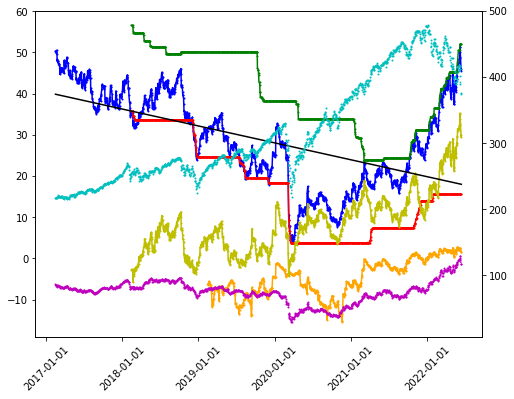

ets next 13 weeks
inner cv scores: [36.429421833060225, 36.429421799205734, 36.42942183722904, 36.4294218355459]
inner cv sdevs: [45.103085849758756, 45.10308576480753, 45.10308584972008, 45.10308584704238]
best model: ['T', 'F']
best inner cv score, sdev (11 folds): 36.429421799205734 45.10308576480753
test cv mean error, stdev (10 folds): [39.791599274418246, 45.97141046196568]
sell date: 2022-07-03
expected return: 0.14608942044497636
discounted return: 0.0076040788081128685
quarter return: 2.007577647633649


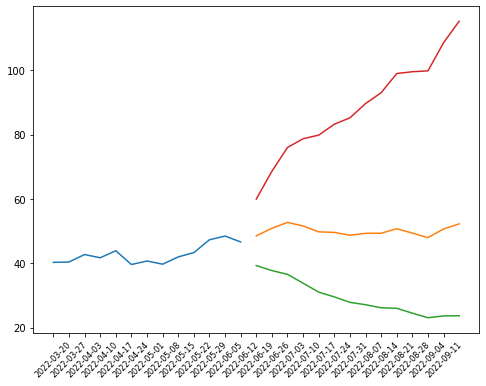

['quarterly_balance_sheet',                                     2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus                   1.164500e+10  1.168600e+10  1.170400e+10   
Total Liab                        1.330800e+10  1.270500e+10  1.281900e+10   
Total Stockholder Equity         -1.595000e+09 -1.095000e+09 -9.640000e+08   
Minority Interest                 1.590000e+09  1.580000e+09  1.657000e+09   
Deferred Long Term Liab           5.700000e+08  5.150000e+08  5.120000e+08   
Other Current Liab                3.370000e+08  2.760000e+08  2.990000e+08   
Total Assets                      1.330300e+10  1.331000e+10  1.351200e+10   
Common Stock                      2.620000e+08  2.620000e+08  2.620000e+08   
Other Current Assets              1.550000e+08  1.020000e+08  7.600000e+07   
Retained Earnings                -9.488000e+09 -9.870000e+09 -9.757000e+09   
Other Liab                        3.744000e+09  3.673000e+09  2.626000e+09   
Treasury Stock                   -4.

Adj Close    21dBOLD   21dMA-TP     21dBOLU     90dSMA   90dSDev  \
2022-06-14  96.099998  88.636597  96.527143  104.417688  88.279133  6.843087   

            90d_lower   90d_upper  
2022-06-14  74.592959  101.965306

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
XOM      0.002061  96.099998  282584082100.0  0.872818  0.958139  0.535838

Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -263.8100280761719
Index Volume Factor: 0.0022075805827187875
Index Risk Trend Factor: -3.321707170400029


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


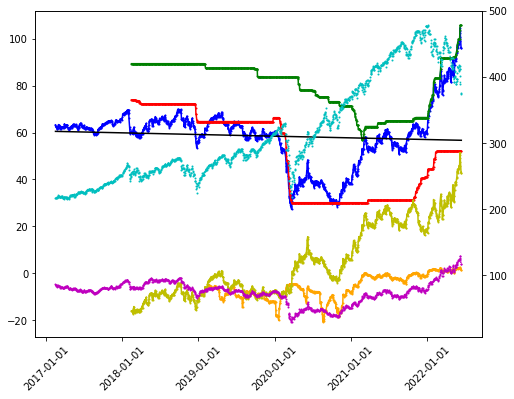

ets next 13 weeks
inner cv scores: [103.87700682186569, 103.87700686349449, 103.87679704529982, 103.87700674846839]
inner cv sdevs: [112.52048911380237, 112.5204891506597, 112.51998151928628, 112.5204891289752]
best model: ['F', 'F']
best inner cv score, sdev (11 folds): 103.87679704529982 112.51998151928628
test cv mean error, stdev (10 folds): [113.90546698814754, 113.22842761976527]
sell date: 2022-09-18
expected return: 0.11985006730797623
discounted return: 0.0011922344404722285
quarter return: 1.1158542275924708


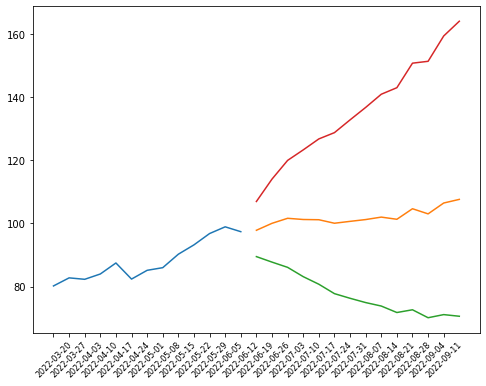

['options', ('2022-06-17', '2022-07-15', '2023-01-20', '2024-01-19', '2026-02-21')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                           9.82
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                       8.14
environmentPercentile                 None
animalTesting                         True
tobacco                              False
totalEsg                             36.46
highestControversy                       3
esgPerformance                    OUT_PERF
coal                                 

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14  31.790001  32.345473  32.709047  33.072622  30.362698  3.500362   

            90d_lower  90d_upper  
2022-06-14  23.361974  37.363423

volume_factor   latest_p   vol_30d_2yr   pct_2yr       adf     hurst
NTUS      0.003169  31.790001  2379907100.0  0.878063  0.159539  0.413711

Sector 1YMF: -120.76998901367188
Sector Volume Factor: 0.0022806018349254167
Sector Risk Trend Factor: -2.889924965769055
Index 1YMF: -69.3499984741211
Index Volume Factor: 0.0022254315395940014
Index Risk Trend Factor: -4.866666559587445


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


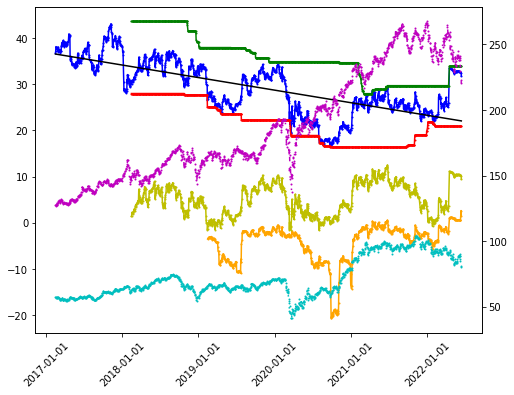

ets next 13 weeks
inner cv scores: [10.031460111932823, 10.03146010370428, 10.031460112611635, 10.031460157233939]
inner cv sdevs: [11.985534852801937, 11.98553484402916, 11.985534852320097, 11.985534828774774]
best model: ['T', 'F']
best inner cv score, sdev (11 folds): 10.03146010370428 11.98553484402916
test cv mean error, stdev (10 folds): [10.626461212846028, 12.414671180945913]
sell date: 2022-06-19
expected return: 0.04214188919670076
discounted return: 0.010372955969947029
quarter return: 2.5841493820794614


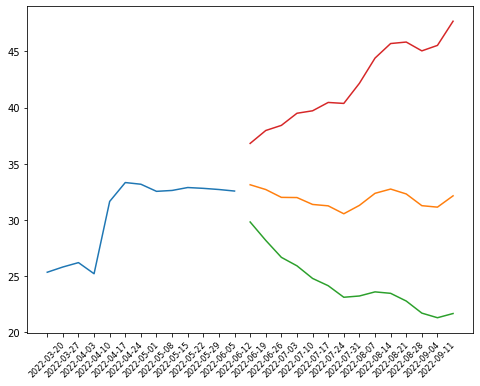

['quarterly_balance_sheet',                                    2021-12-31   2021-09-30   2021-06-30  \
Intangible Assets                  65513000.0   73602000.0   80054000.0   
Total Liab                        139538000.0  138729000.0  138391000.0   
Total Stockholder Equity          424750000.0  422522000.0  417827000.0   
Other Current Liab                 43591000.0   30250000.0   29267000.0   
Total Assets                      564288000.0  561251000.0  556218000.0   
Common Stock                      353737000.0  350457000.0  347818000.0   
Retained Earnings                  84486000.0   82742000.0   77169000.0   
Other Liab                         18140000.0   27558000.0   27867000.0   
Good Will                         148657000.0  149293000.0  150482000.0   
Treasury Stock                    -13473000.0  -10677000.0   -7160000.0   
Other Assets                       41756000.0   43902000.0   45485000.0   
Cash                               75595000.0   68779000.0   62494000.0 

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14  91.309998  78.439849  88.336826  98.233802  85.050318  3.918382   

            90d_lower  90d_upper  
2022-06-14  77.213553  92.887082

volume_factor   latest_p   vol_30d_2yr   pct_2yr       adf     hurst
BANF       0.00208  91.309998  1269485800.0  0.908755  0.916616  0.536421

Index 1YMF: -69.3499984741211
Index Volume Factor: 0.0022254315395940014
Index Risk Trend Factor: -4.866666559587445


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


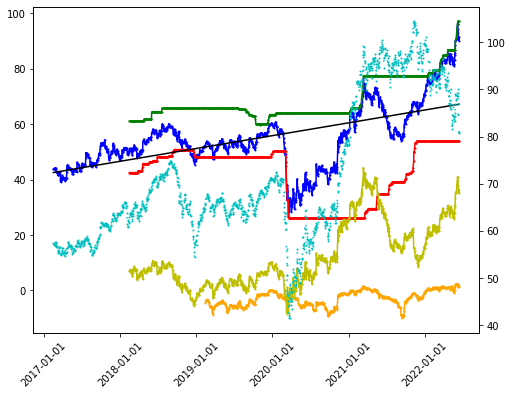

ets next 13 weeks
inner cv scores: [55.05037811240374, 55.050606271872645, 55.050378267465184, 55.050378826915384]
inner cv sdevs: [38.40696138777089, 38.40684785417371, 38.40696123455406, 38.40696220978185]
best model: ['T', 'T']
best inner cv score, sdev (11 folds): 55.05037811240374 38.40696138777089
test cv mean error, stdev (10 folds): [57.95567696588894, 39.112074882464576]
sell date: 2022-08-07
expected return: -0.003023823237859786
discounted return: -5.7138069981199635e-05
quarter return: 0.9947569404468798


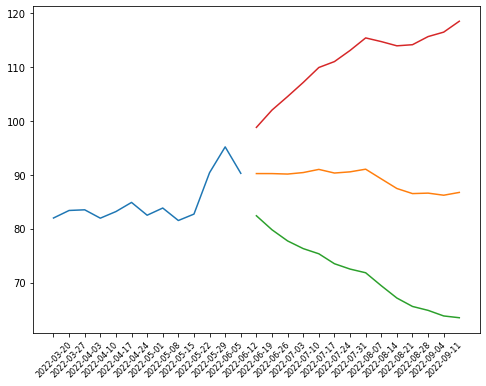

['options', ('2022-06-17',)]
symbol: SM
sector: Energy
Index: SP600
vol_30d_2yr: 43971070600.0
Sector 1YMF: 33.88000297546387
1YMF: 0.0011477728268003554
risk trend factor: 1.48271332961936
        beta currentRatio debtToEquity dividendRate dividendYield      ebitda  \
SM  5.179219        0.717       93.916         0.02        0.0004  1315937024   

   ebitdaMargins forwardPE freeCashflow grossMargins grossProfits  \
SM       0.45427  5.310769    570353344       0.8671   2136878000   

   heldPercentInstitutions       industry   marketCap operatingCashflow  \
SM                 0.88365  Oil & Gas E&P  6310117888        1396240000   

   operatingMargins payoutRatio pegRatio priceToBook  \
SM          0.18012       0.007     0.17    2.983406   

   priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
SM                     2.178288       0.11608        0.7        0.06264   

   returnOnEquity revenueGrowth revenuePerShare  sector sharesOutstanding  \
SM        0.1731

Adj Close   21dBOLD  21dMA-TP   21dBOLU     90dSMA   90dSDev  \
2022-06-14     48.68  33.61221  45.55127  57.49033  40.799365  5.375314   

            90d_lower  90d_upper  
2022-06-14  30.048737  51.549994

volume_factor latest_p    vol_30d_2yr   pct_2yr       adf     hurst
SM      0.001148    48.68  43971070600.0  0.882715  0.962497  0.477599

Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -69.3499984741211
Index Volume Factor: 0.0022254315395940014
Index Risk Trend Factor: -4.866666559587445


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


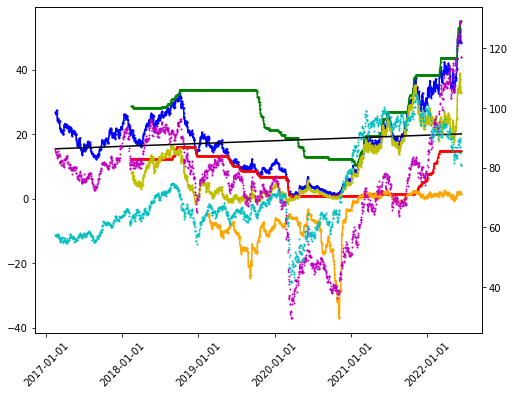

ets next 13 weeks
inner cv scores: [54.55830160170929, 54.55830160179843, 54.55830165642794, 54.55830162553305]
inner cv sdevs: [81.76295272236173, 81.76295272218053, 81.76295270166503, 81.76295273415829]
best model: ['T', 'T']
best inner cv score, sdev (11 folds): 54.55830160170929 81.76295272236173
test cv mean error, stdev (10 folds): [59.85979191105109, 83.9317263444906]
sell date: 2022-09-18
expected return: 0.4161785870352987
discounted return: 0.0036694751318810948
quarter return: 1.400702408289501


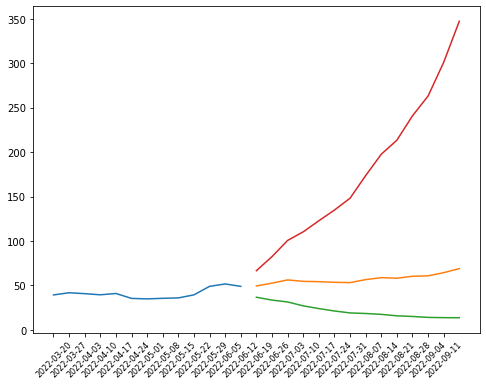

['options', ('2022-08-19', '2023-01-20', '2024-01-19')]
symbol: FANG
sector: Energy
Index: SP500
vol_30d_2yr: 30862818500.0
Sector 1YMF: 60.80000305175781
1YMF: 0.0019773339884690054
risk trend factor: 1.4312617289808671
          beta currentRatio debtToEquity dividendRate dividendYield  \
FANG  2.181941         0.72       42.218          2.8         0.018   

     earningsGrowth      ebitda ebitdaMargins forwardPE freeCashflow  \
FANG          2.278  5041999872       0.65762  6.810776    953625024   

     grossMargins grossProfits heldPercentInstitutions       industry  \
FANG      0.86683   5577000000                 0.91795  Oil & Gas E&P   

        marketCap operatingCashflow operatingMargins payoutRatio pegRatio  \
FANG  27598387200        4572000256          0.48611      0.1272     0.38   

     priceToBook priceToSalesTrailing12Months profitMargins quickRatio  \
FANG    2.166474                     3.599633       0.35751      0.656   

     returnOnAssets returnOnEquity reven

Adj Close     21dBOLD    21dMA-TP    21dBOLU      90dSMA  \
2022-06-14  149.630005  123.836715  145.664128  167.49154  138.967619   

             90dSDev  90d_lower   90d_upper  
2022-06-14  9.402199  120.16322  157.772017

volume_factor    latest_p    vol_30d_2yr   pct_2yr       adf     hurst
FANG      0.001977  149.630005  30862818500.0  0.909025  0.795622  0.471983

Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -263.8100280761719
Index Volume Factor: 0.0022075805827187875
Index Risk Trend Factor: -3.321707170400029


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


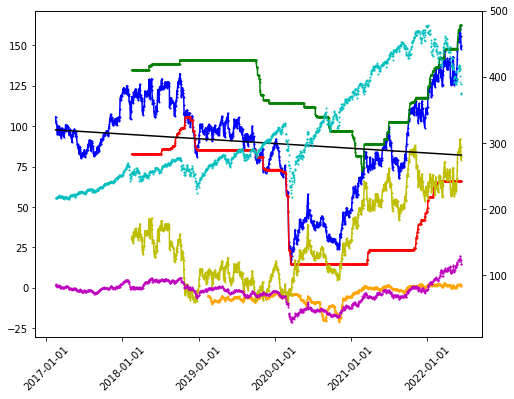

ets next 13 weeks
inner cv scores: [420.9911806742642, 420.99118528006517, 420.9911809362091, 420.99118095605337]
inner cv sdevs: [399.94354296448176, 399.9435472710125, 399.94354269150665, 399.9435426878695]
best model: ['T', 'T']
best inner cv score, sdev (11 folds): 420.9911806742642 399.94354296448176
test cv mean error, stdev (10 folds): [452.09101009939167, 406.58471198735367]
sell date: 2022-09-18
expected return: 0.17649982474330506
discounted return: 0.001712451733919984
quarter return: 1.1704763687697823


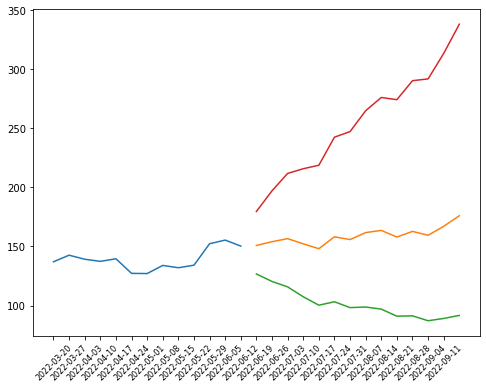

['options', ('2022-06-17', '2023-01-20', '2024-01-19')]
symbol: MUSA
sector: Consumer Cyclical
Index: SP400
vol_30d_2yr: 2942817400.0
Sector 1YMF: 48.60003662109375
1YMF: 0.002574811471483076
risk trend factor: 1.4091055489095428
          beta currentRatio debtToEquity dividendRate dividendYield  \
MUSA  0.820982        1.083      283.285         1.24         0.005   

     earningsGrowth     ebitda ebitdaMargins  forwardPE freeCashflow  \
MUSA          2.025  950200000       0.05637  19.691177    451787488   

     grossMargins grossProfits heldPercentInstitutions          industry  \
MUSA      0.07071   1064700000                 0.86324  Specialty Retail   

       marketCap operatingCashflow operatingMargins payoutRatio pegRatio  \
MUSA  6157129216         846800000          0.04334      0.0569     3.33   

     priceToBook priceToSalesTrailing12Months profitMargins quickRatio  \
MUSA    7.779171                     0.365287       0.02931      0.733   

     returnOnAssets returnO

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-14  233.460007  230.598967  244.042699  257.486431  228.747143   

              90dSDev   90d_lower   90d_upper  
2022-06-14  20.577404  187.592334  269.901951

volume_factor    latest_p   vol_30d_2yr   pct_2yr       adf     hurst
MUSA      0.002575  233.460007  2942817400.0  0.810256  0.994555  0.410124

Sector 1YMF: -352.9100036621094
Sector Volume Factor: 0.0021034643160444764
Sector Risk Trend Factor: -4.247321632052965
Index 1YMF: -63.869998931884766
Index Volume Factor: 0.0011014613124698796
Index Risk Trend Factor: -4.591660649354175


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


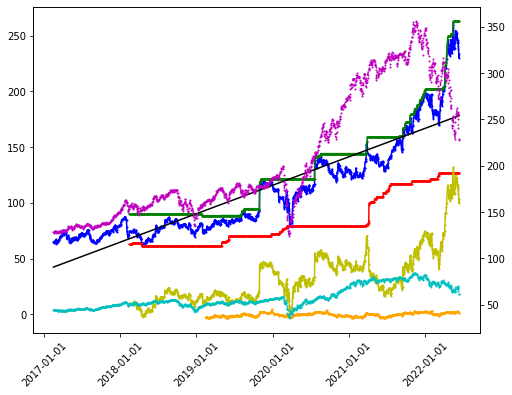

ets next 13 weeks
inner cv scores: [765.2570051310021, 765.2570033166005, 765.2570037428297, 765.2570027051701]
inner cv sdevs: [851.4887196937432, 851.4887360733575, 851.4887359941931, 851.4887207691525]
best model: ['F', 'T']
best inner cv score, sdev (11 folds): 765.2570027051701 851.4887207691525
test cv mean error, stdev (10 folds): [734.658522916889, 887.264017863509]
sell date: 2022-08-14
expected return: 0.06110424655904528
discounted return: 0.0009889905276616595
quarter return: 1.0952056627369904


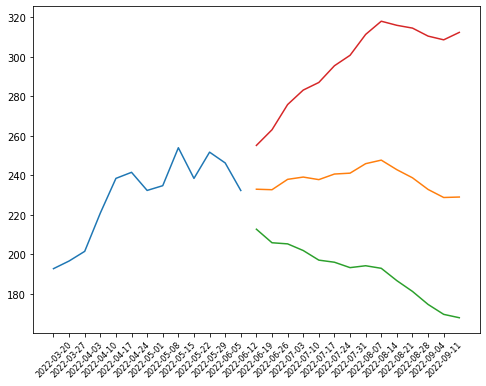

['options', ('2022-07-15', '2022-11-18')]
symbol: PDCE
sector: Energy
Index: SP400
vol_30d_2yr: 12710569500.0
Sector 1YMF: 36.480003356933594
1YMF: 0.0023445054920631214
risk trend factor: 1.3709132852384265
          beta currentRatio debtToEquity dividendRate dividendYield  \
PDCE  2.922058        0.498       32.834            1        0.0155   

          ebitda ebitdaMargins forwardPE freeCashflow grossMargins  \
PDCE  1278352000       0.53439  7.909181    661902144      0.88251   

     grossProfits heldPercentInstitutions       industry   marketCap  \
PDCE   2111095000                 0.96343  Oil & Gas E&P  7717452288   

     operatingCashflow operatingMargins payoutRatio pegRatio priceToBook  \
PDCE        1547795968          0.26364      0.1225     0.14    3.034538   

     priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
PDCE                     3.226148       0.21834       0.47        0.07455   

     returnOnEquity revenueGrowth revenuePerShare  sect

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14  81.650002  61.282943  76.301429  91.319914  73.603492  5.718236   

           90d_lower  90d_upper  
2022-06-14  62.16702  85.039964

volume_factor   latest_p    vol_30d_2yr   pct_2yr       adf     hurst
PDCE      0.002345  81.650002  12710569500.0  0.903714  0.723739  0.494349

Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -63.869998931884766
Index Volume Factor: 0.0011014613124698796
Index Risk Trend Factor: -4.591660649354175


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


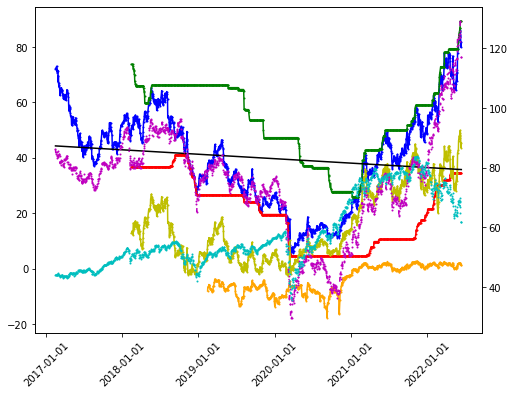

ets next 13 weeks
inner cv scores: [75.09304092740071, 75.09303415841248, 75.09303481621937, 75.09303269656365]
inner cv sdevs: [73.28977152907441, 73.2897722693622, 73.28977185668765, 73.28977285124697]
best model: ['F', 'T']
best inner cv score, sdev (11 folds): 75.09303269656365 73.28977285124697
test cv mean error, stdev (10 folds): [75.00694977102849, 76.86643139553966]
sell date: 2022-09-18
expected return: 0.1767714303828707
discounted return: 0.0017148857126882966
quarter return: 1.1707380497787239


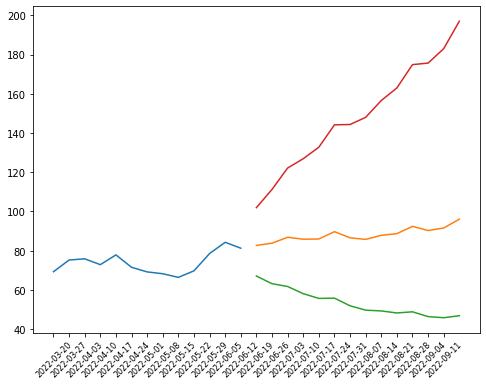

['quarterly_balance_sheet',                              2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus            3.161941e+09  3.267261e+09  3.333168e+09   
Total Liab                 2.426419e+09  2.823041e+09  2.869083e+09   
Total Stockholder Equity   2.910247e+09  2.544224e+09  2.464906e+09   
Deferred Long Term Liab    1.690000e+07  5.600000e+06  6.400000e+06   
Other Current Liab         6.228770e+08  7.500000e+08  6.521060e+08   
Total Assets               5.336666e+09  5.367265e+09  5.333989e+09   
Common Stock               9.650000e+05  9.740000e+05  9.890000e+05   
Other Current Assets       1.790900e+07  7.559000e+06  5.146000e+06   
Retained Earnings         -2.499540e+08 -7.230170e+08 -8.683380e+08   
Other Liab                 5.579650e+08  5.186080e+08  4.555700e+08   
Treasury Stock            -2.705000e+06 -9.940000e+05 -9.130000e+05   
Other Assets               5.559800e+07  4.755700e+07  4.764500e+07   
Cash                       3.382900e+07  9.992200

Adj Close   21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14  61.389999  46.07128  58.382381  70.693483  54.852223  5.232355   

            90d_lower  90d_upper  
2022-06-14  44.387512  65.316933

volume_factor   latest_p    vol_30d_2yr   pct_2yr      adf     hurst
MTDR      0.001226  61.389999  25155623800.0  0.896081  0.97374  0.466991

Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -63.869998931884766
Index Volume Factor: 0.0011014613124698796
Index Risk Trend Factor: -4.591660649354175


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


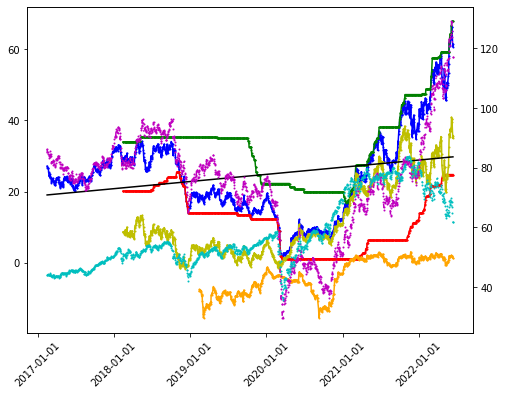

ets next 13 weeks
inner cv scores: [54.44452294015202, 54.44452282954308, 54.44452293384688, 54.44452283616049]
inner cv sdevs: [60.67444204726364, 60.674441930999386, 60.674442048608405, 60.67444192961734]
best model: ['T', 'F']
best inner cv score, sdev (11 folds): 54.44452282954308 60.674441930999386
test cv mean error, stdev (10 folds): [59.493003553515294, 61.393550047501805]
sell date: 2022-09-18
expected return: 0.08933209186492223
discounted return: 0.0009010873003929554
quarter return: 1.0863926409175153


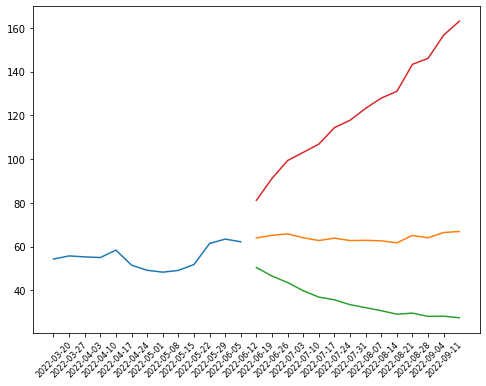

['options', ('2022-06-17', '2022-07-15', '2023-01-20')]
symbol: CVX
sector: Energy
Index: SP500
vol_30d_2yr: 121494374800.0
Sector 1YMF: 39.81001281738281
1YMF: 0.001862212142516412
risk trend factor: 1.2825393501347189
         beta currentRatio debtToEquity dividendRate dividendYield  \
CVX  1.078947        1.433       19.941         5.68        0.0315   

    earningsGrowth       ebitda ebitdaMargins  forwardPE freeCashflow  \
CVX          3.473  38521999360       0.21783  12.431709  21073375232   

    grossMargins grossProfits heldPercentInstitutions              industry  \
CVX      0.40935  66234000000                 0.71587  Oil & Gas Integrated   

        marketCap operatingCashflow operatingMargins payoutRatio pegRatio  \
CVX  355886039040       33045999616          0.12219      0.5113      0.6   

    priceToBook priceToSalesTrailing12Months profitMargins quickRatio  \
CVX    2.433922                     2.012429       0.11596      1.119   

    returnOnAssets returnOnEqui

Adj Close     21dBOLD   21dMA-TP     21dBOLU      90dSMA  \
2022-06-14  167.550003  165.754118  174.02664  182.299162  166.848085   

             90dSDev   90d_lower  90d_upper  
2022-06-14  6.732398  153.383289  180.31288

volume_factor    latest_p     vol_30d_2yr   pct_2yr       adf     hurst
CVX      0.001862  167.550003  121494374800.0  0.873337  0.949121  0.497243

Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -263.8100280761719
Index Volume Factor: 0.0022075805827187875
Index Risk Trend Factor: -3.321707170400029


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


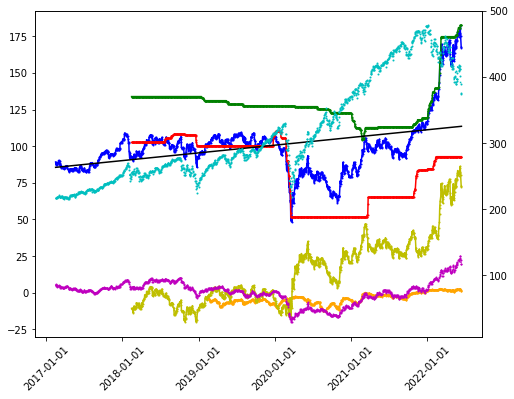

ets next 13 weeks
inner cv scores: [151.81724559834186, 151.81724556629135, 151.81724566025434, 151.81724572933933]
inner cv sdevs: [130.67142203588728, 130.67142201961119, 130.67142194988855, 130.67142195964368]
best model: ['T', 'F']
best inner cv score, sdev (11 folds): 151.81724556629135 130.67142201961119
test cv mean error, stdev (10 folds): [165.40839539167862, 129.42414651195193]


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\exponential_smoothing.py:348: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[0])) * (high - low) + low)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\exponential_smoothing.py:356: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[i])) * (high - low) + low)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\exponential_smoothing.py:364: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-unconstrained[i])) * (high - low) + low)


sell date: 2022-09-18
expected return: 0.08280129850502214
discounted return: 0.0008377346824555154
quarter return: 1.0800845509968897


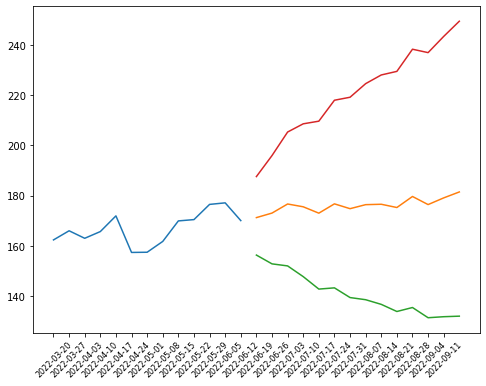

['options', ('2022-06-17', '2023-01-20', '2024-01-19')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                          10.63
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                       9.95
environmentPercentile                 None
animalTesting                         True
tobacco                              False
totalEsg                                43
highestControversy                       3
esgPerformance                   LEAD_PERF
coal                                 False
pesticides            

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14  52.709999  43.053372  50.814127  58.574881  43.209524  6.300526   

            90d_lower  90d_upper  
2022-06-14  30.608473  55.810575

volume_factor   latest_p    vol_30d_2yr   pct_2yr       adf    hurst
DINO      0.001939  52.709999  26318648400.0  0.861118  0.358718  0.56268

Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -63.869998931884766
Index Volume Factor: 0.0011014613124698796
Index Risk Trend Factor: -4.591660649354175


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


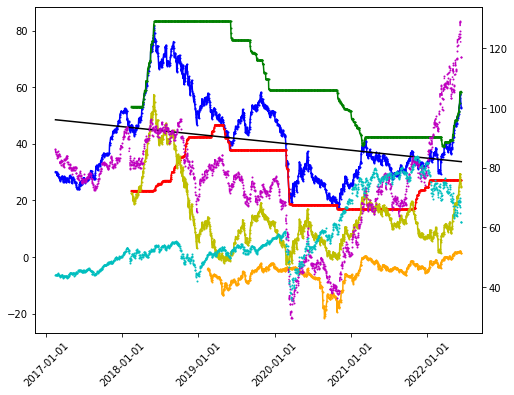

ets next 13 weeks
inner cv scores: [64.68803451378928, 64.68803453398992, 64.68803464738129, 64.6880344998633]
inner cv sdevs: [71.44587844890935, 71.44587844396875, 71.44587835677216, 71.44587845532286]
best model: ['F', 'T']
best inner cv score, sdev (11 folds): 64.6880344998633 71.44587845532286
test cv mean error, stdev (10 folds): [70.46772015759147, 72.43971615287474]
sell date: 2022-08-28
expected return: 0.07016034770763921
discounted return: 0.0009167509719176792
quarter return: 1.0879579003349393


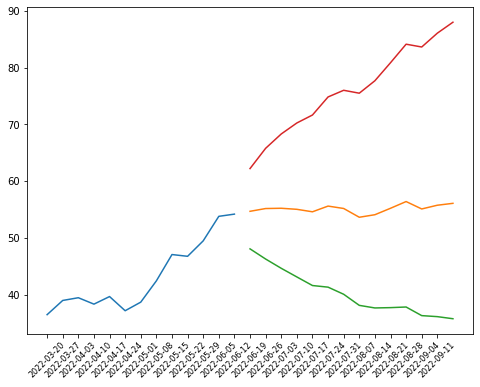

['quarterly_balance_sheet',                              2021-12-31    2021-09-30    2021-06-30  \
Intangible Assets          2.990580e+08  6.410410e+08  6.546840e+08   
Capital Surplus            4.220075e+09  4.232504e+09  4.225032e+09   
Total Liab                 6.622148e+09  6.567642e+09  6.519789e+09   
Total Stockholder Equity   5.687885e+09  5.726740e+09  5.443375e+09   
Minority Interest          6.065800e+08  6.027990e+08  5.968690e+08   
Deferred Long Term Liab    3.973850e+08  3.453140e+08  3.037070e+08   
Other Current Liab         2.699100e+07  1.499010e+08  2.866900e+07   
Total Assets               1.291661e+10  1.289718e+10  1.256003e+10   
Common Stock               2.560000e+06  2.560000e+06  2.560000e+06   
Other Current Assets       6.463000e+06  1.967000e+06  1.563000e+06   
Retained Earnings          4.413836e+09  4.453366e+09  4.172560e+09   
Other Liab                 1.118644e+09  1.136432e+09  1.078211e+09   
Good Will                  2.293044e+09  2.293305

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-14  306.519989  305.867308  321.912697  337.958087  317.366349   

              90dSDev   90d_lower   90d_upper  
2022-06-14  10.865668  295.635013  339.097684

volume_factor    latest_p    vol_30d_2yr  pct_2yr       adf     hurst
MCK      0.001846  306.519989  11748608200.0  0.83305  0.998289  0.462444

Sector 1YMF: -120.76998901367188
Sector Volume Factor: 0.0022806018349254167
Sector Risk Trend Factor: -2.889924965769055
Index 1YMF: -263.8100280761719
Index Volume Factor: 0.0022075805827187875
Index Risk Trend Factor: -3.321707170400029


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


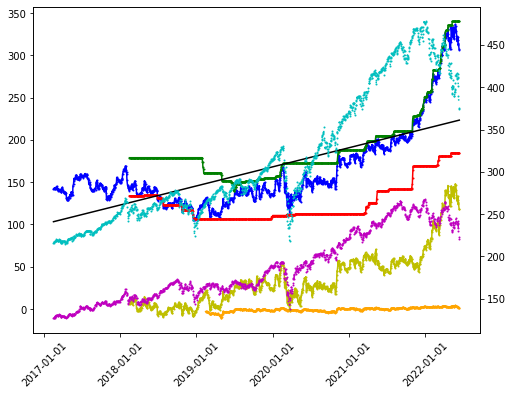

ets next 13 weeks
inner cv scores: [460.05208126937055, 460.0520748585798, 460.05224789481287, 460.05217972923657]
inner cv sdevs: [630.9192856360353, 630.9192650513498, 630.9192056098149, 630.9192346359147]
best model: ['T', 'F']
best inner cv score, sdev (11 folds): 460.0520748585798 630.9192650513498
test cv mean error, stdev (10 folds): [494.6143127590634, 651.7093168256196]
sell date: 2022-09-04
expected return: 0.06314634669239352
discounted return: 0.0007562458488148405
quarter return: 1.0720238639935127


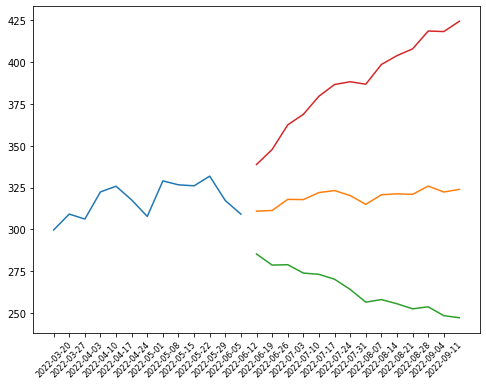

['options', ('2022-08-19', '2023-01-20', '2024-01-19')]
['sustainability',                             Value
2022-5                           
palmOil                     False
controversialWeapons        False
gambling                    False
socialScore                  7.37
nuclear                     False
furLeather                  False
alcoholic                   False
gmo                         False
catholic                    False
socialPercentile             None
peerCount                      58
governanceScore              5.52
environmentPercentile        None
animalTesting               False
tobacco                     False
totalEsg                    15.17
highestControversy              3
esgPerformance         UNDER_PERF
coal                        False
pesticides                  False
adult                       False
percentile                  10.18
peerGroup              Healthcare
smallArms                   False
environmentScore             2.29
governa

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-14  264.549988  261.401114  274.131746  286.862377  256.653492   

              90dSDev   90d_lower  90d_upper  
2022-06-14  15.192129  226.269234  287.03775

volume_factor    latest_p    vol_30d_2yr   pct_2yr       adf     hurst
PXD      0.002081  264.549988  24263857900.0  0.887153  0.912273  0.497407

Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -263.8100280761719
Index Volume Factor: 0.0022075805827187875
Index Risk Trend Factor: -3.321707170400029


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


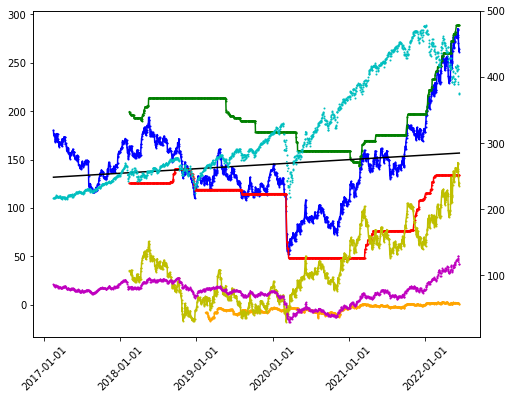

ets next 13 weeks
inner cv scores: [892.5062948284675, 892.5062924862012, 892.5062947368207, 892.506292562174]
inner cv sdevs: [977.0648262253535, 977.0648206428641, 977.0648262138556, 977.0648206123301]
best model: ['T', 'F']
best inner cv score, sdev (11 folds): 892.5062924862012 977.0648206428641
test cv mean error, stdev (10 folds): [969.3279521995831, 992.5744327433306]
sell date: 2022-09-18
expected return: 0.1003102962268565
discounted return: 0.001006740396978012
quarter return: 1.0969937957034677


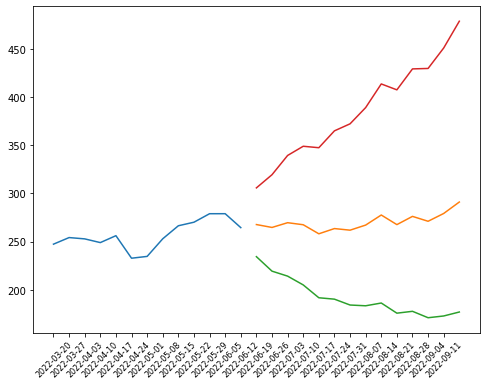

['options', ('2022-06-17', '2023-01-20', '2024-01-19')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                           8.97
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                        9.1
environmentPercentile                 None
animalTesting                        False
tobacco                              False
totalEsg                             36.53
highestControversy                       1
esgPerformance                    OUT_PERF
coal                                 False
pesticides            

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14  34.380001  32.299965  34.590476  36.880987  29.356349  4.009761   

            90d_lower  90d_upper  
2022-06-14  21.336827  37.375872

volume_factor   latest_p    vol_30d_2yr   pct_2yr       adf     hurst
HRB      0.002253  34.380001  27760839000.0  0.896972  0.725167  0.435532

Sector 1YMF: -352.9100036621094
Sector Volume Factor: 0.0021034643160444764
Sector Risk Trend Factor: -4.247321632052965
Index 1YMF: -63.869998931884766
Index Volume Factor: 0.0011014613124698796
Index Risk Trend Factor: -4.591660649354175


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


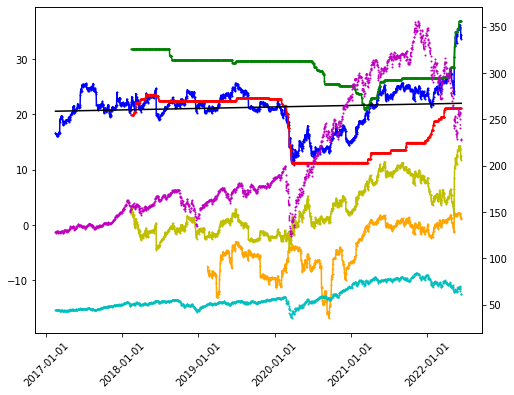

ets next 13 weeks
inner cv scores: [7.879964442872336, 7.87996540432114, 7.879964573246037, 7.879964572890064]
inner cv sdevs: [7.164695090272689, 7.164694992608824, 7.164695029804184, 7.164695416232627]
best model: ['T', 'T']
best inner cv score, sdev (11 folds): 7.879964442872336 7.164695090272689
test cv mean error, stdev (10 folds): [8.086119047023693, 7.483224159904639]
sell date: 2022-08-07
expected return: 0.039744142922428415
discounted return: 0.0007356415169794683
quarter return: 1.0699951738206512


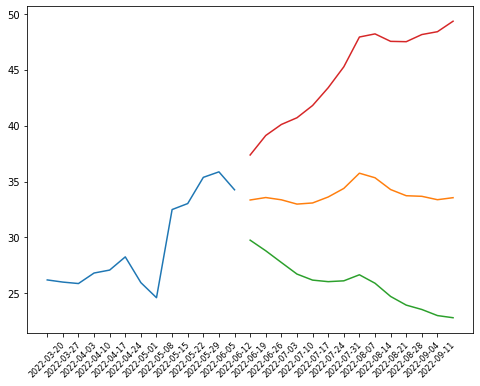

['options', ('2022-07-15', '2023-01-20', '2024-01-19')]
symbol: SWX
sector: Utilities
Index: SP400
vol_30d_2yr: 4573768600.0
Sector 1YMF: 11.229995727539062
1YMF: 0.002194579760768833
risk trend factor: 1.1064033536257658
         beta currentRatio debtToEquity dividendRate dividendYield  \
SWX  0.108035        0.778      174.475         2.48        0.0263   

    earningsGrowth     ebitda ebitdaMargins  forwardPE freeCashflow  \
SWX         -0.222  786628992       0.19366  19.052631   -470833120   

    grossMargins grossProfits heldPercentInstitutions  \
SWX      0.21709    853431000                 0.89023   

                    industry   marketCap operatingCashflow operatingMargins  \
SWX  Utilities—Regulated Gas  6292110336         350460000          0.09512   

    payoutRatio pegRatio priceToBook priceToSalesTrailing12Months  \
SWX      0.8123     5.02    1.803307                     1.549036   

    profitMargins quickRatio returnOnAssets returnOnEquity revenueGrowth  \
SWX  

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA  90dSDev  \
2022-06-14  87.040001  89.230089  92.435079  95.640069  86.673809  6.07931   

           90d_lower  90d_upper  
2022-06-14  74.51519  98.832428

volume_factor   latest_p   vol_30d_2yr   pct_2yr       adf     hurst
SWX      0.002195  87.040001  4573768600.0  0.777835  0.145807  0.399565

Sector 1YMF: -49.86000061035156
Sector Volume Factor: 0.002030212702591272
Sector Risk Trend Factor: -2.0367650862888413
Index 1YMF: -63.869998931884766
Index Volume Factor: 0.0011014613124698796
Index Risk Trend Factor: -4.591660649354175


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


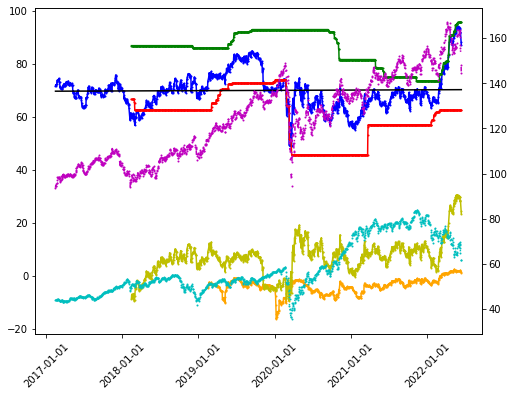

ets next 13 weeks
inner cv scores: [40.85251490496256, 40.85251404388559, 40.85251485750529, 40.8525148569703]
inner cv sdevs: [45.99035856804874, 45.990358557509346, 45.99035859790528, 45.99035859814881]
best model: ['T', 'F']
best inner cv score, sdev (11 folds): 40.85251404388559 45.990358557509346
test cv mean error, stdev (10 folds): [42.239784165390134, 48.01514839154868]
sell date: 2022-08-14
expected return: 0.04870860708533844
discounted return: 0.0007929727235971296
quarter return: 1.0756494092256728


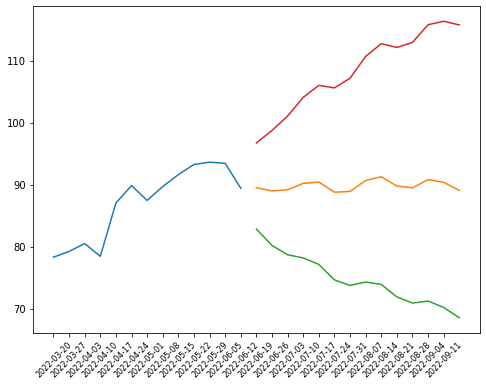

['options', ('2022-07-15',)]
symbol: CIVI
sector: Energy
Index: SP600
vol_30d_2yr: 5736171600.0
Sector 1YMF: 32.53000259399414
1YMF: 0.002990670641722085
risk trend factor: 1.0993578314473855
         beta currentRatio debtToEquity dividendRate dividendYield     ebitda  \
CIVI  1.69646        0.505       11.399         1.85        0.0222  910931008   

     ebitdaMargins forwardPE freeCashflow grossMargins grossProfits  \
CIVI       0.54408  5.807773    855249152      0.79951    731177000   

     heldPercentInstitutions       industry   marketCap operatingCashflow  \
CIVI                 1.04378  Oil & Gas E&P  7110930432         764176000   

     operatingMargins payoutRatio pegRatio priceToBook  \
CIVI          0.26443      0.2792      0.4    1.532868   

     priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
CIVI                     4.247195       0.16167      0.477        0.06714   

     returnOnEquity revenueGrowth revenuePerShare  sector sharesOutstanding

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14  72.260002  59.517328  73.726826  87.936323  65.140952  7.841204   

            90d_lower 90d_upper  
2022-06-14  49.458544  80.82336

volume_factor   latest_p   vol_30d_2yr   pct_2yr       adf     hurst
CIVI      0.002991  72.260002  5736171600.0  0.823297  0.000891  0.485954

ADFuller H0 rejected @ .05, Mean Reverting TS
Month Mean Reverting buy signal


Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -69.3499984741211
Index Volume Factor: 0.0022254315395940014
Index Risk Trend Factor: -4.866666559587445


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


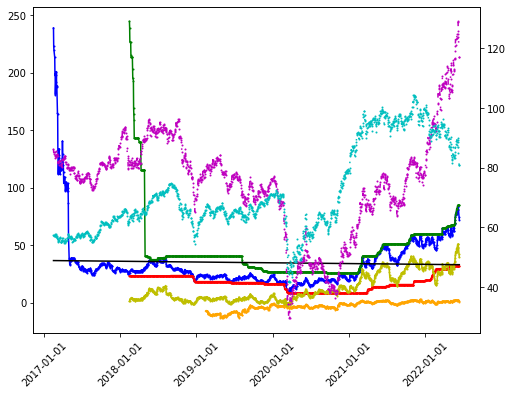

ets next 13 weeks
inner cv scores: [51.372232152287275, 51.37223262366982, 51.37223220954063, 51.37223251010233]
inner cv sdevs: [46.68892014635354, 46.68892026084118, 46.6889202409121, 46.688920193884556]
best model: ['T', 'T']
best inner cv score, sdev (11 folds): 51.372232152287275 46.68892014635354
test cv mean error, stdev (10 folds): [55.240649879687474, 47.257059140146964]
sell date: 2022-08-28
expected return: 0.09487096410260844
discounted return: 0.0012255681702533217
quarter return: 1.1192773292028735


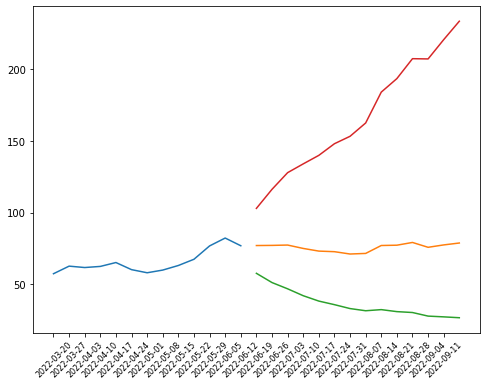

['options', ('2022-07-15', '2022-12-16')]
symbol: CEIX
sector: Energy
Index: SP600
vol_30d_2yr: 5252640900.0
Sector 1YMF: 22.279998779296875
1YMF: 0.00282585470482096
risk trend factor: 1.0878905897116047
          beta currentRatio debtToEquity earningsGrowth     ebitda  \
CEIX  2.379059        0.868      100.167          5.642  282313984   

     ebitdaMargins forwardPE freeCashflow grossMargins grossProfits  \
CEIX       0.22235  9.824903    196007120      0.33279    422536000   

     heldPercentInstitutions      industry   marketCap operatingCashflow  \
CEIX                 0.86884  Thermal Coal  1741250048         305568992   

     operatingMargins payoutRatio priceToBook priceToSalesTrailing12Months  \
CEIX          0.04547           0    3.593283                     1.371392   

     profitMargins quickRatio returnOnAssets returnOnEquity revenueGrowth  \
CEIX       0.02686      0.586        0.01416        0.05563         0.249   

     revenuePerShare  sector sharesOutstanding

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14  48.619999  48.146945  52.563492  56.980039  45.915397  7.098116   

            90d_lower  90d_upper  
2022-06-14  31.719165  60.111629

volume_factor   latest_p   vol_30d_2yr   pct_2yr      adf     hurst
CEIX      0.002826  48.619999  5252640900.0  0.806892  0.88812  0.521633

Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -69.3499984741211
Index Volume Factor: 0.0022254315395940014
Index Risk Trend Factor: -4.866666559587445


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


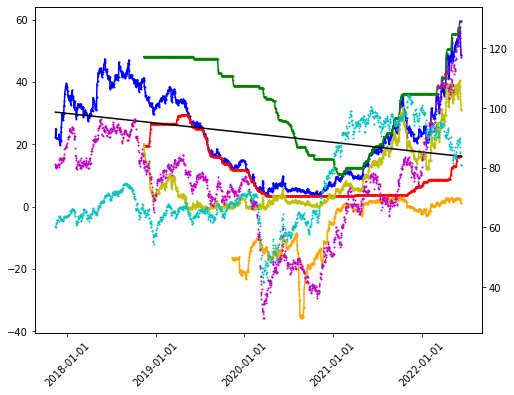

ets next 13 weeks
inner cv scores: [37.17757965786298, 37.177599654259346, 37.17758346919223, 37.177582876349014]
inner cv sdevs: [60.594009313268195, 60.594010488534494, 60.594019423616295, 60.59401174988886]
best model: ['T', 'T']
best inner cv score, sdev (11 folds): 37.17757965786298 60.594009313268195
test cv mean error, stdev (10 folds): [37.17759591773493, 60.59400035675132]
sell date: 2022-09-04
expected return: 0.4354238131587394
discounted return: 0.004472442586290981
quarter return: 1.5076427315207657


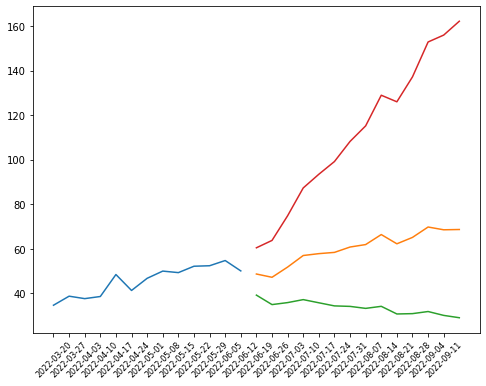

['quarterly_balance_sheet',                                     2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus                   6.469450e+08  6.449200e+08  6.430330e+08   
Total Liab                        1.900704e+09  2.105167e+09  1.965198e+09   
Total Stockholder Equity          6.728130e+08  4.845800e+08  5.927330e+08   
Other Current Liab                1.790310e+08  2.688430e+08  1.451780e+08   
Total Assets                      2.573517e+09  2.589747e+09  2.557931e+09   
Common Stock                      3.450000e+05  3.450000e+05  3.450000e+05   
Other Current Assets              3.747200e+07  4.242800e+07  3.166900e+07   
Retained Earnings                 2.809600e+08  1.636370e+08  2.774260e+08   
Other Liab                        8.455480e+08  9.379920e+08  9.285180e+08   
Treasury Stock                   -2.554370e+08 -3.243220e+08 -3.280710e+08   
Other Assets                      5.153480e+08  5.008660e+08  4.742010e+08   
Cash                              1.

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14  31.110001  29.591317  33.487619  37.383921  30.099841  3.173533   

            90d_lower  90d_upper  
2022-06-14  23.752774  36.446908

volume_factor   latest_p    vol_30d_2yr   pct_2yr       adf     hurst
CTRA      0.002488  31.110001  85091501400.0  0.755725  0.297053  0.466999

Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -263.8100280761719
Index Volume Factor: 0.0022075805827187875
Index Risk Trend Factor: -3.321707170400029


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


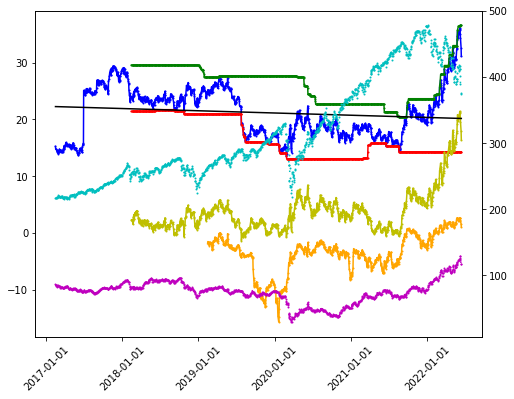

ets next 13 weeks
inner cv scores: [8.490921905599953, 8.49092190559995, 8.49091938114321, 8.49091959997832]
inner cv sdevs: [13.61240965411061, 13.61240965411061, 13.612411037707153, 13.612410995807492]
best model: ['F', 'F']
best inner cv score, sdev (11 folds): 8.49091938114321 13.612411037707153
test cv mean error, stdev (10 folds): [9.248663628059463, 14.053882917359559]
sell date: 2022-07-03
expected return: 0.09349971914706096
discounted return: 0.004978088843464068
quarter return: 1.5790888440851625


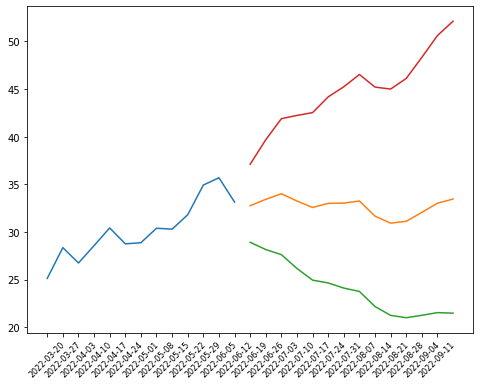

['quarterly_balance_sheet',                              2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus            1.091100e+10  1.823373e+09  1.815770e+09   
Total Liab                 8.112000e+09  2.404585e+09  2.310672e+09   
Total Stockholder Equity   1.173800e+10  2.326112e+09  2.299895e+09   
Deferred Long Term Liab    5.000000e+06  5.329000e+06  5.844000e+06   
Other Current Liab         1.880000e+08  2.128940e+08  7.719900e+07   
Total Assets               1.990000e+10  4.730697e+09  4.610567e+09   
Common Stock               8.900000e+07  4.786200e+07  4.786200e+07   
Other Current Assets       2.400000e+07  1.323500e+07  1.540000e+07   
Retained Earnings          2.563000e+09  2.276071e+09  2.257320e+09   
Other Liab                 3.512000e+09  9.650310e+08  9.577370e+08   
Treasury Stock            -1.825000e+09 -1.821194e+09 -1.821057e+09   
Other Assets               7.200000e+07  3.109900e+07  3.170800e+07   
Cash                       1.036000e+09  7.627000

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-14  131.259995  119.225897  134.415556  149.605215  125.023334   

             90dSDev   90d_lower   90d_upper  
2022-06-14  8.717671  107.587992  142.458675

volume_factor    latest_p    vol_30d_2yr   pct_2yr       adf     hurst
EOG      0.001647  131.259995  49783403200.0  0.856727  0.811415  0.485527

Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -263.8100280761719
Index Volume Factor: 0.0022075805827187875
Index Risk Trend Factor: -3.321707170400029


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


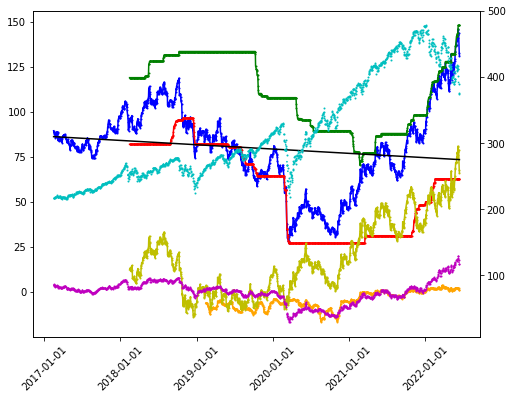

ets next 13 weeks
inner cv scores: [292.9270453853788, 292.9270439336202, 292.92704520194474, 292.932579020314]
inner cv sdevs: [278.02334416296463, 278.0233424023367, 278.02334431198744, 278.0363452309527]
best model: ['T', 'F']
best inner cv score, sdev (11 folds): 292.9270439336202 278.0233424023367
test cv mean error, stdev (10 folds): [320.1641374181127, 277.24759126505654]
sell date: 2022-09-18
expected return: 0.19502048924895965
discounted return: 0.0018771631537259914
quarter return: 1.1883159307933717


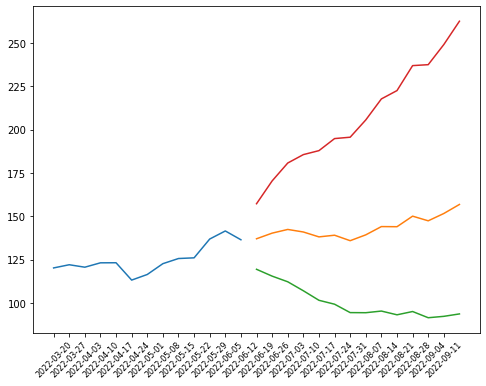

['quarterly_balance_sheet',                                     2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus                   6.087000e+09  6.058000e+09  6.017000e+09   
Total Liab                        1.605600e+10  1.540700e+10  1.600400e+10   
Total Stockholder Equity          2.218000e+10  2.176500e+10  2.088100e+10   
Other Current Liab                1.523000e+09  1.224000e+09  1.698000e+09   
Total Assets                      3.823600e+10  3.717200e+10  3.688500e+10   
Common Stock                      2.060000e+08  2.060000e+08  2.060000e+08   
Other Current Assets              4.560000e+08  3.810000e+08  5.130000e+08   
Retained Earnings                 1.591900e+10  1.554200e+10  1.468900e+10   
Other Liab                        6.384000e+09  6.844000e+09  6.916000e+09   
Treasury Stock                   -3.200000e+07 -4.100000e+07 -3.100000e+07   
Other Assets                      4.830000e+08  1.278000e+09  1.291000e+09   
Cash                              5.

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14  45.240002  29.444383  42.210556  54.976728  37.569365  5.330721   

            90d_lower  90d_upper  
2022-06-14  26.907924  48.230807

volume_factor   latest_p   vol_30d_2yr   pct_2yr       adf     hurst
ROCC      0.001944  45.240002  6186219000.0  0.823206  0.622824  0.579733

Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -69.3499984741211
Index Volume Factor: 0.0022254315395940014
Index Risk Trend Factor: -4.866666559587445


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


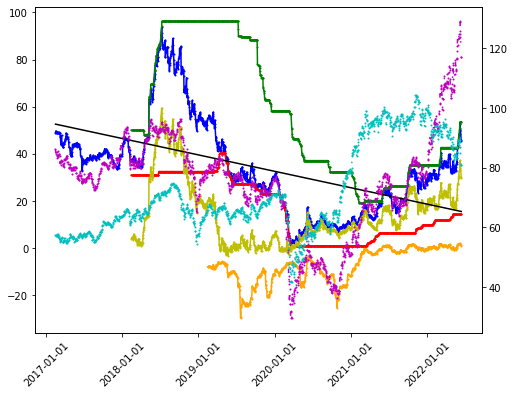

ets next 13 weeks
inner cv scores: [71.38113556924571, 71.38113547261227, 71.38107197959948, 71.38107197165442]
inner cv sdevs: [76.5678010950792, 76.56780087204898, 76.56781110897751, 76.56781111187205]
best model: ['F', 'T']
best inner cv score, sdev (11 folds): 71.38107197165442 76.56781111187205
test cv mean error, stdev (10 folds): [75.727216744053, 79.00074871051713]
sell date: 2022-08-07
expected return: 0.11902086456874392
discounted return: 0.0021240275552245613
quarter return: 1.2155580840834126


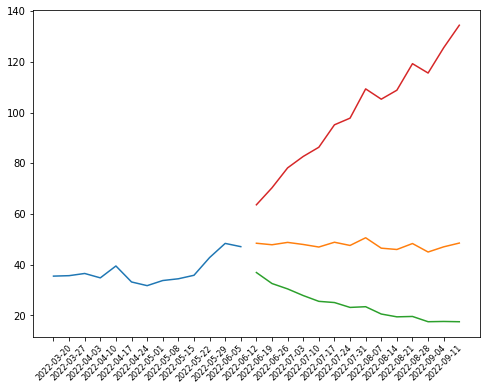

['options', ('2022-07-15', '2022-12-16')]
symbol: HES
sector: Energy
Index: SP500
vol_30d_2yr: 24607383000.0
Sector 1YMF: 34.04999542236328
1YMF: 0.0017705417922742942
risk trend factor: 1.0422402625987157
         beta currentRatio debtToEquity dividendRate dividendYield  \
HES  1.769607        1.418      122.347          1.5        0.0131   

    earningsGrowth      ebitda ebitdaMargins forwardPE freeCashflow  \
HES          0.634  3804999936       0.49467  25.03419   1165874944   

    grossMargins grossProfits heldPercentInstitutions       industry  \
HES      0.71425   5267000000                 0.83247  Oil & Gas E&P   

       marketCap operatingCashflow operatingMargins payoutRatio pegRatio  \
HES  36287619072        2143000064          0.30083      0.4828     0.19   

    priceToBook priceToSalesTrailing12Months profitMargins quickRatio  \
HES    6.429591                     4.717579       0.09412      0.595   

    returnOnAssets returnOnEquity revenueGrowth revenuePerShare  

Adj Close     21dBOLD    21dMA-TP    21dBOLU      90dSMA   90dSDev  \
2022-06-14    120.07  111.313564  121.821587  132.32961  112.455397  8.510819   

            90d_lower   90d_upper  
2022-06-14  95.433758  129.477035

volume_factor latest_p    vol_30d_2yr   pct_2yr       adf     hurst
HES      0.001771   120.07  24607383000.0  0.882322  0.938257  0.449035

Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -263.8100280761719
Index Volume Factor: 0.0022075805827187875
Index Risk Trend Factor: -3.321707170400029


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


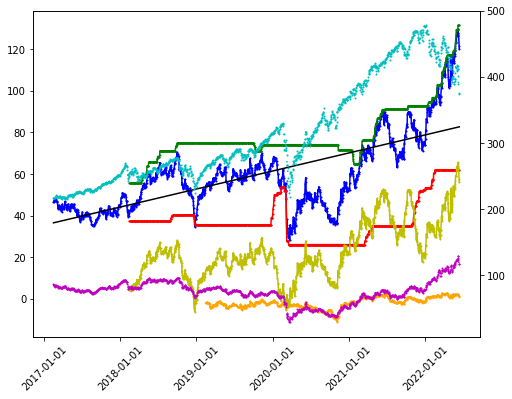

ets next 13 weeks
inner cv scores: [189.7450140342545, 189.7450140343074, 189.74501403310452, 189.74501404243793]
inner cv sdevs: [200.65877762564895, 200.6587776221327, 200.65877762593144, 200.6587776288162]
best model: ['F', 'F']
best inner cv score, sdev (11 folds): 189.74501403310452 200.65877762593144
test cv mean error, stdev (10 folds): [207.17371143611325, 202.35855585333596]
sell date: 2022-09-18
expected return: 0.15596163362674056
discounted return: 0.001526770442668024
quarter return: 1.1506830958889815


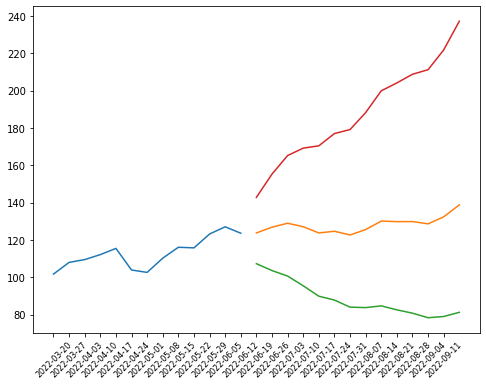

['quarterly_balance_sheet',                                     2022-03-31    2021-12-31    2021-09-30  \
Total Liab                        1.275000e+10  1.348900e+10  1.323400e+10   
Total Stockholder Equity          6.308000e+09  6.300000e+09  5.609000e+09   
Minority Interest                 7.400000e+08  7.260000e+08  6.470000e+08   
Other Current Liab                2.190000e+09  1.193000e+09  9.330000e+08   
Total Assets                      1.979800e+10  2.051500e+10  1.949000e+10   
Common Stock                      7.074000e+09  3.100000e+08  3.100000e+08   
Other Current Assets              1.896000e+09  1.990000e+08  1.180000e+08   
Other Liab                        1.937000e+09  1.890000e+09  1.877000e+09   
Treasury Stock                   -7.660000e+08 -4.060000e+08 -7.960000e+08   
Other Assets                      1.560000e+09  1.129000e+09  7.660000e+08   
Cash                              1.370000e+09  2.713000e+09  2.419000e+09   
Total Current Liabilities         2.

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14      31.6  31.867551  32.187619  32.507687  31.740317  0.960049   

           90d_lower  90d_upper  
2022-06-14  29.82022  33.660415

volume_factor latest_p   vol_30d_2yr   pct_2yr       adf     hurst
TVTY      0.002918     31.6  5611692500.0  0.943172  0.510164  0.449517

Index 1YMF: -69.3499984741211
Index Volume Factor: 0.0022254315395940014
Index Risk Trend Factor: -4.866666559587445


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


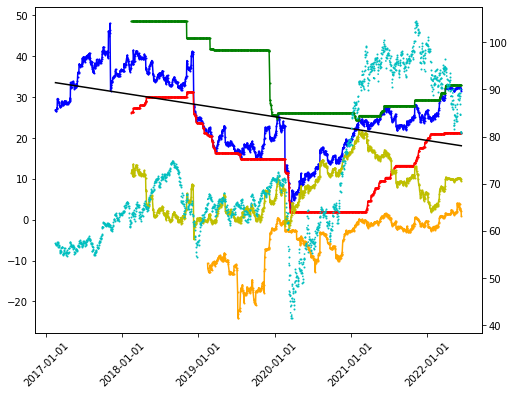

ets next 13 weeks
inner cv scores: [23.437302354648853, 23.437302324695864, 23.43730523304616, 23.43730524319808]
inner cv sdevs: [20.620170957952805, 20.620170913895695, 20.6201768922314, 20.6201768869547]
best model: ['T', 'F']
best inner cv score, sdev (11 folds): 23.437302324695864 20.620170913895695
test cv mean error, stdev (10 folds): [25.29395733901864, 20.731419404745342]
sell date: 2022-07-24
expected return: 0.05897098655315649
discounted return: 0.0014702507661197295
quarter return: 1.144724197588399


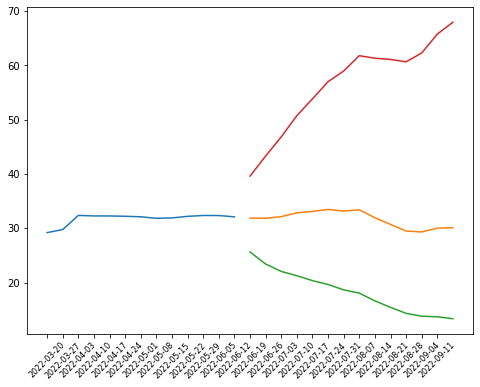

['options', ('2022-08-19',)]
symbol: OXY
sector: Energy
Index: SP500
vol_30d_2yr: 256214422000.0
Sector 1YMF: 21.77999496459961
1YMF: 0.0022195655324976204
risk trend factor: 0.9675696533828447
         beta currentRatio debtToEquity dividendRate dividendYield  \
OXY  1.955081        1.156      111.198         0.52        0.0084   

          ebitda ebitdaMargins forwardPE freeCashflow grossMargins  \
OXY  15392000000       0.53054  7.333333   9129875456      0.64697   

    grossProfits heldPercentInstitutions       industry    marketCap  \
OXY  16297000000                 0.82163  Oil & Gas E&P  56493871104   

    operatingCashflow operatingMargins payoutRatio pegRatio priceToBook  \
OXY       12762999808          0.25255      0.0242     0.25    3.730198   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
OXY                     1.947259       0.25314      0.844        0.05964   

    returnOnEquity revenueGrowth revenuePerShare  sector sharesOutstanding 

Adj Close    21dBOLD  21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14     62.09  60.915808  66.88381  72.851811  61.294445  4.783614   

            90d_lower  90d_upper  
2022-06-14  51.727217  70.861672

volume_factor latest_p     vol_30d_2yr   pct_2yr       adf     hurst
OXY       0.00222    62.09  256214422000.0  0.817613  0.738509  0.544974

Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -263.8100280761719
Index Volume Factor: 0.0022075805827187875
Index Risk Trend Factor: -3.321707170400029


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


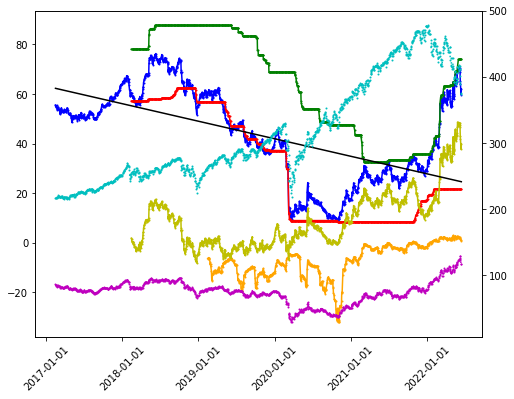

ets next 13 weeks
inner cv scores: [65.74632537823037, 65.74632526324514, 65.74632563897408, 65.74632473939108]
inner cv sdevs: [72.72855684487484, 72.7285560600168, 72.72855583412783, 72.72855645935246]
best model: ['F', 'T']
best inner cv score, sdev (11 folds): 65.74632473939108 72.72855645935246
test cv mean error, stdev (10 folds): [69.94735867807196, 74.99501086042389]
sell date: 2022-09-18
expected return: 0.15204190134433437
discounted return: 0.001490962320840783
quarter return: 1.1469042757640264


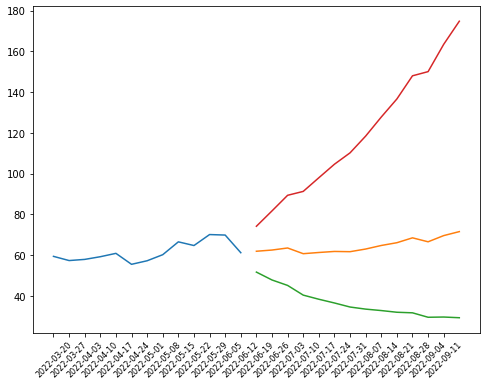

['options', ('2022-06-17', '2022-08-19', '2023-01-20', '2024-01-19')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                          12.04
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                       6.88
environmentPercentile                 None
animalTesting                        False
tobacco                              False
totalEsg                             43.53
highestControversy                       2
esgPerformance                   LEAD_PERF
coal                                 False
pesticid

Adj Close    21dBOLD  21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-14  41.580002  32.779324  40.32127  47.863216  39.598281  3.268708   

            90d_lower  90d_upper  
2022-06-14  33.060864  46.135697

volume_factor   latest_p    vol_30d_2yr   pct_2yr       adf     hurst
MUR      0.001055  41.580002  33077715200.0  0.891467  0.791664  0.454943

Sector 1YMF: 43.219993591308594
Sector Volume Factor: 0.0015231818763778249
Sector Risk Trend Factor: 1.395093250744777
Index 1YMF: -63.869998931884766
Index Volume Factor: 0.0011014613124698796
Index Risk Trend Factor: -4.591660649354175


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


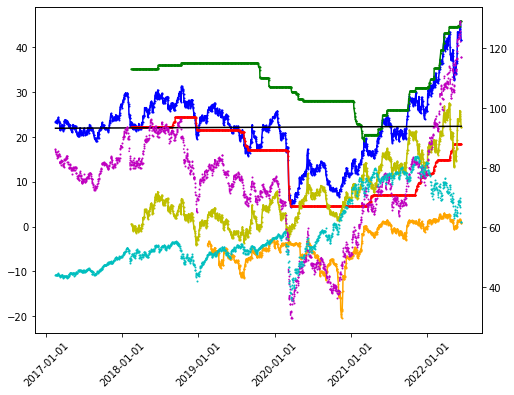

ets next 13 weeks
inner cv scores: [26.871992144205784, 26.871992150022162, 26.871992150235926, 26.871992144997105]
inner cv sdevs: [29.605645173940232, 29.60564517761439, 29.60564517743851, 29.60564517392599]
best model: ['T', 'T']
best inner cv score, sdev (11 folds): 26.871992144205784 29.605645173940232
test cv mean error, stdev (10 folds): [28.72572118180319, 30.435903535486183]
sell date: 2022-09-18
expected return: 0.1925349142752104
discounted return: 0.0018552053107643296
quarter return: 1.185922273727027


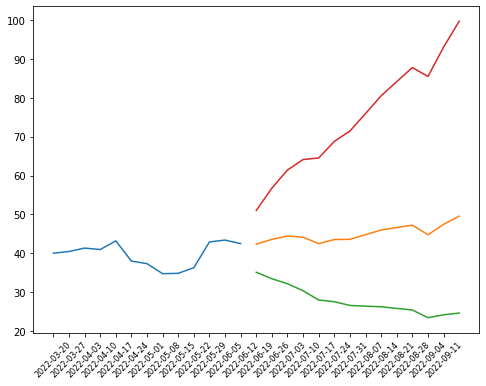

['options', ('2022-06-17', '2022-07-15', '2022-12-16', '2023-01-20', '2024-01-19')]
symbol: AZPN
sector: Technology
Index: SP400
vol_30d_2yr: 4840968000.0
Sector 1YMF: 50.989990234375
1YMF: 0.0012578889180841519
risk trend factor: 0.8268198335018307
     currentRatio debtToEquity earningsGrowth    ebitda ebitdaMargins  \
AZPN        1.176       40.561          0.231  27337000       0.08523   

      forwardPE grossMargins grossProfits heldPercentInstitutions  \
AZPN  34.490196      0.46746    137630000                 1.03086   

                  industry    marketCap operatingCashflow operatingMargins  \
AZPN  Software—Application  12029022208          45755000         -0.08421   

     payoutRatio pegRatio priceToBook priceToSalesTrailing12Months  \
AZPN           0     4.59   16.632854                    37.503967   

     profitMargins quickRatio revenueGrowth revenuePerShare      sector  \
AZPN      -0.07406      1.116         0.154           4.811  Technology   

     sharesOuts

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-14  184.309998  174.372359  193.022857  211.673356  170.678412   

              90dSDev   90d_lower   90d_upper  
2022-06-14  18.041759  134.594895  206.761929

volume_factor    latest_p   vol_30d_2yr   pct_2yr       adf     hurst
AZPN      0.001258  184.309998  4840968000.0  0.775395  0.752504  0.381769

Sector 1YMF: -353.0699768066406
Sector Volume Factor: 0.00219037124135683
Sector Risk Trend Factor: -4.508044961227624
Index 1YMF: -63.869998931884766
Index Volume Factor: 0.0011014613124698796
Index Risk Trend Factor: -4.591660649354175


C:\Users\User\AppData\Local\Temp\ipykernel_7384\2930981872.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)


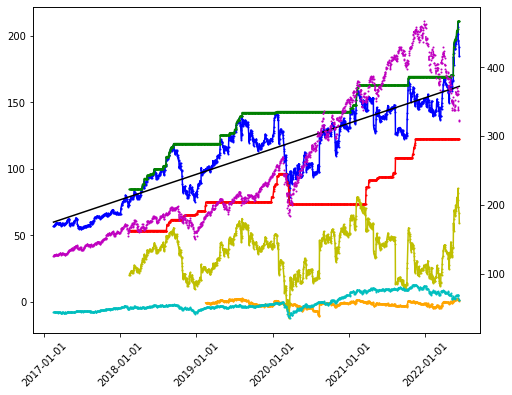

ets next 13 weeks
inner cv scores: [366.7245041926584, 366.72448797471003, 366.7245041926584, 366.7245036735472]
inner cv sdevs: [560.7658577875985, 560.7658611961473, 560.7658577875985, 560.7658580175564]
best model: ['T', 'F']
best inner cv score, sdev (11 folds): 366.72448797471003 560.7658611961473
test cv mean error, stdev (10 folds): [401.82341576592614, 576.5005602318051]
sell date: 2022-07-24
expected return: 0.11635016787519324
discounted return: 0.0028261549197503566
quarter return: 1.296462672251224


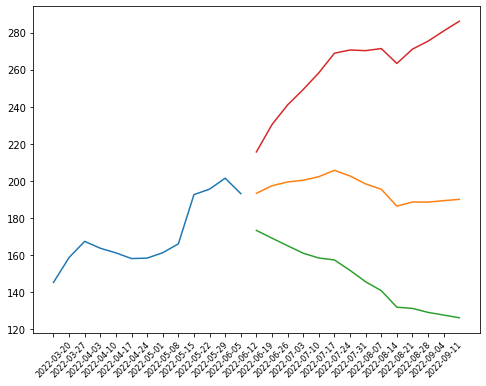

['options', ('2022-07-15', '2022-12-16')]


In [43]:
client = Client('192.168.3.100:8786')

#tscv = expanding_window(initial =52*2, horizon = 13,period = 26)

batchClearLimit = round(len(list__)/7)

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
 
decision_metrics = []

print("adf < .05 or .01, mean reverting")
print("Hurst")
print("> .5 - The time series is mean reverting.")
print("= .5 - The time series is a Geometric Brownian Motion.")
print("< .5 - The time series is trending.")
"""*spdr_indexes['Symbol'].values,*vanguard_sectors['Symbol'].values,"""
for s in list__:
#for s in ['CEIX']:
    msize = 2

    metrics_df_ = pd.DataFrame(pd.DataFrame(screener.loc[s].dropna()).T[['volume_factor','latest_p','vol_30d_2yr','pct_2yr','adf','hurst']])

    subset=prices[prices['Symbol']==s]

    dates = []
    for t in subset.index.values:
        d = pd.Timestamp(t).strftime('%Y-%m-%d')
        dates.append(d)
        dto = datetime.strptime(d, '%Y-%m-%d').date()

    old_ordinal = [datetime.strptime(i, '%Y-%m-%d').toordinal() for i in dates]
    new_ordinal = old_ordinal + md.date2num(np.datetime64('0000-12-31'))
    x = new_ordinal    

    lookup_index_ = []

    labels = list()
    print("symbol:",s)   

    try:
        symbol_sector = dict_sectors[sector_merged[sector_merged['Symbol']==s]['Sector'].values[0]]
        print("sector:",dict_sectors_reverse[symbol_sector])
    except:
        if(symbol_sector=='error'):
            if(np.sum([vanguard_sectors['Symbol'].values==s])):
                symbol_sector = s
                print("sector:",dict_sectors_reverse[symbol_sector])
        else:
            symbol_sector = 'error'
    if(symbol_sector=='error'):
        if(np.sum([vanguard_sectors['Symbol'].values==s])):
            symbol_sector = s
            print("sector:",dict_sectors_reverse[symbol_sector])
        else:
            symbol_sector = 'error'
            print("sector:",'error')

    symbol_index = temp_sm.loc[s]['index_Symbol']

    try:
        matched_index_name = spdr_indexes.iloc[np.where(spdr_indexes['Symbol'].values==s)].index[0]
    except:
        try:
            matched_index_name = temp_sm.loc[s]['index']
        except:
            matched_index_name = "none"

    print("Index:",matched_index_name)

    print("vol_30d_2yr:",screener.iloc[np.where(screener.index==s)]['vol_30d_2yr'][0])
    #print("1YMF:",subset['1YMF'].values[-1])
    print("Sector 1YMF:",screener[screener.index==s]['1YMF'][0])
    print("1YMF:",screener.iloc[np.where(screener.index==s)]['volume_factor'][0])
    print("risk trend factor:",screener.iloc[np.where(screener.index==s)]['risk_trend_factor'][0])

    temp = pd.DataFrame(stock_fundamentals.loc[s])
    print(temp[np.array(temp!='error')].replace([np.inf,'inf','error', -np.inf], np.nan).dropna().T)

    last_date = pd.DataFrame(subset.iloc[-1][['21dBOLD','21dMA-TP','21dBOLU']],index=[prices[prices['Symbol']==s].index[-1].strftime('%Y-%m-%d')]).index[0]

    bbands = pd.DataFrame(subset.iloc[-1][['Adj Close','21dBOLD','21dMA-TP','21dBOLU','90dSMA','90dSDev']]).T
    bbands['90d_lower'] = bbands['90dSMA']-bbands['90dSDev']*2
    bbands['90d_upper'] = bbands['90dSMA']+bbands['90dSDev']*2
    
    bbands.index = [last_date]
    display(bbands)

    display(metrics_df_)
    
    mean_revert_flag = False
    
    if(metrics_df_['adf'][0]<.05):
        print("ADFuller H0 rejected @ .05, Mean Reverting TS")
        if(bbands['Adj Close'][0]<bbands['90d_lower'][0]):
            colored_text = colored(255, 0, 0, "Quarter Mean Reverting buy signal")
            print(colored_text)
            mean_revert_flag = True
        if(bbands['Adj Close'][0]<bbands['21dBOLU'][0]):
            colored_text = colored(255, 0, 0, "Month Mean Reverting buy signal")
            print(colored_text)
            mean_revert_flag = True
    
    fig, ax1 = plt.subplots()   
    
    ax2 = ax1.twinx()
    
    l_axis_legend = pd.DataFrame(['symbol', 'trailing_1yr_max', 'trailing_1yr_min', 'risk_trend_factor','linear','supply_trend_1yr'],index=['blue','green','red','orange','black','yellow'],columns=['legend'])

    r_axis_legend = pd.DataFrame(['sector','index'],index=['magenta','cyan'],columns=['legend'])

    display_side_by_side([l_axis_legend, r_axis_legend], ['l axis', 'r axis'])
    
    if(symbol_sector=='error'):
        pass
    else:
        if(np.sum(vanguard_sectors['Symbol'].values==s)>0):
            pass
        else:
            #print("sector",)
            #print("else_sector:",dict_sectors_reverse[s])            
            print("Sector 1YMF:",screener[screener.index==symbol_sector]['1YMF'][0])
            print("Sector Volume Factor:",screener.iloc[np.where(screener.index==symbol_sector)]['volume_factor'][0])
            print("Sector Risk Trend Factor:",screener.iloc[np.where(screener.index==symbol_sector)]['risk_trend_factor'][0])
            ax2.plot(x, (prices[prices['Symbol']==symbol_sector]['Adj Close']).iloc[-len(subset):],marker = '.',markersize=msize,color='m',linestyle=(0, (3, 10, 1, 10)))
            #ax2.plot(x, prices[prices['Symbol']==symbol_sector]['Adj Close'],marker = '.',markersize=msize,color='m',linestyle=(0, (3, 10, 1, 10)))        
            #plt.legend([temp_sm.loc[s]['Sector']])
            #labels_ax2.append(temp_sm.loc[s]['Sector'])
            #plt.show()

    if(str(temp_sm.loc[s]['index_Symbol'])!='nan'):
        if(temp_sm.loc[s]['index_Symbol']!='error'):
            #print(temp_sm.loc[s]['index_Symbol'])
            print("Index 1YMF:",screener[screener.index==temp_sm.loc[s]['index_Symbol']]['1YMF'][0])
            print("Index Volume Factor:",screener.iloc[np.where(screener.index==temp_sm.loc[s]['index_Symbol'])]['volume_factor'][0])
            print("Index Risk Trend Factor:",screener.iloc[np.where(screener.index==temp_sm.loc[s]['index_Symbol'])]['risk_trend_factor'][0])

            ax2.plot(x, prices[prices['Symbol']==temp_sm.loc[s]['index_Symbol']]['Adj Close'].iloc[-len(subset):],marker = '.',markersize=msize,color='c',linestyle=(0, (1, 10)))
            #plt.plot()
            #plt.legend([temp_sm.loc[s]['index']])
            #labels_ax2.append(temp_sm.loc[s]['index'])
            #plt.show()

    y= subset['Adj Close']

    slope, intercept, r, p, std_err = stats.linregress(x, y)

    mymodel = list(map(myfunc, x))

    ax1.plot(x, y,marker = '.',markersize=msize, color = 'b')
    ax1.plot(x, subset['trailing_1yr_max'],marker = '.',markersize=msize, color = 'g')
    ax1.plot(x, subset['trailing_1yr_min'],marker = '.',markersize=msize, color = 'r')
    ax1.plot(x, subset['risk_trend_factor'],marker = '.',markersize=msize, color = 'orange')
    
    ax1.plot(x, subset['supply_trend_1yr'],marker = '.',markersize=msize, color = 'y')
    
    ax1.plot(x, mymodel, color = 'k')
    
    for l in ['symbol','1yrMax','1yrMin','risk_trend_factor','supply_trend_1yr','linear']:
        labels.append(l)
    
    l = matplotlib.dates.AutoDateLocator()
    f = matplotlib.dates.ConciseDateFormatter(l)    
    
    ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)
    
    locator = matplotlib.dates.AutoDateLocator()
    formatter = matplotlib.dates.ConciseDateFormatter(locator)

    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_formatter(formatter)
    
    date_form = DateFormatter("%Y-%m-%d")
    ax1.xaxis.set_major_formatter(date_form)
    plt.show()
    
    print("ets next 13 weeks")

    newDates = pd.date_range(end, (end + dt.timedelta(92)).strftime('%Y-%m-%d'), freq='W').map(lambda t: t.strftime('%Y-%m-%d'))

    data = subset[['Adj Close']].asfreq('D').interpolate().asfreq('W')

    if(np.where(np.array(list__)==s)[0][0]%batchClearLimit==0):        
        client.restart()
        
    cv_inner = TimeSeriesSplit(n_splits=11,test_size=13)
    
    #has to be different makeup than cv_inner because there is no randomization.  Recommend a number that isn't a divisor of cv_inner's n_splits to ensure training is mixed up and not aligned
    cv_outer = TimeSeriesSplit(n_splits=10,test_size=13)
    
    outer_results = list()
     
    func = sm.tsa.statespace.ExponentialSmoothing
    
    flags = [['T','T'],['T','F'],['F','F'],['F','T']]       

    rmses = []
    for flag in flags:

        F1 = flag[0]
        F2 = flag[1]

        npa = []

        for trainv_ix, test_ix in cv_inner.split(data.index):

            npa.append([data.iloc[trainv_ix],data.iloc[test_ix],func,F1,F2])

        future = client.map(evaluate_ets, npa)
        results_rmses = []

        #my intent was to capture future objects vs results and this gave me results
        for f in as_completed(future):
            #exclude errors
            if(f.status=="error"):
                #pass
                results_rmses.append([np.nan])
            else:
                results_rmses.append(f.result()) 

        rmse_ = [r[0] for r in results_rmses].copy()

        rmses.append([[flag],rmse_])

    rmse_TT = [r for r in rmses[0]][1]
    rmse_TF = [r for r in rmses[1]][1]
    rmse_FF = [r for r in rmses[2]][1]
    rmse_FT = [r for r in rmses[3]][1]

    scores = [np.nanmean(rmse_TT),np.nanmean(rmse_FT),np.nanmean(rmse_TF),np.nanmean(rmse_FF)]
    sdevs = [np.nanstd(rmse_TT),np.nanstd(rmse_FT),np.nanstd(rmse_TF),np.nanstd(rmse_FF)]
    print("inner cv scores:",scores)
    print("inner cv sdevs:",sdevs)

    best_model = flags[np.argmin(scores)]

    print("best model:",best_model)
    print("best inner cv score, sdev (11 folds):",scores[np.argmin(scores)],sdevs[np.argmin(scores)])

    if(best_model==['T', 'T']):
        flag_ = flags[0]
    elif(best_model==['T', 'F']):
        flag_ = flags[1]
    elif(best_model==['F', 'F']):
        flag_ = flags[2]
    elif(best_model==['F', 'T']): 
        flag_ = flags[3]
    else:
        pass
    npa = []

    F1 = flag_[0]
    F2 = flag_[1]

    for trainv_ix, test_ix in cv_outer.split(data.index):

        npa.append([data.iloc[trainv_ix],data.iloc[test_ix],func,F1,F2])

    future = client.map(evaluate_ets, npa)
    results_rmses = []

    #my intent was to capture future objects vs results and this gave me results
    for f in as_completed(future):
        #exclude errors
        if(f.status=="error"):
            #pass
            results_rmses.append([np.nan])
        else:
            results_rmses.append(f.result()) 

    rmse_ = [r[0] for r in results_rmses].copy()

    test_score = [np.nanmean(rmse_),np.nanstd(rmse_)]
    print("test cv mean error, stdev (10 folds):",test_score)
    
    final_model=func(np.log(data),initialization_method='heuristic',seasonal=52,trend=F1,damped_trend=F2).fit()
    
    pred = final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d'))
    df_pred = np.exp(pred.summary_frame(alpha=0.05))
    s_date = df_pred.index[np.argmax(df_pred['mean'].values)].strftime('%Y-%m-%d')
    
    print("sell date:",s_date)
    e_return = np.array((np.max(df_pred['mean'].values)-metrics_df_['latest_p'])/metrics_df_['latest_p'])[0]
    
    print("expected return:",e_return)
        
    days_delta = (datetime.strptime(s_date, '%Y-%m-%d') - datetime.strptime(end.strftime('%Y-%m-%d'), '%Y-%m-%d')).days
    discounted_return = (1+e_return)**(1/days_delta)-1
    qtr_return = (1+discounted_return)**92

    print("discounted return:",discounted_return)
    
    print("quarter return:",qtr_return)
    
    #used to help filter at the end, not sdevs is chosen based on min score
    decision_metrics.append([s,e_return,s_date,days_delta,discounted_return,qtr_return,test_score[0],test_score[1],mean_revert_flag])
    
    plt.plot(data.tail(13))
    plt.plot(df_pred[['mean','mean_ci_lower','mean_ci_upper']])
    plt.xticks([*data.tail(13).index.map(lambda t: t.strftime('%Y-%m-%d')),*newDates],rotation = 45,size=8)
    plt.show()

    if(np.sum(np.array(fundamental_entries)==s)>0):
        loc = np.where(np.array(fundamental_entries)==s)[0][0]
        #print(fundamentals_quarterlies[loc[0]][0])
        #fundamentals_quarterlies[loc][1]
        for item in fundamentals_quarterlies[loc][1]:
            if(type(item[1]) == type(None)):
                pass
            else:
                if(len(item[1])>0):
                    #print(len(item[1]))
                    print(item)
client.close()    

In [44]:
decision_metrics_df = pd.DataFrame(decision_metrics,columns=['SYMBOL','exp_return','sell_date','days_delta','disc_rtn','qtr_rtn','outer_cv_avg_rmse_n11','outer_cv_std_n11','mean_revert_flag'])
decision_metrics_df = decision_metrics_df.set_index('SYMBOL').sort_values(by='disc_rtn',ascending=False)
decision_metrics_df['price'] = screener['latest_p'].loc[decision_metrics_df.index]
decision_metrics_df['Sector'] = temp_sm['Sector'].loc[decision_metrics_df.index]
decision_metrics_df['Index'] = temp_sm['index'].loc[decision_metrics_df.index]
decision_metrics_df['error_price_ratio'] = decision_metrics_df['outer_cv_avg_rmse_n11']/screener['latest_p'].loc[decision_metrics_df.index]
decision_metrics_df['std_price_ratio'] = decision_metrics_df['outer_cv_std_n11']/screener['latest_p'].loc[decision_metrics_df.index]

In [45]:
display(decision_metrics_df.style.applymap(highlight_cells, color_if_false='yellow', color_if_true='#C6E2E9', 
                  subset=['error_price_ratio','mean_revert_flag','std_price_ratio'], threshold_=.75))